In [1301]:
from warnings import simplefilter

simplefilter(action="ignore", category=FutureWarning)

import altair as alt
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML, SVG, IFrame, Image, Video, display
from matplotlib import cm, colors
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
# from ..src.data import gdf_dic
# from ..src.env import EnvVar
# from ..src.maps import map_altair
# from ..src.utils import discretisation, loadgpd

alt.renderers.set_embed_options(
    padding={"left": 100, "right": 100, "bottom": 20, "top": 20}, actions=False
)

RendererRegistry.enable('default')

In [1302]:
from markdown import markdown
import pandas as pd
import altair as alt
import numpy as np
import plotly.graph_objects as go
import locale
from respysive import Slide, Presentation

import sys
import os

# Ajouter le chemin du dossier parent au sys.path pour accéder au dossier src
# Le double os.pardir ("..") est utilisé pour remonter deux niveaux dans l'arborescence
sys.path.append(os.path.abspath(os.path.join(os.pardir, os.pardir, 'src')))

# Importer les modules du dossier src
from utils import *
from env import *
from maps import *
from data import *

In [1303]:
# Data INSEE

from pynsee.utils.init_conn import init_conn

init_conn(
    insee_key="NzZfjOPcoI0C9gkeMyu0SH5ChW8a",
    insee_secret="zsvYnCV8BHcGX_1CWnR7YU3EkKIa",
)

from pynsee.localdata import (
    get_geo_list,
    get_local_data,
    get_local_metadata,
    get_nivgeo_list,
)

metadata = get_local_metadata()
metadata = metadata.query("DATASET_VERSION=='GEO2021RP2018'")


data_all_france = get_local_data(
    dataset_version="GEO2021RP2018",
    variables="CS1_6",
    nivgeo="DEP",
)

csp_fr = data_all_france.query("CS1_6==CS1_6 and CS1_6 != 'ENS'").copy()


def fxy(geo, csp, value):
    if csp in ["1", "2", "3", "4", "5", "6"]:
        e = data_all_france.query("CS1_6=='ENS' and CODEGEO==@geo").OBS_VALUE.values[0]
        return round(((value / e) * 100), 2)


csp_fr["OBS_VALUE_p"] = csp_fr.apply(
    lambda x: fxy(x["CODEGEO"], x["CS1_6"], x["OBS_VALUE"]), axis=1
)

csp_fr = csp_fr.sort_values(["CODEGEO", "CS1_6"]).copy()


# Todo à corriger, ne donne pas le bon résultat
def norm(x):
    return stats.boxcox(x)[0]


t = csp_fr.groupby("CS1_6")["OBS_VALUE_p"].apply(norm)

csp_fr["OBS_VALUE_p_norm"] = np.concatenate(t).ravel()

Please subscribe to BDM API on api.insee.fr !
Please subscribe to Metadata API on api.insee.fr !
Please subscribe to Sirene API on api.insee.fr !
Please subscribe to Local Data API on api.insee.fr !


In [1304]:
# Data Géo
ue = gdf_dic["abm_pays_gen3_4326"]
dep = gdf_dic["abm_departement_gen3_4326"]
df = csp_fr[
    ["CODEGEO", "CS1_6", "CS1_6_label", "OBS_VALUE_p", "OBS_VALUE_p_norm"]
].rename(columns={"OBS_VALUE_p": "IND", "CODEGEO": "COD_GEO"})

data = dep[["COD_GEO", "LIB_GEO", "geometry"]].merge(df, how="left")
gdf = data.sort_values(["CS1_6_label", "IND"], ascending=True)

In [1305]:
# Slide
slides = []
p = Presentation()

title_stretch = {'class': 'r-fit-text'}
text70 = {'font-size': '70%'}
text60 = {'font-size': '60%'}
text50 = {'font-size': '50%'}
WHITE = "#f1faee"
WHITE_ALPHA = 'rgba(255,255,255,0.10)'
BLUE1 = "#262773"
BLUE2 = "#00a4e2"
GREEN1 = "#a2c617"
GREEN12 = "#00566d"


<hr>

# Titre

In [1306]:
sld_title = Slide(center=True)

# Content for the title page
logo_url = "https://upload.wikimedia.org/wikipedia/commons/3/39/Logo-ENSG-couleur-2023.svg"
title_page_content = {
    'title': 'Statistiques',
    'subtitle': 'Lpro 1ère année',
    'authors': 'Florian Bayer',
    'logo': logo_url
}

# Styles for the title page content in the same order as content
styles = [
    {'color': '#e63946', 'class': 'r-fit-text border-top'},  # title
    {},  # subtitle style by default
    {},  # authors style by default
    {'filter': 'invert(100%) opacity(30%)'},  # logo
]

# Add the title page to the slide
sld_title.add_title_page(title_page_content, styles)

slides.append(sld_title)

<hr>

<h2> <i class="fa-solid fa-chart-gantt" style="color: #94bc14"></i> Déroulement des séances </h2> 

In [1307]:
# Mise à jour des données pour les matinées spécifiques
source = pd.DataFrame(
    [
        {"task": "A", "start": 0, "end": 0.5, "type": "Cours magistral", "desc": "Univarié", "date": "07 oct."},
        {"task": "A", "start": 2, "end": 2.5, "type": "TD", "desc": "Univarié", "date": "09 oct."},
        {"task": "B", "start": 7, "end": 7.5, "type": "Cours magistral", "desc": "Bivarié", "date": "14 oct."},
        {"task": "B", "start": 9, "end": 9.5, "type": "TD", "desc": "Bivarié", "date": "16 oct."},
    ]
)

# Mise à jour de l'expression des labels de l'axe X pour correspondre aux dates spécifiques
label = """
datum.value == 0 ? "07 oct." :
datum.value == 2 ? "09 oct." :
datum.value == 7 ? "14 oct." :
datum.value == 9 ? "16 oct." : null
"""

# Construction du graphique de Gantt
gantt = (
    alt.Chart(source, width=800, height=200)
    .mark_bar()
    .encode(
        x=alt.X("start:Q", title="", axis=alt.Axis(labelExpr=label, values=[0, 2, 4, 6])),
        x2=alt.X2("end:Q"),
        y=alt.Y("task:N", title="", axis=alt.Axis(labels=False)),
        color=alt.Color("type:N", title=""),
        tooltip=["date", "type", "start", "end", "desc"]
    )
)

# Texte pour les annotations sur le graphique de Gantt
text_gantt = (
    alt.Chart(source)
    .mark_text(
        align="center",
        baseline="top",
        fontSize=15,
        fontWeight="bold",
        color="white",
        angle = 270
    )
    .encode(
        x=alt.X("start:Q"),
        y=alt.Y("task:N"),
        text=alt.Text("desc:N")
    )
)

# Combinaison des différents éléments du graphique
gantt_all = gantt + text_gantt
gantt_all = gantt_all.configure_title(fontSize=17, color="gray").configure_axis(
    labelFontSize=15,
    titleFontSize=15,
    labelColor="gray",
    titleColor="gray",
).configure_legend(
    title=None,
    orient="bottom",
    direction="horizontal",
    labelColor="gray",
    labelFontSize=15,
    titleAnchor="middle",
).configure_range(
    category=alt.RangeScheme(["#747C7C", "#94BD13"])
)



In [1308]:
sld_seance = Slide()

sld_seance.add_title("Déroulement des séances", icon="fas fa-infinity fa-beat", **title_stretch)

txt = markdown("""
- 4 séances de 3 heures
- Le support de cours et les TD sont diponibles en ligne : https://github.com/fbxyz/ENSG
- florian.bayer@gmail.com
""")

sld_seance.add_content([txt], columns=[12], styles=[text70])


j = gantt_all.to_json()

sld_seance.add_content([j], columns=[12])

slides.append(sld_seance)

## Contenu de l’enseignement 

In [1309]:
sld_contenu_cm = Slide()

sld_contenu_cm.add_title("Contenu de l'enseignement", icon="fas fa-infinity fa-beat",)

txt_card1 = markdown("""
- Identifier et mettre en application les méthodes selon le type de données et votre objectif
- Tester statistiquement ces résultats
- Envisager des méthodes de représentation (statistiques et cartographiques);
- Analyse des résultats
""")

txt_card2 = markdown("""
- Analyse univariée
- La discrétisation en cartographie
- Traiter l’information statistique de manière simple, pour l’adapter au message cartographique
- Mesurer l'intensité d'une relation entre deux séries de données quantitatives
""")

styles_list = [{'font-size': '20px'},
               {'font-size': '20px'}]

cards = [{'text': txt_card1},  
         {'text': txt_card2}]

sld_contenu_cm.add_card(cards, styles_list)
slides.append(sld_contenu_cm)

## TD

In [1310]:
sld_contenu_td = Slide()

sld_contenu_td.add_title("Séances de TD", icon="fas fa-infinity fa-beat")



sld_contenu_td.add_content(["JASP","MAGRIT"],
                           columns=[6,6],
                           styles= [{'font-size': '20px'}]*2,
                           )
txt_card1 = markdown("""
- Outil de statistique basé sur R
- Avec un interface graphique
- Open Source
- Windows, MacOS, Linux
""")

txt_card2 = markdown("""
- Outil de cartographie en ligne
- Discrétisation des cartes
- Mise en page simple
""")

styles_list = [{'font-size': '20px'},
               {'font-size': '20px'}]

cards = [{'text': txt_card1},  
         {'text': txt_card2}]

sld_contenu_td.add_card(cards,styles_list)
slides.append(sld_contenu_td)

## Bibliographie

In [1311]:
sld_biblio = Slide()

sld_biblio.add_title("Déroulement des séances", icon="fas fa-infinity fa-beat")

txt1 = markdown("""
Statistique en géographie

- Béguin, M., & Pumain, D. (2017). La représentation des données géographiques-4e éd.: Statistique et cartographie. Armand Colin.
- Lambert, N., & Zanin, C. (2016). Manuel de cartographie: principes, méthodes, applications. Armand Colin.
- Dumolard, P., Dubus, N., & Charleux, L. L. (2003). Les statistiques en géographie (p. 240). Editions Belin.
""")

txt2 = markdown("""
Statistique

- Saporta, G. (2006). Probabilités, analyse des données et statistique. Editions technip.
- Sanders, L. (1990). L’analyse des données appliquées à la géographie, GIP RECLUS.
- Bouyer, J. (2009). Épidémiologie: principes et méthodes quantitatives. Lavoisier.
""")

sld_biblio.add_content([txt1,txt2], columns=[6,6], styles=[text50]*2)

slides.append(sld_biblio)

# Vocabulaire

### Statistique

In [1312]:
sld_univ_stat = Slide()

sld_univ_stat.add_title("Rappels de vocabulaire : statistique", icon="fas fa-infinity fa-beat")

txt = markdown("""

*« L’objet de la méthode statistique est la réduction des données. Une masse de données doit être remplacée par un petit nombre de quantités représentant correctement cette masse, et contenant autant que possible la totalité de l’information pertinente contenue dans les données d’origine. »*  - Sir Ronald Aymler Fisher

**La statistique** : 
- l'ensemble de techniques et d'outils mathématiques permettant d'analyser des données

**Les statistiques** : 
- les données textes ou chiffres (alphanumériques) décrivant une population, un ensemble

""")

sld_univ_stat.add_content([txt], columns=[12], styles=[text70])
slides.append(sld_univ_stat)


### Ensemble

In [1313]:
sld_univ_ensemble = Slide()

sld_univ_ensemble.add_title("Rappels de vocabulaire : statistique", icon="fas fa-infinity fa-beat")

txt = markdown("""
La **population** ou **l’ensemble** :

- La collection (l’ensemble) des données qui vont servir à créer votre carte.
- On parlera souvent de série statistique pour les données quantitatives
""")

sld_univ_ensemble.add_content([txt], columns=[12], styles=[text70])

img1 = "../../assets/img/Europe.png"
img2 = "../../assets/img/Solvay_conference_1927.jpg"

sld_univ_ensemble.add_content([img1, img2], columns=[6, 6])
slides.append(sld_univ_ensemble)


### Elément

In [1314]:
sld_univ_element = Slide()

sld_univ_element.add_title("Rappels de vocabulaire : élément", icon="fas fa-infinity fa-beat")

txt = markdown("""
Un objet constitutif de l'ensemble :

- La Belgique est un élément de l'ensemble des pays europééns
- Marie Curie est un individu de l'ensemble des participants du Congrès de Solvay
""")

sld_univ_element.add_content([txt], columns=[12], styles=[text70])

img1 = "../../assets/img/belgique.png"
img2 = "../../assets/img/Marie_Curie_c1920.jpg"

sld_univ_element.add_content([img1, img2], columns=[6, 6], styles = [{
  "max-width": "40% !important","display": "block","margin-left": "auto","margin-right": "auto"}, {"max-width": "25% !important","display": "block","margin-left": "auto","margin-right": "auto"}])
                                                                     
slides.append(sld_univ_element)


### Caractère

In [1315]:
sld_univ_caractere = Slide()

sld_univ_caractere.add_title("Rappels de vocabulaire : caractère", icon="fas fa-infinity fa-beat")

txt = markdown("""
Les éléments d’un ensemble sont décrits par un caractère :

- Chaque pays peut-être caractérisé par son code, son nom, sa superficie, sa population
- De même que des personnes (Nom, prénom, age, sexe, adresse etc.)
""")

sld_univ_caractere.add_content([txt], columns=[12], styles=[text70])

img1 = "../../assets/img/belgique.png"
img2 = "../../assets/img/Marie_Curie_c1920.jpg"

sld_univ_caractere.add_content([img1, img2], columns=[6, 6], styles = [{
  "max-width": "40% !important","display": "block","margin-left": "auto","margin-right": "auto"}, {"max-width": "25% !important","display": "block","margin-left": "auto","margin-right": "auto"}
                                                                      ])
slides.append(sld_univ_caractere)


### Modalité

In [1316]:
sld_univ_modal = Slide()

sld_univ_modal.add_title("Rappels de vocabulaire :  modalité / valeur", icon="fas fa-infinity fa-beat")

txt = markdown("""
La valeur descriptive du caractère

- modalité pour les données qualitatives
- valeur pour les données quantitatives

La valeur de la population Belge est de 10,4 millions d'habitants. La modalité de son code iso est BEL

Marie Curie est une femme née en 1867. Elle a résidé au 36 quai de Béthune, 75004 Paris.

""")


sld_univ_modal.add_content([txt], columns=[12])
slides.append(sld_univ_modal)


### Données quantitatives et qualitatives 1

In [1317]:
sld_univ_quantiquali = Slide()

sld_univ_quantiquali.add_title("Données quantitatives et qualitatives (1/2)", icon="fas fa-infinity fa-beat")

txt = markdown("""
On peut caractériser les données en deux grands types, eux-mêmes disposant de sous-caractéristiques. 
""")
sld_univ_quantiquali.add_content([txt], columns=[12], styles=[text70])

txt1 = markdown("""
Les données **qualitatives** qui caractérisent la nature de ce qui est décrit et non la quantité. 

- Un nom
- Une couleur
- Le type de sol
""")

txt2 = markdown("""
Les données **quantitatives** qui caractérisent une quantité, par définition mesurable.

- Une population 
- Un taux de chômage
- Une densité
- L'IDH
""")

sld_univ_quantiquali.add_content([txt1,txt2], columns=[6,6], styles=[text70]*2)

slides.append(sld_univ_quantiquali)

### Données quantitatives et qualitatives 2

In [1318]:
sld_univ_quantiquali2 = Slide()

sld_univ_quantiquali2.add_title("Données quantitatives et qualitatives (2/2)", icon="fas fa-infinity fa-beat")

txt = markdown("""
Si la moyenne est impossible ou absurde : qualitatif (code départementaux, numéro de téléphone)

Si la moyenne a un sens : quantitatif (population, température)
""")

img = "../../assets/img/quanti_quali.png"

sld_univ_quantiquali2.add_content([txt,img], columns=[6,6], styles=[text70, {"height": "auto"}])

slides.append(sld_univ_quantiquali2)

### Données qualitatives

In [1319]:
sld_univ_quali = Slide()

sld_univ_quali.add_title("Données qualitatives", icon="fas fa-infinity fa-beat")

txt = markdown("""
Les données qualitatives peuvent avoir d'autres propriétés, importantes en cartographie et en statistique
""")

sld_univ_quali.add_content([txt], columns=[12], styles=[text70])

txt1 = markdown("""
Qualitatif **nominal** : contient une notion de différence, aucun ordre

- Codes départementaux
- Des prénoms
- Des numéros étudiants

Qualitatif **ordinal**: contient une notion d'ordre sans être mesurable

- Une classification : grand > moyen > petit
- Le stade d’une maladie : 1 :) / 2 :| / 3 :(
""")

txt2 = markdown("""
Qualitatif **discret** : il y a moins de modalités que d'éléments. 

- hôpitaux : CHU, CHR, CH (3 statuts, 6 000 hôpitaux)
- communes : Capitale, préfecture, sous préfecture

Qualitatif **exhaustif** : il y a autant de modalités que d'éléments

- Le nom des pays, des régions
- Un code
""")

sld_univ_quali.add_content([txt1,txt2], columns=[6,6], styles=[text50]*2)


slides.append(sld_univ_quali)

### Données qualitatives

In [1320]:
sld_univ_quanti1 = Slide()

sld_univ_quanti1.add_title("Données quantitatives", icon="fas fa-infinity fa-beat")

txt = markdown("""
Les données **quantitatives** peuvent aussi avoir d'autres propriétés, toutes aussi importantes en cartographie et en statistique
""")

sld_univ_quanti1.add_content([txt], columns=[12], styles=[text70])

txt1 = markdown("""
Quantitatif de **stock** : une quantité brute, un effectif. 

- La population
- Une production en tonne

Quantitatif de **taux** : un rapport, un indice. 

- La densité de population
- Le taux de chômage
- L'IDH
""")


sld_univ_quanti1.add_content([txt1], columns=[12], styles=[text50])


slides.append(sld_univ_quanti1)

### stock et taux

In [1321]:
sld_univ_quanti2 = Slide()

sld_univ_quanti2.add_title("Données quantitatives stock et taux", icon="fas fa-infinity fa-beat")


txt = markdown("""
Comment faire la différence entre stock et taux ? 

- Si la somme a une signification : stock (la somme de la population des pays du monde = la population mondiale)
- Si la somme n'a pas de sens : taux (la somme du taux de chômage des pays du monde ne correspond pas au taux de chômage mondial)
""")

img = "../../assets/img/taux_stock.png"

sld_univ_quanti2.add_content([txt,img], columns=[6,6], styles=[text60, {"height": "auto"}])

slides.append(sld_univ_quanti2)



# l'Analyse univariée

In [1322]:
sld_title_univariee = Slide(center=True)

sld_title_univariee.add_title("L'analyse univariée",)

slides.append(sld_title_univariee)

## Définition 1

In [1323]:
sld_univ_def1 = Slide()

sld_univ_def1.add_title("Définition et objectifs de l'analyse univariée (1/3)", icon="fas fa-infinity fa-beat", **title_stretch)

txt = markdown("""
L’analyse des caractéristiques série de données est une étape obligatoire de **toutes** productions scientifiques. 

On parle d'analyse **univariée**.

Elle permet :

- De mieux **comprendre** les données les unes par rapport aux autres (série homogène ? Hétérogène ?).
- De mettre en évidence les **valeurs remarquables**.
- Elle permet **résumer** l’information.
- Elle donne les éléments scientifiques pour **justifier et reproduire** ses choix.

""")

sld_univ_def1.add_content([txt], columns=[12], styles=[text70])
slides.append(sld_univ_def1)

## Définition 2

In [1324]:
sld_univ_def2 = Slide()

sld_univ_def2.add_title("Définition et objectifs de l'analyse univariée (2/3)", icon="fas fa-infinity fa-beat", **title_stretch)

txt = markdown("""
Ce qui se traduit en cartographie par : 

- Trouver le meilleur **compromis** entre information statistique et information géographique. 
- **Résumer** l’information tout en conservant la **forme de la distribution**.
- Si besoin de mettre en évidence les **valeurs remarquables** et de les faire apparaître sur la carte. 
- Choisir la méthode de **discrétisation** la plus adaptée à vos données. 

""")

sld_univ_def2.add_content([txt], columns=[12], styles=[text70])
slides.append(sld_univ_def2)

## Définition 3

In [1325]:
sld_univ_def3 = Slide()

sld_univ_def3.add_title("Définition et objectifs de l'analyse univariée (3/3)", icon="fas fa-infinity fa-beat", **title_stretch)

txt = markdown("""
L’analyse univariée se fait à l’aide de la combinaison **graphiques** et **calculs** : 

- Les graphiques permettent de visualiser instantanément les caractéristiques d'une ou de plusieurs séries.
- Les calculs statistiques donnent des éléments factuels et reproductibles.

Mais d'abords, quelques éléments de vocabulaire

""")

sld_univ_def3.add_content([txt], columns=[12], styles=[text70])
slides.append(sld_univ_def3)

## Les graphiques

In [1326]:
sld_univ_graphiques1 = Slide()

sld_univ_graphiques1.add_title("Visualiser la série statistique à l'aide de graphiques", icon="fas fa-infinity fa-beat", **title_stretch)

txt = markdown("""
*« La représentation des données sous forme numérique n’a souvent qu’une assez faible lisibilité immédiate. Il est alors important de pouvoir utiliser des moyens qui améliorent l’appréhension, l’interprétation et la communication des données statistiques »* 

**[Dumolard et al.,2003]**

""")

sld_univ_graphiques1.add_content([txt], columns=[12], styles=[text70])
slides.append(sld_univ_graphiques1)

In [1327]:
sld_univ_graphiques2 = Slide()

sld_univ_graphiques2.add_title("Des graphiques en fonction des données", icon="fas fa-infinity fa-beat", **title_stretch)

txt = markdown("""
Selon le type de données (qualitatives / quantitatives, discrètes ou continues), les outils  permettant de décrire l’information statistique ne sont pas les mêmes.
""")

sld_univ_graphiques2.add_content([txt], columns=[12], styles=[text70])
slides.append(sld_univ_graphiques1)

### Graphiques pour les données quantitatives

In [1328]:
source = csp_fr.query("CS1_6=='6'")

cs6_base = alt.Chart(
    source, title="Histogramme et kernel density", width=400, height=200
)

cs6_bar_15 = cs6_base.mark_bar(color="#54a24b",).encode(
    x=alt.X(
        "OBS_VALUE_p:Q",
        bin=alt.Bin(maxbins=15),
        scale=alt.Scale(domain=(0, 40)),
        title="Part des ouvriers dans les emplois de chaque départements (%)",
    ),
    y=alt.Y(
        "count()",
        title="Nombre de départements",
        scale=alt.Scale(domain=(0, 40)),
    ),
    tooltip=[alt.Tooltip("count()", title="Nombre de départements")],
)

cs6_bar_10 = cs6_base.mark_bar(color="#54a24b",).encode(
    x=alt.X(
        "OBS_VALUE_p:Q",
        bin=alt.Bin(maxbins=10),
        scale=alt.Scale(domain=(0, 40)),
        title="Part des ouvriers dans les emplois de chaque départements (%)",
    ),
    y=alt.Y(
        "count()",
        title="Nombre de départements",
        scale=alt.Scale(domain=(0, 40)),
    ),
    tooltip=[alt.Tooltip("count()", title="Nombre de départements")],
)

cs6_kd = (
    cs6_base.transform_density(
        "OBS_VALUE_p",
        as_=["OBS_VALUE_p", "value"],
        counts=True,
    )
    .mark_area(opacity=0.5, color="#e45756")
    .encode(
        x="OBS_VALUE_p:Q",
        y="value:Q",
    )
)


csall_base = alt.Chart(csp_fr, title="Boxplot", width=400, height=400)
cs6_box = csall_base.mark_boxplot(size=50).encode(
    x=alt.X(
        "OBS_VALUE_p:Q",
        scale=alt.Scale(domain=(0, 45)),
        title="Part de chaque CSP dans les emplois des départements (%)",
    ),
    y=alt.Y("CS1_6:N", title="CSP"),
    color=alt.Color("CS1_6_label:N", legend=alt.Legend(title="")),
    tooltip=[alt.Tooltip("OBS_VALUE_p")],
)


g = alt.hconcat(
    alt.vconcat(cs6_bar_15 + cs6_kd, cs6_bar_10 + cs6_kd), cs6_box
).configure_legend(
    titleFontSize=12,
    labelFontSize=11,
    labelColor=EnvVar.template["LEG_LABEL_COL"],
    titleColor=EnvVar.template["LEG_TITLE_COL"],
    titleLimit=500,
    titlePadding=7,
    direction="horizontal",
    orient="bottom",
    columnPadding=10,
    columns=2,
    rowPadding=12,
    symbolType="square",
).configure_title(
    fontSize=15, color="gray"
).resolve_scale(
    color="independent"
).configure_axis(
    labelFontSize=11,
    titleFontSize=11,
    labelColor="gray",
    titleColor="gray",
)

In [1329]:
sld_univ_graphiques2 = Slide()

sld_univ_graphiques2.add_title("Graphiques pour les données quantitatives", icon="fas fa-infinity fa-beat", **title_stretch)

j = g.to_json()

sld_univ_graphiques2.add_content([j], columns=[12])
slides.append(sld_univ_graphiques2)

### Boxplots

In [1330]:
sld_univ_boxplot = Slide()

sld_univ_boxplot.add_title("Les boxplots : interprétation", icon="fas fa-infinity fa-beat")

img = "../../assets/img/boxplot.png"

sld_univ_boxplot.add_content([img], columns=[12], styles=[{"max-width": "75% !important","display": "block","margin-left": "auto","margin-right": "auto"}])

slides.append(sld_univ_boxplot)



### Graphiques pour les données qualitatives

In [1331]:
df_insee_typo = pd.read_csv("../../assets/data/insee_typo.csv")
df_all_typo = df_insee_typo.groupby("Typo").agg({"Dep": "count"}).reset_index()
df_dep_typo = df_insee_typo.groupby(["Typo", "Dep"]).agg({"Code": "count"}).reset_index()

# Diagramme global sans les valeurs de l'axe X
all = alt.Chart(df_all_typo, title="Diagramme en bâton : typologie des communes", width=450, height=400).mark_bar().encode(
    x=alt.X('Typo:N', title="", axis=None),  # Supprime l'axe X
    y=alt.Y('Dep:Q', title="Nombre de communes"),
    color=alt.Color("Typo:N", legend=alt.Legend(orient='bottom')),  # Légende en bas
    tooltip=[alt.Tooltip("Typo", title="Type de Commune"), alt.Tooltip("Dep", title="Nombre")],
)

# Diagramme pour les départements spécifiques avec l'axe X en rouge
idf = "Dep in ('75','77','78','91','92','93','94','95')"
dep = alt.Chart(df_dep_typo.query(idf), title="Diagramme en bâton : typologie des communes franciliennes", width=450, height=400).mark_bar().encode(
    x=alt.X('Dep:O', title="", ),  # Axe X en rouge
    y=alt.Y('Code:Q', title="Nombre de communes",axis=alt.Axis(labelColor='red', titleColor='red')),
    color=alt.Color("Typo:N", title="", legend=alt.Legend(orient='bottom', fillColor='white')),  # Légende en bas avec fond blanc
    tooltip=[alt.Tooltip("Typo", title="Type de Commune"), alt.Tooltip("Code", title="Nombre")],
)

# Concatenation des deux graphes avec une légende partagée en bas
g = alt.hconcat(all, dep).resolve_scale(
    color='shared'  # Partage l'échelle de couleur entre les graphes
)

g


alt.HConcatChart(...)

In [1332]:
sld_univ_graphiques3 = Slide()

sld_univ_graphiques3.add_title("Graphiques pour les données qualitatives", icon="fas fa-infinity fa-beat", **title_stretch)

j = g.to_json()

sld_univ_graphiques3.add_content([j], columns=[12])
slides.append(sld_univ_graphiques3)

### Graphiques : premières notions clés

In [1333]:
sld_univ_graphnotion = Slide()

sld_univ_graphnotion.add_title("Les graphiques : premières notions clés", icon="fas fa-infinity fa-beat")

txt = markdown("""Pour caractériser une série, il est possible dans un premier temps de la représenter graphiquement :

- qualitatif x quantitatif : diagramme en bâton.
- quantitatif x quantitatif : histogramme, boxplot.
- D’autres méthodes sont possibles mais ne seront pas abordée dans ce cours.

Cette approche graphique permet de déterminer si la série possède des valeurs plutôt proches les unes des autres ou au contraire très hétérogènes.

Un graphique est simple à comprendre, mais son interprétation peut-être **subjective**. Il faut donc compléter cette approche par des calculs statistiques.""")

sld_univ_graphnotion.add_content([txt], columns=[12], styles=[text60])

slides.append(sld_univ_graphnotion)



## Analyse univariée 

In [1334]:
sld_univ_central = Slide()

sld_univ_central.add_title("Visualiser la série statistique à l'aide de graphiques", icon="fas fa-infinity fa-beat", **title_stretch)

txt = markdown("""
Une série de données **doit être caractérisée** par des calculs **scientifiques**, c’est-à-dire une méthode :

- objective
- factuelle
- et reproductible

Les principaux outils de l’analyse univariée peuvent être classer en 2 familles :

- Les valeurs centrales
- Les paramètres de dispersions

""")

sld_univ_central.add_content([txt], columns=[12], styles=[text70])
slides.append(sld_univ_central)

### Analyse univariée : les valeurs centrales

In [1335]:
sld_univ_central = Slide()

sld_univ_central.add_title("Analyse univariée : les valeurs centrales", icon="fas fa-infinity fa-beat", **title_stretch)

txt = markdown("""
Elles permettent de **résumer** une série en une seule valeur. Il existe 3 types de valeurs centrales :

- Moyenne
- Médiane
- Mode (classe modale)

Elles n’ont pas la même signification et doivent donc être toutes calculées lorsque l’on souhaite résumer une série statistique (quitte à conserver la plus adaptée à la fin).

A noter que la classe modale est la seule valeur centrale utilisable pour les données qualitatives, après dénombrement (cf. diagramme en baton)

""")

sld_univ_central.add_content([txt], columns=[12], styles=[text70])
slides.append(sld_univ_central)

### Analyse univariée : moyenne

In [1336]:
sld_univ_central_moy = Slide()

sld_univ_central_moy.add_title("Analyse univariée : moyenne", icon="fas fa-infinity fa-beat", **title_stretch)

txt = markdown("""
La somme de l’ensemble des valeurs de la série statistique, divisée par le nombre d’éléments de la série (moyenne arithmétique)

- Fréquemment utilisée, la moyenne se base sur **l'ensemble des données** de la série.
- Formule Excel : =moyenne().
- Elle présente l'inconvénient d'être **influencée par les valeurs extrêmes**. Elle n'est donc pas toujours représentative de la série.


Il existe beaucoup de variations de la moyenne. Par exemple :

- la moyenne tronquée qui consiste à supprimer du calcul le minimum et le maximum afin d'éliminer l'influence des valeurs extrêmes. On peut aussi supprimer les 10% les plus faibles et fortes.
- La moyenne pondérée, en multipliant chaque valeur par un poids, puis diviser la somme par la somme des poids. Très utile si les individus statistiques sont très hétérogènes (population des départements français).

""")

sld_univ_central_moy.add_content([txt], columns=[12], styles=[text60])
slides.append(sld_univ_central_moy)

### Analyse univariée : médiane

In [1337]:
sld_univ_central_med = Slide()

sld_univ_central_med.add_title("Analyse univariée : médiane", icon="fas fa-infinity fa-beat", **title_stretch)

txt = markdown("""
La valeur qui partage une série ordonnée en **deux sous ensembles d'effectifs égaux** : 50 % des éléments ont des valeurs supérieures à la médiane et 50% ont des valeurs inférieures. Pour la série [1;2;3;4;5] médiane = 3).

- Si il y a un nombre paire de valeurs dans la série, la médiane est la moyenne des deux valeurs centrales (pour la série [1;2;3;4] médiane = 2,5).
- Contrairement à la moyenne, elle **n'est pas influencée par les valeurs extrêmes** puisqu'elle n'est dépendante que des valeurs centrales de la série ordonnée.
- On dit que la médiane est **robuste** aux valeurs extrêmes (outliers).
- Formule Excel : =mediane()

""")

sld_univ_central_med.add_content([txt], columns=[12], styles=[text60])

img = "../../assets/img/billou.png"

sld_univ_central_med.add_content([img], columns=[12], styles=[{"max-width": "50% !important","display": "block","margin-left": "auto","margin-right": "auto"}])

slides.append(sld_univ_central_med)

### Analyse univariée : mode

In [1338]:
sld_univ_central_mode = Slide()

sld_univ_central_mode.add_title("Analyse univariée : mode", icon="fas fa-infinity fa-beat", **title_stretch)

txt = markdown("""
Mode ou classe modale / *Formule Excel : =mode()*

- Pour les variables qualitatives ou quantitatives discrètes.
- Valeur ou modalité la plus fréquente d’une série. Elle est issue d’un dénombrement.
- Pour les données continues : hasard si plusieurs valeurs sont identiques. Il faut donc discrétiser la série continue pour trouver le mode, qui sera influencé par la méthode utilisée.

""")

sld_univ_central_mode.add_content([txt], columns=[12], styles=[text60])

slides.append(sld_univ_central_mode)

### Analyse univariée : illustrations

In [1339]:
def vc_graph(_source, color):
    label = _source.CS1_6_label.unique()[0]
    median = round(_source.OBS_VALUE_p.median(), 1)
    mean = round(_source.OBS_VALUE_p.mean(), 1)

    _base = alt.Chart(_source, title="", width=345, height=275)

    _kd = (
        _base.transform_density(
            "OBS_VALUE_p",
            as_=["OBS_VALUE_p", "value"],
            counts=True,
        )
        .mark_area(opacity=0.9, color=color)
        .encode(
            x=alt.X(
                "OBS_VALUE_p:Q", title=f"{label} (%)", scale=alt.Scale(domain=(0, 60))
            ),
            y=alt.Y(
                "value:Q",
                title="Nombre de départements",
                scale=alt.Scale(domain=(0, 25)),
            ),
            tooltip=[alt.Tooltip("value:Q", title="Nombre de départements")],
        )
    )

    cs_mean = (
        alt.Chart()
        .mark_rule(color="#e45756", opacity=0.95)
        .encode(x=alt.datum(mean), size=alt.value(5))
    )

    cs_med = (
        alt.Chart()
        .mark_rule(color="#333333", opacity=0.5)
        .encode(x=alt.datum(median), size=alt.value(5))
    )

    text_mean = (
        alt.Chart()
        .mark_text(
            align="left",
            baseline="bottom",
            fontSize=12,
            fontWeight="bold",
            color="#e45756",
        )
        .encode(
            x=alt.value(200),
            y=alt.value(50),
            text=alt.value(["Moyenne:" f"{mean}"]),
        )
    )

    text_med = (
        alt.Chart()
        .mark_text(
            align="left",
            baseline="bottom",
            fontSize=12,
            fontWeight="bold",
            color="#333333",
        )
        .encode(
            x=alt.value(200),
            y=alt.value(65),
            text=alt.value(["Médiane:" f"{median}"]),
        )
    )

    return _kd + cs_mean + cs_med + text_mean + text_med


vc_1 = vc_graph(csp_fr.query("CS1_6=='1'"), color="#4c78a8")
vc_2 = vc_graph(csp_fr.query("CS1_6=='2'"), color="#f58518")
vc_3 = vc_graph(csp_fr.query("CS1_6=='3'"), color="#e45756")
vc_4 = vc_graph(csp_fr.query("CS1_6=='4'"), color="#eeca3b")
vc_5 = vc_graph(csp_fr.query("CS1_6=='5'"), color="#72b7b2")
vc_6 = vc_graph(csp_fr.query("CS1_6=='6'"), color="#54a24b")

In [1340]:
g = alt.vconcat(
    alt.hconcat(vc_1, vc_2, vc_3), alt.hconcat(vc_4, vc_5, vc_6)
).configure_legend(
    titleFontSize=14,
    labelFontSize=13,
    labelColor=EnvVar.template["LEG_LABEL_COL"],
    titleColor=EnvVar.template["LEG_TITLE_COL"],
    titleLimit=500,
    titlePadding=7,
    direction="horizontal",
    orient="bottom",
    columnPadding=10,
    columns=2,
    rowPadding=12,
    symbolType="square",
).configure_title(
    fontSize=17, color="gray"
).resolve_scale(
    color="independent"
).configure_axis(
    labelFontSize=15,
    titleFontSize=15,
    labelColor="gray",
    titleColor="gray",
)
g

alt.VConcatChart(...)

In [1341]:
sld_univ_central_illustration = Slide()

sld_univ_central_illustration.add_content([g.to_json()], columns=[12])

slides.append(sld_univ_central_illustration)

### Moyenne, mode et médiane : limites 

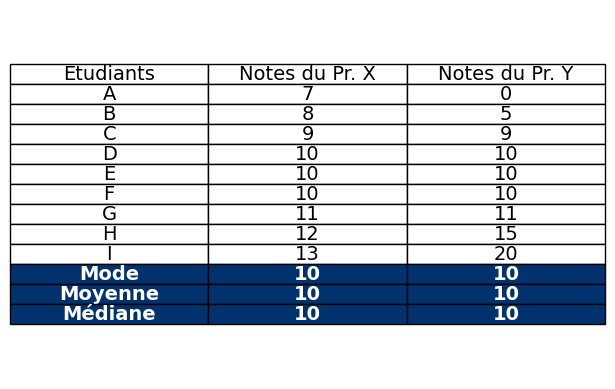

In [1342]:
data = {
    "Etudiants": ["A", "B", "C", "D", "E", "F", "G", "H", "I", "Mode", "Moyenne", "Médiane"],
    "Notes du Pr. X": [7, 8, 9, 10, 10, 10, 11, 12, 13, 10, 10, 10],
    "Notes du Pr. Y": [0, 5, 9, 10, 10, 10, 11, 15, 20, 10, 10, 10]
}

df = pd.DataFrame(data)

# Créer la figure et les axes
fig, ax = plt.subplots()

# Masquer les axes
ax.axis('off')
ax.axis('tight')

# Créer le tableau
table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')

# Appliquer le style
for (i, j), cell in table.get_celld().items():
    if i in [10, 11, 12]:  # Mettre en gras et changer la couleur de fond pour les lignes "Mode", "Moyenne" et "Médiane"
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#01326E')

# Ajuster la taille du tableau
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1.2, 1.2)

In [1343]:
sld_univ_central_lim = Slide()

sld_univ_central_lim.add_title("Moyenne, mode et médiane : limites ", icon="fas fa-infinity fa-beat", **title_stretch)

txt = markdown("""
*Le résumé d'une distribution que donne une valeur centrale ne nous renseigne pas sur la __dispersion__ des valeurs autour de cette valeur centrale, c'est-à-dire sur la tendance qu'elles-ont à se concentrer ou se disperser autour de celle-ci. (Claude Grasland)*
""")


sld_univ_central_lim.add_content([txt,fig], columns=[6,6], styles=[text60]*2)

slides.append(sld_univ_central_lim)

In [1365]:
df = pd.DataFrame(data)

# Transformation des données pour Altair (melt)
df_melt = df.melt(id_vars=["Etudiants"], var_name="Professeur", value_name="Notes")

# Créer le graphique avec Altair
g = alt.Chart(df_melt).mark_bar(opacity=0.5).encode(
    x=alt.X('Notes:Q', bin=alt.Bin(step=1), title='Notes'),
    y=alt.Y('count()', title='Fréquence'),
    color=alt.Color('Professeur:N', legend=None),  # Retire la légende pour la couleur
    fill=alt.Fill('Professeur:N', legend=None)     # Retire la légende pour le remplissage
).properties(
    title='Dispersion des notes',
    width=300,
    height=300
).facet(
    column=alt.Column('Professeur:N', header=alt.Header(title=''))
).configure_facet(
    spacing=30  # Ajuste l'espacement entre les facettes
).configure_view(
    stroke=None  # Supprime les bordures autour des graphiques
)
g

alt.FacetChart(...)

In [1345]:
sld_univ_central_lim2 = Slide()

sld_univ_central_lim2.add_title("Moyenne, mode et médiane : limites ", icon="fas fa-infinity fa-beat", **title_stretch)

txt = markdown("""
Les valeurs centrales sont identiques pour les notes des deux professeurs, mais leur **dispersion** est différente
""")

sld_univ_central_lim2.add_content([txt], columns=[12], styles=[text60])



sld_univ_central_lim2.add_content([g.to_json()], columns=[12],)

slides.append(sld_univ_central_lim2)

In [1346]:
p.add_slide(slides)
p.save_html("L1PRO_cartostat_CM.html")

<hr>

<hr>

<hr>

<h1> Analyse univariée</h1>

<div class="container">
    <div class="row" > 
        <div class="text-center">
            <i class="fa-solid fa-magnifying-glass-chart fa-2xl fa-fade" style="color: #94bc14"></i>
        </div>
    </div>
</div>


<hr>

<h2> <i class="fa-solid fa-ranking-star" style="color: #94bc14"></i> Résumer la série statistique à l'aide des valeurs centrales  </h2>  

In [1347]:
def vc_graph(_source, color):
    label = _source.CS1_6_label.unique()[0]
    median = round(_source.OBS_VALUE_p.median(), 1)
    mean = round(_source.OBS_VALUE_p.mean(), 1)

    _base = alt.Chart(_source, title="", width=345, height=275)

    _kd = (
        _base.transform_density(
            "OBS_VALUE_p",
            as_=["OBS_VALUE_p", "value"],
            counts=True,
        )
        .mark_area(opacity=0.9, color=color)
        .encode(
            x=alt.X(
                "OBS_VALUE_p:Q", title=f"{label} (%)", scale=alt.Scale(domain=(0, 60))
            ),
            y=alt.Y(
                "value:Q",
                title="Nombre de départements",
                scale=alt.Scale(domain=(0, 25)),
            ),
            tooltip=[alt.Tooltip("value:Q", title="Nombre de départements")],
        )
    )

    cs_mean = (
        alt.Chart()
        .mark_rule(color="#e45756", opacity=0.95)
        .encode(x=alt.datum(mean), size=alt.value(5))
    )

    cs_med = (
        alt.Chart()
        .mark_rule(color="#333333", opacity=0.5)
        .encode(x=alt.datum(median), size=alt.value(5))
    )

    text_mean = (
        alt.Chart()
        .mark_text(
            align="left",
            baseline="bottom",
            fontSize=12,
            fontWeight="bold",
            color="#e45756",
        )
        .encode(
            x=alt.value(200),
            y=alt.value(50),
            text=alt.value(["Moyenne:" f"{mean}"]),
        )
    )

    text_med = (
        alt.Chart()
        .mark_text(
            align="left",
            baseline="bottom",
            fontSize=12,
            fontWeight="bold",
            color="#333333",
        )
        .encode(
            x=alt.value(200),
            y=alt.value(65),
            text=alt.value(["Médiane:" f"{median}"]),
        )
    )

    return _kd + cs_mean + cs_med + text_mean + text_med


vc_1 = vc_graph(csp_fr.query("CS1_6=='1'"), color="#4c78a8")
vc_2 = vc_graph(csp_fr.query("CS1_6=='2'"), color="#f58518")
vc_3 = vc_graph(csp_fr.query("CS1_6=='3'"), color="#e45756")
vc_4 = vc_graph(csp_fr.query("CS1_6=='4'"), color="#eeca3b")
vc_5 = vc_graph(csp_fr.query("CS1_6=='5'"), color="#72b7b2")
vc_6 = vc_graph(csp_fr.query("CS1_6=='6'"), color="#54a24b")

In [1348]:
alt.vconcat(
    alt.hconcat(vc_1, vc_2, vc_3), alt.hconcat(vc_4, vc_5, vc_6)
).configure_legend(
    titleFontSize=14,
    labelFontSize=13,
    labelColor=EnvVar.template["LEG_LABEL_COL"],
    titleColor=EnvVar.template["LEG_TITLE_COL"],
    titleLimit=500,
    titlePadding=7,
    direction="horizontal",
    orient="bottom",
    columnPadding=10,
    columns=2,
    rowPadding=12,
    symbolType="square",
).configure_title(
    fontSize=17, color="gray"
).resolve_scale(
    color="independent"
).configure_axis(
    labelFontSize=15,
    titleFontSize=15,
    labelColor="gray",
    titleColor="gray",
)

alt.VConcatChart(...)

<hr>

<h2> <i class="fa-solid fa-ruler-horizontal" style="color: #94bc14"></i> Mesurer l'hétérogénéité de la série avec les paramètres de dispersion</h2> 

In [1349]:
csp_std = (
    csp_fr.groupby("CS1_6_label")["OBS_VALUE_p"]
    .agg(["mean", "std"])
    .reset_index()
    .round(1)
)

csp_std_bar = (
    alt.Chart(csp_std, title="Ecart-type", width=500, height=250)
    .mark_rule(size=5.0)
    .encode(
        x=alt.X("std:Q", title="", scale=alt.Scale(zero=False)),
        y=alt.Y("CS1_6_label:N", title=""),
        color=alt.Color("CS1_6_label:N", legend=None),
    )
)

csp_err_bar = (
    alt.Chart(csp_fr, title="Moyenne +/- 1 écart-type", width=500, height=250)
    .mark_errorbar(extent="stdev", thickness=5.0, opacity=0.75)
    .encode(
        x=alt.X("OBS_VALUE_p:Q", title="", scale=alt.Scale(zero=False)),
        y=alt.Y("CS1_6_label:N", title="", axis=alt.Axis(labels=False)),
        color=alt.Color("CS1_6_label:N", legend=None),
    )
)

csp_err_points = (
    alt.Chart(csp_fr)
    .mark_square(filled=True, size=70)
    .encode(
        x=alt.X("mean(OBS_VALUE_p)"),
        y=alt.Y("CS1_6_label:N"),
        color=alt.Color("CS1_6_label:N", legend=None),
    )
)

csall_base = alt.Chart(
    csp_fr,
    title="Ecart interquartile (Q3-Q1) et médiane (Q2)",
    width=1000,
    height=250,
)
cs6_box = csall_base.mark_boxplot(size=15).encode(
    x=alt.X(
        "OBS_VALUE_p:Q",
        scale=alt.Scale(domain=(0, 50)),
        title="Part de chaque CSP dans les emplois des départements (%)",
    ),
    y=alt.Y("CS1_6_label:N", title=""),
    color=alt.Color("CS1_6_label:N", legend=alt.Legend(title="")),
    tooltip=[alt.Tooltip("OBS_VALUE_p")],
)

In [1350]:
alt.vconcat(
    alt.hconcat(csp_std_bar, (csp_err_bar + csp_err_points)), cs6_box
).configure_title(fontSize=17, color="gray").configure_axis(
    labelFontSize=15,
    titleFontSize=15,
    labelColor="gray",
    titleColor="gray",
)

alt.VConcatChart(...)

<hr>

<h2> <i class="fa-solid fa-calculator" style="color: #94bc14"></i> Calculs des valeurs centrales et paramètres de dispersion</h2>

In [1351]:
df_univ = (
    csp_fr.groupby("CS1_6_label")["OBS_VALUE_p"]
    .describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])
    .reset_index()
)
df_univ["EI"] = df_univ["75%"] - df_univ["25%"]
df_univ.round(1)

,CS1_6_label,count,mean,std,min,5%,25%,50%,75%,95%,max,EI
0,Agriculteurs exploitants,100.0,2.7,2.1,0.0,0.2,1.2,2.4,3.6,6.0,10.7,2.4
1,"Artisans, commerçants, chefs entreprise",100.0,7.5,1.8,4.0,5.3,6.1,7.3,8.7,11.0,11.8,2.7
2,Cadres et professions intellectuelles supérieures,100.0,13.9,5.7,8.3,9.1,10.5,12.0,14.6,24.8,44.1,4.1
3,Employés,100.0,28.7,2.4,19.7,25.0,27.4,28.4,30.2,33.0,34.5,2.7
4,Ouvriers,100.0,22.0,4.3,7.7,14.9,19.1,21.7,25.3,27.9,30.8,6.2
5,Professions intermédiaires,100.0,25.3,1.7,21.4,22.5,24.0,25.2,26.7,27.8,29.0,2.7


<hr>

<h2> <i class="fa-solid fa-magnifying-glass-chart" style="color: #94bc14"></i> Décrire la forme de la série statistique à l'aide de graphiques</h2>

In [1352]:
alt.Chart(csp_fr, width=380, height=300).transform_density(
    "OBS_VALUE_p",
    groupby=["CS1_6_label"],
    as_=["OBS_VALUE_p", "value"],
    counts=True,
).mark_area().encode(
    x=alt.X(
        "OBS_VALUE_p:Q",
        title=["Part de chaque CSP dans", "les emplois des départements (%)"],
    ),
    y=alt.Y("value:Q", title="Nombre de départements"),
    color=alt.Color("CS1_6_label:N", legend=None),
).facet(
    facet=alt.Facet(
        "CS1_6_label:N",
        title=None,
        header=alt.Header(labelFontSize=15, labelColor="grey"),
    ),
    columns=3,
    title="Répartition des catégories socio-professionnels en 2018 par département (%)",
).configure_title(
    fontSize=20, offset=5, orient="top", anchor="middle", color="gray"
).configure_axis(
    labelFontSize=15,
    titleFontSize=15,
    labelColor="gray",
    titleColor="gray",
)

alt.FacetChart(...)

<hr>

<h2> <i class="fa-solid fa-magnifying-glass" style="color: #94bc14"></i> Décrire la forme de la série statistique à l'aide de calculs</h2>

Le Kurtosis (aplatissement) et le Skew (coefficients d'asymétrie) permettent de caractériser par le calcul des séries

$${\displaystyle ~Kurtosis={\frac {(n+1)\,n}{(n-1)\,(n-2)\,(n-3)}}\;\sum _{i=1}^{n}\left({\frac {x_{i}-{\bar {x}}}{\sigma }}\right)^{4}-3\,{\frac {(n-1)^{2}}{(n-2)(n-3)}}}$$

Pour une loi normale, le skew est égale à 0 et 3 pour le Kurtosis (0 s'il est normalisé comme dans la formule)

$${\displaystyle Skew={\frac {n}{(n-1)\,(n-2)}}\;\sum _{i=1}^{n}\left({\frac {x_{i}-{\bar {x}}}{\sigma }}\right)^{3}}$$


Un Skew proche de 0 traduit généralement une série symétrique. Un Skew négatif une série étirée à gauche, positif une série étirée à droite


In [1353]:
s = csp_fr.groupby("CS1_6_label")["OBS_VALUE_p"].skew()
k = csp_fr.groupby("CS1_6_label")["OBS_VALUE_p"].agg(pd.Series.kurt)
df_skew = pd.concat([s, k], axis=1, keys=["Skew", "Kurtosis"]).reset_index()
df_skew.round(1)

,CS1_6_label,Skew,Kurtosis
0,Agriculteurs exploitants,1.7,3.9
1,"Artisans, commerçants, chefs entreprise",0.6,-0.6
2,Cadres et professions intellectuelles supérieures,2.7,9.8
3,Employés,-0.2,1.6
4,Ouvriers,-0.6,0.6
5,Professions intermédiaires,-0.1,-0.8


<hr>

<h2> <i class="fa-solid fa-sitemap" style="color: #94bc14"></i> Forme des séries</h2>  


In [1354]:
svg = """<?xml version="1.0" encoding="UTF-8"?><svg version="1.1" viewBox="0 0 1000 662.38" xmlns="http://www.w3.org/2000/svg"><defs><clipPath id="d"><path d="m25.512 29.574h311.82v204.38h-311.82z" stroke-width=".7566"/></clipPath><clipPath id="c"><path d="m25.512 29.574h311.82v204.38h-311.82z" stroke-width=".7566"/></clipPath><clipPath id="b"><path d="m25.512 29.574h311.82v204.38h-311.82z" stroke-width=".7566"/></clipPath><clipPath id="a"><path d="m25.512 29.574h311.82v204.38h-311.82z" stroke-width=".7566"/></clipPath></defs><g transform="matrix(1.3333 0 0 -1.3333 -49.034 302.52)"><g transform="matrix(2.2322 0 0 2.2322 5.6022 -313.29)" clip-path="url(#a)"><path d="m187.26 160.68s8.7985 2.891 12.981 5.5209c2.2668 1.4277 4.5275 3.1149 6.4901 5.5209 2.4824 3.0438 4.6992 6.8215 6.4901 11.042 1.4126 3.3396 2.1631 7.3617 3.2451 11.044 2.1631 7.3594 3.6589 15.407 6.4871 22.084 0.89581 2.1102 1.7175 5.5209 3.245 5.5209 1.5314 0 2.3523-3.4108 3.2451-5.5209 4.2445-10.016 5.4944-23.112 9.7352-33.128 1.7886-4.2203 3.665-9.0497 6.4901-11.042 2.9969-2.1102 6.5204-0.74449 9.7359 0 2.1457 0.49936 4.3149 1.3331 6.2563 2.9583 2.2554 1.8854 4.3565 4.504 6.0263 7.6901 2.0867 3.9782 2.6746 9.8123 4.7522 13.802 0.67715 1.3006 1.4186 2.9704 2.4355 3.1565 1.3566 0.24514 2.6277-1.5336 3.7058-2.9583 3.8397-5.0654 5.474-13.979 9.2714-19.128 1.8945-2.5626 4.2234-4.0932 6.4901-5.5209 4.1825-2.6307 8.6154-3.9752 12.981-5.5209 6.4394-2.2789 19.47-5.5209 19.47-5.5209" color="#000000" fill="#747c7c" stroke-width=".56745" style="-inkscape-stroke:none"/><path d="m326.72 160.4s-13.025 3.2385-19.498 5.5293c-4.3574 1.5428-8.815 2.8932-13.037 5.5488-2.27 1.4297-4.6379 2.9832-6.5664 5.5918-1.9336 2.6216-3.2932 6.1554-4.6562 9.6602-1.363 3.5047-2.7301 6.9805-4.6133 9.4648-0.541 0.71486-1.1246 1.5048-1.7188 2.0703-0.59361 0.565-1.1646 0.87688-1.709 0.77929-0.37263-0.0682-0.77917-0.45833-1.1602-1.0371-0.38098-0.57878-0.73421-1.3139-1.0762-1.9707-2.0354-3.9085-2.6224-9.7429-4.752-13.803-1.6856-3.2161-3.8076-5.8627-6.0957-7.7754-1.9846-1.6613-4.2025-2.512-6.375-3.0176-1.5928-0.36878-3.2872-0.90137-4.9844-1.0762-1.6972-0.17481-3.4137 0.0193-4.9785 1.1211-2.9533 2.0825-4.8018 6.9478-6.5879 11.162-4.2676 10.079-5.5167 23.176-9.7344 33.129-0.45561 1.0769-0.88424 2.454-1.3809 3.5449-0.24831 0.54546-0.5155 1.0167-0.79101 1.334-0.27552 0.31733-0.53499 0.46875-0.8125 0.46875-0.27631 0-0.53538-0.15139-0.81055-0.46875-0.27517-0.31735-0.54264-0.78846-0.79102-1.334-0.49676-1.091-0.92561-2.468-1.3828-3.5449-2.8102-6.6339-4.3076-14.674-6.4766-22.053-1.0762-3.6628-1.8255-7.6945-3.2559-11.076-1.8-4.2418-4.0285-8.0406-6.5312-11.109-1.989-2.4383-4.2785-4.146-6.5586-5.582-4.255-2.6755-13.043-5.5508-13.043-5.5508l-0.17774 0.53907s8.808 2.9078 12.918 5.4922c2.2535 1.4193 4.4856 3.0854 6.4219 5.459 2.462 3.0188 4.6674 6.7758 6.4492 10.975 1.3948 3.2976 2.1467 7.3117 3.2344 11.014 2.1573 7.3397 3.652 15.395 6.498 22.113 0.43861 1.0332 0.86875 2.4167 1.3887 3.5586 0.25996 0.57094 0.54044 1.0846 0.87695 1.4727s0.75276 0.66211 1.2402 0.66211c0.48816 0 0.90519-0.27398 1.2422-0.66211 0.337-0.38813 0.61702-0.90166 0.87696-1.4727 0.51986-1.142 0.94954-2.5253 1.3867-3.5586 4.2714-10.079 5.5224-23.174 9.7363-33.127 1.7911-4.2263 3.6936-9.0201 6.3906-10.922 1.4321-1.0084 2.9761-1.1861 4.5938-1.0195s3.2933 0.68875 4.916 1.0644c2.1189 0.49313 4.2404 1.3113 6.1387 2.9004 2.2228 1.8581 4.303 4.4475 5.957 7.6035 2.0439 3.8966 2.6321 9.7302 4.752 13.801 0.3352 0.6438 0.69026 1.3937 1.1035 2.0215 0.41325 0.6278 0.88701 1.1653 1.5312 1.2832h2e-3c0.81172 0.14668 1.5531-0.30705 2.2031-0.92578 0.65006-0.61874 1.2421-1.4308 1.7793-2.1406 1.9566-2.5811 3.3261-6.0941 4.6894-9.5996 1.3634-3.5055 2.7202-7.0023 4.584-9.5293h-2e-3c1.8606-2.5166 4.1505-4.0236 6.4141-5.4492 4.1429-2.6058 8.5501-3.9455 12.924-5.4941 6.4057-2.267 19.445-5.5137 19.445-5.5137z" color="#000000" fill="#fff" style="-inkscape-stroke:none"/></g><g transform="matrix(2.2322 0 0 2.2322 5.6022 -313.29)" clip-path="url(#b)"><path d="m42.955 49.434s2.5149 22.358 5.1895 33.255c1.5578 6.3335 3.5522 12.608 6.2836 18.534 1.4156 3.0741 2.5921 6.5522 5.1895 8.7221 1.7909 1.495 4.2763 2.9462 6.5582 2.4529 7.1083-1.5344 10.356-10.194 15.436-15.392 4.9361-5.0511 9.3985-10.58 14.609-15.348 4.5487-4.1583 9.3864-8.0298 14.479-11.509 7.3057-4.992 14.833-9.8184 22.946-13.356 5.1456-2.2463 10.616-3.7686 16.116-4.9066 7.8966-1.6343 24.039-2.7245 24.039-2.7245" color="#000000" fill="#747c7c" stroke-width=".56745" style="-inkscape-stroke:none"/><path d="m173.78 48.879s-16.131 1.0857-24.078 2.7305c-5.5131 1.1405-11.002 2.6668-16.172 4.9238-8.1408 3.5492-15.682 8.3876-22.992 13.383-5.1045 3.4869-9.9538 7.3665-14.512 11.533-5.2318 4.7866-9.6957 10.319-14.619 15.357-2.5738 2.634-4.6577 6.1081-6.9785 9.0957-2.3209 2.9876-4.8592 5.4729-8.3145 6.2188-2.128 0.46003-4.5553-0.92437-6.3164-2.3945-2.5153-2.1013-3.6906-5.5294-5.1152-8.623-2.7214-5.9042-4.7108-12.161-6.2656-18.482-2.663-10.849-5.1816-33.219-5.1816-33.219l-0.56445 0.06445s2.5091 22.347 5.1953 33.291c1.5609 6.3458 3.5596 12.637 6.3008 18.584 1.4066 3.0544 2.5861 6.5818 5.2656 8.8203 1.8207 1.5199 4.365 3.0402 6.8008 2.5137 3.653-0.78853 6.2924-3.4005 8.6426-6.4258s4.4296-6.4823 6.9355-9.0469c4.9486-5.0639 9.41-10.588 14.6-15.336 4.5391-4.1495 9.3669-8.0139 14.447-11.484 7.3011-4.9889 14.813-9.8031 22.898-13.328 5.1211-2.2356 10.573-3.7534 16.061-4.8887 7.846-1.6238 24.002-2.7207 24.002-2.7207z" color="#000000" fill="#fff" style="-inkscape-stroke:none"/></g><g transform="matrix(2.2322 0 0 2.2322 5.6022 -313.29)" clip-path="url(#c)"><path d="m39.648 160.73s20.999 0.74752 29.77 5.7713c7.1438 4.097 11.943 11.571 16.321 18.543 6.7148 10.696 9.1231 25.426 14.733 34.901 1.315 2.2199 3.0029 4.9066 5.3227 5.8962 2.7192 1.1614 4.5933 0.87463 6.6202 0 2.3916-1.0282 4.1318-3.6703 5.3643-5.6745 6.2094-10.081 8.11-24.917 14.541-36.234 3.5553-6.2541 6.9895-13.35 13.093-17.157 8.7743-5.471 30.424-6.0468 30.424-6.0468" color="#000000" fill="#747c7c" stroke-width=".56745" style="-inkscape-stroke:none"/><path d="m175.83 160.45s-5.4246 0.14483-11.949 0.9746c-6.5246 0.82978-14.145 2.3267-18.617 5.1152-6.1973 3.8649-9.641 11.016-13.189 17.258-6.4719 11.388-8.3774 26.228-14.535 36.225-1.2284 1.9975-2.9589 4.5842-5.2344 5.5625-1.9892 0.85836-3.7361 1.1363-6.3965 0-2.195-0.93639-3.8795-3.5647-5.1914-5.7793-5.5619-9.3946-7.9754-24.139-14.736-34.908-4.3788-6.9738-9.1945-14.493-16.42-18.637-4.4651-2.5574-11.919-3.988-18.279-4.8047-6.3602-0.81667-11.621-1.0039-11.621-1.0039l-0.01953 0.5664s5.2365 0.18697 11.568 1c6.3319 0.81304 13.764 2.268 18.07 4.7344 7.0622 4.0502 11.844 11.477 16.221 18.447 6.6687 10.623 9.0716 25.339 14.729 34.895 1.3181 2.2251 3.0125 4.9688 5.457 6.0117 2.778 1.1865 4.7791 0.89089 6.8438 0 2.5078-1.0782 4.2556-3.7742 5.4922-5.7852 6.261-10.165 8.1566-24.997 14.547-36.242 3.562-6.266 6.9864-13.309 12.996-17.057 4.302-2.6824 11.895-4.2093 18.389-5.0352 6.4937-0.82585 11.893-0.96874 11.893-0.96875z" color="#000000" fill="#fff" style="-inkscape-stroke:none"/></g><path d="m248.46 33.142v159.4h1.2686v-159.4z" color="#000000" fill="#94bc14" stroke-width="2.2322" style="-inkscape-stroke:none"/><path d="m572.31 33.519v159.4h1.2686v-159.4z" color="#000000" fill="#94bc14" stroke-width="2.2322" style="-inkscape-stroke:none"/><path d="m88.241-218.05v1.2687h312.76v-1.2687z" color="#000000" fill="#94bc14" stroke-width="2.2322" style="-inkscape-stroke:none"/><path d="m87.691 32.824v1.2687h312.76v-1.2687z" color="#000000" fill="#94bc14" stroke-width="2.2322" style="-inkscape-stroke:none"/><path d="m148.36-217.39v155.19h1.2687v-155.19z" color="#000000" fill="#94bc14" stroke-width="2.2322" style="-inkscape-stroke:none"/><path d="m179.18-217.44v130.85h1.2643v-130.85z" color="#000000" fill="#94bc14" stroke-width="2.2322" style="-inkscape-stroke:none"/><g transform="matrix(2.2322 0 0 2.2322 5.6022 -313.29)" clip-path="url(#d)"><path d="m320.88 49.49s-2.5149 22.358-5.1926 33.255c-1.5548 6.3365-3.55 12.611-6.2805 18.537-1.4156 3.071-2.5921 6.5522-5.1903 8.7221-1.7909 1.495-4.2763 2.9462-6.5582 2.4529-7.1075-1.5367-10.356-10.197-15.436-15.392-4.9353-5.0541-9.3985-10.58-14.611-15.348-4.5487-4.1613-9.3871-8.0298-14.476-11.509-7.3057-4.992-14.834-9.8184-22.946-13.359-5.1456-2.2433-10.617-3.7656-16.116-4.9066-7.8974-1.6343-24.04-2.7245-24.04-2.7245" color="#000000" fill="#747c7c" stroke-width=".56745" style="-inkscape-stroke:none"/><path d="m190.05 48.936-0.0391 0.56641s16.155 1.095 24.002 2.7188c5.4872 1.1384 10.939 2.656 16.061 4.8887 8.0846 3.5281 15.599 8.3451 22.9 13.334 5.0772 3.4708 9.906 7.3297 14.445 11.482 5.1919 4.7481 9.6518 10.271 14.6 15.338 2.5063 2.5631 4.5854 6.0176 6.9356 9.043 2.3502 3.0254 4.99 5.638 8.6426 6.4277 2.4358 0.52657 4.9801-0.99181 6.8008-2.5117 2.6804-2.2386 3.8591-5.771 5.2656-8.8223 2.7404-5.9471 4.741-12.239 6.2988-18.588 2.6892-10.944 5.1992-33.291 5.1992-33.291l-0.56445-0.0625s-2.5196 22.37-5.1856 33.219c-1.5518 6.3241-3.543 12.582-6.2637 18.486-1.4247 3.0908-2.5974 6.5218-5.1133 8.623-1.7611 1.4702-4.1884 2.8526-6.3164 2.3926-3.4549-0.74695-5.9936-3.233-8.3144-6.2207-2.3209-2.9877-4.4043-6.4593-6.9785-9.0918-4.9228-5.0413-9.389-10.573-14.623-15.359-4.558-4.1698-9.4072-8.0463-14.508-11.533-7.3104-4.9952-14.852-9.8326-22.992-13.385h-2e-3c-5.1701-2.254-10.66-3.7803-16.172-4.9238-7.948-1.6447-24.078-2.7305-24.078-2.7305z" color="#000000" fill="#fff" style="-inkscape-stroke:none"/></g><path d="m422.33-217.93v1.2687h312.77v-1.2687z" color="#000000" fill="#94bc14" stroke-width="2.2322" style="-inkscape-stroke:none"/><path d="m673.72-217.27v154.78h1.2643v-154.78z" color="#000000" fill="#94bc14" stroke-width="2.2322" style="-inkscape-stroke:none"/><path d="m642.89-217.32v130.86h1.2643v-130.86z" color="#000000" fill="#94bc14" stroke-width="2.2322" style="-inkscape-stroke:none"/><g transform="matrix(2.2322 0 0 -2.2322 5.6022 -313.29)" fill="#94bc14" stroke-width=".7566" aria-label="Moyenne Médiane MoyenneMédianeMoyenneMédiane"><path d="m97.465-148.87q-0.06809-0.16342-0.18385-0.41537-0.10895-0.25195-0.23833-0.54475-0.12938-0.29281-0.27919-0.59923-0.143-0.31323-0.27238-0.58561-0.12938-0.27918-0.24514-0.49709-0.10895-0.2179-0.17704-0.33366-0.0749 0.80351-0.12257 1.7432-0.04766 0.93289-0.08171 1.8862h-0.64689q0.02724-0.61284 0.06128-1.2325 0.03405-0.62646 0.0749-1.2257 0.04766-0.60604 0.09533-1.178 0.05447-0.57198 0.11576-1.0827h0.5788q0.18385 0.29961 0.39494 0.70818 0.21109 0.40856 0.42218 0.85798 0.21109 0.44261 0.40856 0.89203 0.19747 0.44261 0.3609 0.81032 0.16343-0.36771 0.3609-0.81032 0.19747-0.44942 0.40856-0.89203 0.21109-0.44942 0.42218-0.85798 0.21109-0.40857 0.39494-0.70818h0.5788q0.23152 2.2812 0.34728 4.7189h-0.64689q-0.03405-0.95331-0.08171-1.8862-0.04767-0.9397-0.12257-1.7432-0.06809 0.11576-0.18385 0.33366-0.10895 0.21791-0.23833 0.49709-0.12938 0.27238-0.27918 0.58561-0.143 0.30642-0.27238 0.59923-0.12938 0.2928-0.24514 0.54475-0.10895 0.25195-0.17704 0.41537z"/><path d="m104.36-149.99q0 0.42218-0.12257 0.76265t-0.34728 0.58561q-0.2179 0.24514-0.52432 0.38133-0.30642 0.12938-0.66732 0.12938t-0.66732-0.12938q-0.30643-0.13619-0.53114-0.38133-0.2179-0.24514-0.34047-0.58561t-0.12257-0.76265q0-0.41537 0.12257-0.75584 0.12257-0.34728 0.34047-0.59242 0.22471-0.24514 0.53114-0.37452 0.30642-0.13619 0.66732-0.13619t0.66732 0.13619q0.30642 0.12938 0.52432 0.37452 0.22471 0.24514 0.34728 0.59242 0.12257 0.34047 0.12257 0.75584zm-0.66051 0q0-0.59923-0.27238-0.94651-0.26556-0.35409-0.7286-0.35409t-0.73542 0.35409q-0.26556 0.34728-0.26556 0.94651t0.26556 0.95332q0.27238 0.34728 0.73542 0.34728t0.7286-0.34728q0.27238-0.35409 0.27238-0.95332z"/><path d="m104.74-147.56q0.0749 0.034 0.19067 0.0613 0.12257 0.0341 0.23833 0.0341 0.37451 0 0.58561-0.17024 0.21109-0.16342 0.38132-0.53794-0.42899-0.81713-0.80351-1.7296-0.36771-0.91927-0.61284-1.859h0.68094q0.0749 0.30642 0.17704 0.66051 0.10895 0.35409 0.23833 0.7286 0.12938 0.37452 0.27919 0.74904 0.1498 0.37451 0.31323 0.72179 0.25875-0.71498 0.44942-1.4164 0.19066-0.70137 0.3609-1.4436h0.6537q-0.24514 1.001-0.54475 1.9271-0.29962 0.91927-0.6469 1.7228-0.13618 0.30643-0.28599 0.52433-0.143 0.22471-0.32004 0.36771-0.17705 0.14299-0.40176 0.21109-0.2179 0.0681-0.49708 0.0681-0.0749 0-0.15662-0.0136-0.0817-7e-3 -0.16343-0.0272-0.0749-0.0136-0.14299-0.0341-0.0613-0.0204-0.0885-0.0341z"/><path d="m108.35-149.98q0-0.46985 0.13618-0.81713 0.13619-0.35409 0.3609-0.58561t0.51752-0.34728q0.2928-0.11576 0.59922-0.11576 0.71499 0 1.0963 0.44942 0.38132 0.44262 0.38132 1.3551 0 0.0409 0 0.10895 0 0.0613-7e-3 0.11576h-2.4241q0.0409 0.55156 0.32004 0.83755 0.27918 0.286 0.8716 0.286 0.33366 0 0.55837-0.0545 0.23152-0.0613 0.34728-0.11576l0.0885 0.53113q-0.11576 0.0613-0.40856 0.12938-0.28599 0.0681-0.6537 0.0681-0.46304 0-0.80351-0.13619-0.33366-0.143-0.55156-0.38814-0.2179-0.24513-0.32685-0.5788-0.10214-0.34047-0.10214-0.74222zm2.431-0.34728q7e-3 -0.42899-0.2179-0.70137-0.2179-0.27918-0.60604-0.27918-0.2179 0-0.38813 0.0885-0.16343 0.0817-0.27919 0.2179-0.11576 0.13619-0.18385 0.31323-0.0613 0.17705-0.0817 0.3609z"/><path d="m112.35-151.66q0.2179-0.0545 0.5788-0.11576 0.3609-0.0613 0.83075-0.0613 0.42218 0 0.70137 0.12257 0.27918 0.11576 0.44261 0.33366 0.17023 0.21109 0.23833 0.51071 0.0681 0.29961 0.0681 0.66051v1.9883h-0.63327v-1.8522q0-0.32685-0.0477-0.55837-0.0409-0.23152-0.143-0.37452-0.10214-0.143-0.27237-0.20428-0.17024-0.0681-0.42219-0.0681-0.10214 0-0.21109 7e-3t-0.21109 0.0204q-0.0953 7e-3 -0.17704 0.0204-0.0749 0.0136-0.10895 0.0204v2.9893h-0.63328z"/><path d="m116.26-151.66q0.2179-0.0545 0.5788-0.11576 0.36089-0.0613 0.83074-0.0613 0.42219 0 0.70137 0.12257 0.27919 0.11576 0.44261 0.33366 0.17024 0.21109 0.23833 0.51071 0.0681 0.29961 0.0681 0.66051v1.9883h-0.63328v-1.8522q0-0.32685-0.0477-0.55837-0.0409-0.23152-0.143-0.37452-0.10214-0.143-0.27238-0.20428-0.17023-0.0681-0.42218-0.0681-0.10214 0-0.21109 7e-3t-0.21109 0.0204q-0.0953 7e-3 -0.17705 0.0204-0.0749 0.0136-0.10895 0.0204v2.9893h-0.63327z"/><path d="m119.97-149.98q0-0.46985 0.13619-0.81713 0.13619-0.35409 0.3609-0.58561t0.51752-0.34728q0.2928-0.11576 0.59922-0.11576 0.71499 0 1.0963 0.44942 0.38132 0.44262 0.38132 1.3551 0 0.0409 0 0.10895 0 0.0613-7e-3 0.11576h-2.4241q0.0409 0.55156 0.32004 0.83755 0.27918 0.286 0.8716 0.286 0.33366 0 0.55837-0.0545 0.23152-0.0613 0.34728-0.11576l0.0885 0.53113q-0.11576 0.0613-0.40856 0.12938-0.28599 0.0681-0.6537 0.0681-0.46304 0-0.80351-0.13619-0.33366-0.143-0.55156-0.38814-0.2179-0.24513-0.32685-0.5788-0.10215-0.34047-0.10215-0.74222zm2.431-0.34728q7e-3 -0.42899-0.2179-0.70137-0.2179-0.27918-0.60604-0.27918-0.2179 0-0.38813 0.0885-0.16343 0.0817-0.27919 0.2179-0.11576 0.13619-0.18385 0.31323-0.0613 0.17705-0.0817 0.3609z"/><path d="m98.422-140.93q-0.06809-0.16343-0.18385-0.41538-0.10895-0.25194-0.23833-0.54475-0.12938-0.2928-0.27919-0.59923-0.143-0.31323-0.27238-0.5856-0.12938-0.27919-0.24514-0.49709-0.10895-0.2179-0.17704-0.33366-0.0749 0.80351-0.12257 1.7432-0.04766 0.93288-0.08171 1.8862h-0.64689q0.02724-0.61285 0.06128-1.2325 0.03405-0.62647 0.0749-1.2257 0.04766-0.60604 0.09533-1.178 0.05447-0.57199 0.11576-1.0827h0.5788q0.18385 0.29961 0.39494 0.70817 0.21109 0.40857 0.42218 0.85799 0.21109 0.44261 0.40856 0.89203 0.19747 0.44261 0.3609 0.81032 0.16343-0.36771 0.3609-0.81032 0.19747-0.44942 0.40856-0.89203 0.21109-0.44942 0.42218-0.85799 0.21109-0.40856 0.39494-0.70817h0.5788q0.23152 2.2811 0.34728 4.7189h-0.64689q-0.034-0.95332-0.0817-1.8862-0.0477-0.9397-0.12256-1.7432-0.0681 0.11576-0.18386 0.33366-0.10895 0.2179-0.23832 0.49709-0.12938 0.27237-0.27918 0.5856-0.143 0.30643-0.27238 0.59923-0.12938 0.29281-0.24514 0.54475-0.10895 0.25195-0.17704 0.41538z"/><path d="m102-142.04q0-0.46985 0.13619-0.81713 0.13618-0.35409 0.36089-0.58561t0.51752-0.34728q0.2928-0.11576 0.59923-0.11576 0.71498 0 1.0963 0.44942 0.38133 0.44261 0.38133 1.3551 0 0.0409 0 0.10895 0 0.0613-7e-3 0.11576h-2.4242q0.0409 0.55156 0.32004 0.83756 0.27919 0.28599 0.8716 0.28599 0.33367 0 0.55838-0.0545 0.23151-0.0613 0.34727-0.11576l0.0885 0.53113q-0.11576 0.0613-0.40857 0.12938-0.28599 0.0681-0.6537 0.0681-0.46304 0-0.80351-0.13619-0.33366-0.14299-0.55156-0.38813t-0.32685-0.5788q-0.10214-0.34047-0.10214-0.74222zm2.431-0.34728q7e-3 -0.429-0.2179-0.70137-0.2179-0.27919-0.60603-0.27919-0.2179 0-0.38814 0.0885-0.16343 0.0817-0.27919 0.21791-0.11575 0.13618-0.18385 0.31323-0.0613 0.17704-0.0817 0.3609zm-7e-3 -2.7714-0.96012 0.93289-0.32004-0.286 0.8716-1.0486z"/><path d="m108.29-143.07q-0.11576-0.0953-0.33366-0.18386-0.21791-0.0885-0.47666-0.0885-0.27238 0-0.46985 0.10214-0.19066 0.0953-0.31323 0.27238-0.12257 0.17023-0.17705 0.40856-0.0545 0.23833-0.0545 0.51071 0 0.61965 0.30642 0.96012 0.30642 0.33366 0.81713 0.33366 0.25876 0 0.42899-0.0204 0.17704-0.0272 0.27238-0.0545zm0-2.3833 0.63327-0.10895v5.182q-0.2179 0.0613-0.55837 0.12257-0.34047 0.0613-0.78308 0.0613-0.40857 0-0.73542-0.12938-0.32685-0.12937-0.55837-0.3677t-0.3609-0.5788q-0.12256-0.34728-0.12256-0.77627 0-0.40857 0.10214-0.74904 0.10895-0.34047 0.31323-0.58561t0.49708-0.38132q0.29962-0.13619 0.68094-0.13619 0.30643 0 0.53795 0.0817 0.23833 0.0817 0.35409 0.15662z"/><path d="m110.65-140.27h-0.63328v-3.5409h0.63328zm-0.32005-4.181q-0.17023 0-0.2928-0.10895-0.11576-0.11576-0.11576-0.30643 0-0.19066 0.11576-0.29961 0.12257-0.11576 0.2928-0.11576 0.17024 0 0.286 0.11576 0.12257 0.10895 0.12257 0.29961 0 0.19067-0.12257 0.30643-0.11576 0.10895-0.286 0.10895z"/><path d="m112.93-140.73q0.22471 0 0.39494-7e-3 0.17704-0.0136 0.2928-0.0409v-1.0554q-0.0681-0.0341-0.22471-0.0545-0.1498-0.0272-0.3677-0.0272-0.143 0-0.30643 0.0204-0.15661 0.0204-0.2928 0.0885-0.12938 0.0613-0.2179 0.17705-0.0885 0.10895-0.0885 0.2928 0 0.34047 0.2179 0.47666 0.2179 0.12938 0.59242 0.12938zm-0.0545-3.1732q0.38133 0 0.64008 0.10214 0.26557 0.0953 0.42219 0.27919 0.16342 0.17704 0.23152 0.42899 0.0681 0.24514 0.0681 0.54475v2.2131q-0.0817 0.0136-0.23152 0.0408-0.143 0.0204-0.32685 0.0409-0.18385 0.0204-0.40176 0.0341-0.21109 0.0204-0.42218 0.0204-0.29961 0-0.55156-0.0613t-0.4358-0.19066q-0.18386-0.13619-0.286-0.35409t-0.10214-0.52433q0-0.2928 0.11576-0.50389 0.12257-0.21109 0.32685-0.34047 0.20429-0.12938 0.47666-0.19067 0.27238-0.0613 0.57199-0.0613 0.0953 0 0.19747 0.0136 0.10215 7e-3 0.19067 0.0272 0.0953 0.0136 0.16342 0.0272 0.0681 0.0136 0.0953 0.0204v-0.17704q0-0.15662-0.034-0.30643-0.034-0.15661-0.12257-0.27237-0.0885-0.12257-0.24514-0.19067-0.14981-0.0749-0.39495-0.0749-0.31323 0-0.55156 0.0477-0.23152 0.0409-0.34728 0.0885l-0.0749-0.52432q0.12257-0.0545 0.40856-0.10215 0.286-0.0545 0.61966-0.0545z"/><path d="m115.29-143.71q0.2179-0.0545 0.5788-0.11576 0.36089-0.0613 0.83074-0.0613 0.42219 0 0.70137 0.12257 0.27919 0.11576 0.44261 0.33366 0.17024 0.21109 0.23833 0.5107 0.0681 0.29962 0.0681 0.66052v1.9883h-0.63328v-1.8522q0-0.32685-0.0477-0.55837-0.0409-0.23152-0.143-0.37451-0.10214-0.143-0.27238-0.20429-0.17023-0.0681-0.42218-0.0681-0.10214 0-0.21109 7e-3t-0.21109 0.0204q-0.0953 7e-3 -0.17705 0.0204-0.0749 0.0136-0.10895 0.0204v2.9893h-0.63327z"/><path d="m119-142.04q0-0.46985 0.13619-0.81713 0.13619-0.35409 0.3609-0.58561t0.51752-0.34728q0.2928-0.11576 0.59922-0.11576 0.71499 0 1.0963 0.44942 0.38132 0.44261 0.38132 1.3551 0 0.0409 0 0.10895 0 0.0613-7e-3 0.11576h-2.4241q0.0408 0.55156 0.32004 0.83756 0.27918 0.28599 0.8716 0.28599 0.33366 0 0.55837-0.0545 0.23152-0.0613 0.34728-0.11576l0.0885 0.53113q-0.11576 0.0613-0.40856 0.12938-0.28599 0.0681-0.6537 0.0681-0.46304 0-0.80351-0.13619-0.33366-0.14299-0.55156-0.38813t-0.32685-0.5788q-0.10215-0.34047-0.10215-0.74222zm2.431-0.34728q7e-3 -0.429-0.2179-0.70137-0.2179-0.27919-0.60604-0.27919-0.2179 0-0.38813 0.0885-0.16343 0.0817-0.27919 0.21791-0.11576 0.13618-0.18385 0.31323-0.0613 0.17704-0.0817 0.3609z"/><path d="m77.281-36.482q-0.06809-0.16342-0.18385-0.41537-0.10895-0.25195-0.23833-0.54475-0.12938-0.2928-0.27918-0.59923-0.143-0.31323-0.27238-0.58561-0.12938-0.27918-0.24514-0.49709-0.10895-0.2179-0.17704-0.33366-0.0749 0.80351-0.12257 1.7432-0.04767 0.93289-0.08171 1.8862h-0.64689q0.02724-0.61285 0.06128-1.2325 0.03405-0.62646 0.0749-1.2257 0.04767-0.60604 0.09533-1.178 0.05447-0.57199 0.11576-1.0827h0.5788q0.18385 0.29961 0.39494 0.70818 0.21109 0.40856 0.42218 0.85798 0.21109 0.44261 0.40856 0.89203 0.19747 0.44261 0.3609 0.81032 0.16342-0.36771 0.3609-0.81032 0.19747-0.44942 0.40856-0.89203 0.21109-0.44942 0.42218-0.85798 0.21109-0.40856 0.39494-0.70818h0.5788q0.23152 2.2812 0.34728 4.7189h-0.64689q-0.03405-0.95332-0.08171-1.8862-0.04767-0.9397-0.12257-1.7432-0.06809 0.11576-0.18385 0.33366-0.10895 0.2179-0.23833 0.49709-0.12938 0.27238-0.27919 0.58561-0.143 0.30642-0.27238 0.59923-0.12938 0.2928-0.24514 0.54475-0.10895 0.25195-0.17704 0.41537z"/><path d="m84.179-37.598q0 0.42218-0.12257 0.76265-0.12257 0.34047-0.34728 0.58561-0.2179 0.24514-0.52432 0.38133-0.30642 0.12938-0.66732 0.12938t-0.66732-0.12938q-0.30642-0.13619-0.53113-0.38133-0.2179-0.24514-0.34047-0.58561-0.12257-0.34047-0.12257-0.76265 0-0.41537 0.12257-0.75584 0.12257-0.34728 0.34047-0.59242 0.22471-0.24514 0.53113-0.37452 0.30642-0.13619 0.66732-0.13619t0.66732 0.13619q0.30642 0.12938 0.52432 0.37452 0.22471 0.24514 0.34728 0.59242 0.12257 0.34047 0.12257 0.75584zm-0.66051 0q0-0.59923-0.27238-0.94651-0.26557-0.35409-0.72861-0.35409t-0.73542 0.35409q-0.26557 0.34728-0.26557 0.94651t0.26557 0.95332q0.27238 0.34728 0.73542 0.34728t0.72861-0.34728q0.27238-0.35409 0.27238-0.95332z"/><path d="m84.56-35.167q0.0749 0.03405 0.19066 0.06128 0.12257 0.03405 0.23833 0.03405 0.37452 0 0.58561-0.17024 0.21109-0.16342 0.38133-0.53794-0.42899-0.81713-0.80351-1.7296-0.36771-0.91927-0.61285-1.859h0.68094q0.0749 0.30642 0.17704 0.66051 0.10895 0.35409 0.23833 0.7286t0.27918 0.74903q0.14981 0.37452 0.31323 0.7218 0.25876-0.71499 0.44942-1.4164 0.19066-0.70137 0.3609-1.4436h0.6537q-0.24514 1.001-0.54475 1.9271-0.29961 0.91927-0.64689 1.7228-0.13619 0.30642-0.286 0.52432-0.143 0.22471-0.32004 0.36771-0.17704 0.143-0.40175 0.21109-0.2179 0.06809-0.49709 0.06809-0.0749 0-0.15662-0.01362-0.08171-0.0068-0.16342-0.02724-0.0749-0.01362-0.143-0.03405-0.06128-0.02043-0.08852-0.03405z"/><path d="m88.163-37.592q0-0.46985 0.13619-0.81713 0.13619-0.35409 0.3609-0.58561 0.22471-0.23152 0.51751-0.34728t0.59923-0.11576q0.71499 0 1.0963 0.44942 0.38133 0.44261 0.38133 1.3551 0 0.04086 0 0.10895 0 0.06128-0.0068 0.11576h-2.4241q0.04086 0.55156 0.32004 0.83756 0.27918 0.286 0.8716 0.286 0.33366 0 0.55837-0.05448 0.23152-0.06128 0.34728-0.11576l0.08852 0.53113q-0.11576 0.06128-0.40856 0.12938-0.286 0.06809-0.6537 0.06809-0.46304 0-0.80351-0.13619-0.33366-0.143-0.55156-0.38814-0.2179-0.24514-0.32685-0.5788-0.10214-0.34047-0.10214-0.74222zm2.431-0.34728q0.0068-0.42899-0.2179-0.70137-0.2179-0.27919-0.60604-0.27919-0.2179 0-0.38814 0.08852-0.16343 0.08171-0.27918 0.2179-0.11576 0.13619-0.18385 0.31323-0.06128 0.17704-0.08171 0.3609z"/><path d="m92.167-39.267q0.2179-0.05448 0.5788-0.11576 0.3609-0.06128 0.83075-0.06128 0.42218 0 0.70137 0.12257 0.27919 0.11576 0.44261 0.33366 0.17024 0.21109 0.23833 0.5107 0.06809 0.29961 0.06809 0.66051v1.9883h-0.63328v-1.8522q0-0.32685-0.04766-0.55837-0.04086-0.23152-0.143-0.37452-0.10214-0.143-0.27238-0.20428-0.17024-0.06809-0.42218-0.06809-0.10214 0-0.21109 0.0068-0.10895 0.0068-0.21109 0.02043-0.09533 0.0068-0.17704 0.02043-0.0749 0.01362-0.10895 0.02043v2.9893h-0.63328z"/><path d="m96.075-39.267q0.2179-0.05448 0.5788-0.11576t0.83075-0.06128q0.42218 0 0.70137 0.12257 0.27918 0.11576 0.44261 0.33366 0.17024 0.21109 0.23833 0.5107 0.06809 0.29961 0.06809 0.66051v1.9883h-0.63327v-1.8522q0-0.32685-0.04767-0.55837-0.04086-0.23152-0.143-0.37452-0.10214-0.143-0.27238-0.20428-0.17024-0.06809-0.42218-0.06809-0.10214 0-0.21109 0.0068-0.10895 0.0068-0.21109 0.02043-0.09533 0.0068-0.17704 0.02043-0.0749 0.01362-0.10895 0.02043v2.9893h-0.63327z"/><path d="m99.786-37.592q0-0.46985 0.13619-0.81713 0.13619-0.35409 0.3609-0.58561 0.22471-0.23152 0.51751-0.34728t0.59923-0.11576q0.71498 0 1.0963 0.44942 0.38133 0.44261 0.38133 1.3551 0 0.04086 0 0.10895 0 0.06128-7e-3 0.11576h-2.4242q0.0409 0.55156 0.32004 0.83756 0.27919 0.286 0.87161 0.286 0.33366 0 0.55837-0.05448 0.23152-0.06128 0.34728-0.11576l0.0885 0.53113q-0.11576 0.06128-0.40857 0.12938-0.28599 0.06809-0.6537 0.06809-0.46304 0-0.80351-0.13619-0.33366-0.143-0.55156-0.38814-0.2179-0.24514-0.32685-0.5788-0.10214-0.34047-0.10214-0.74222zm2.431-0.34728q7e-3 -0.42899-0.21791-0.70137-0.2179-0.27919-0.60603-0.27919-0.2179 0-0.38814 0.08852-0.16342 0.08171-0.27918 0.2179-0.11576 0.13619-0.18386 0.31323-0.0613 0.17704-0.0817 0.3609z"/><path d="m44.194-36.482q-0.06809-0.16342-0.18385-0.41537-0.10895-0.25195-0.23833-0.54475-0.12938-0.2928-0.27919-0.59923-0.143-0.31323-0.27238-0.58561-0.12938-0.27918-0.24514-0.49709-0.10895-0.2179-0.17704-0.33366-0.0749 0.80351-0.12257 1.7432-0.04767 0.93289-0.08171 1.8862h-0.64689q0.02724-0.61285 0.06128-1.2325 0.03405-0.62646 0.0749-1.2257 0.04767-0.60604 0.09533-1.178 0.05448-0.57199 0.11576-1.0827h0.5788q0.18385 0.29961 0.39494 0.70818t0.42218 0.85798q0.21109 0.44261 0.40856 0.89203 0.19747 0.44261 0.3609 0.81032 0.16343-0.36771 0.3609-0.81032 0.19747-0.44942 0.40856-0.89203 0.21109-0.44942 0.42218-0.85798t0.39494-0.70818h0.5788q0.23152 2.2812 0.34728 4.7189h-0.64689q-0.03405-0.95332-0.08171-1.8862-0.04767-0.9397-0.12257-1.7432-0.06809 0.11576-0.18385 0.33366-0.10895 0.2179-0.23833 0.49709-0.12938 0.27238-0.27919 0.58561-0.143 0.30642-0.27238 0.59923-0.12938 0.2928-0.24514 0.54475-0.10895 0.25195-0.17704 0.41537z"/><path d="m47.769-37.592q0-0.46985 0.13619-0.81713 0.13619-0.35409 0.3609-0.58561 0.22471-0.23152 0.51752-0.34728t0.59923-0.11576q0.71499 0 1.0963 0.44942 0.38133 0.44261 0.38133 1.3551 0 0.04086 0 0.10895 0 0.06128-0.0068 0.11576h-2.4241q0.04086 0.55156 0.32004 0.83756 0.27918 0.286 0.8716 0.286 0.33366 0 0.55837-0.05448 0.23152-0.06128 0.34728-0.11576l0.08852 0.53113q-0.11576 0.06128-0.40856 0.12938-0.28599 0.06809-0.6537 0.06809-0.46304 0-0.80351-0.13619-0.33366-0.143-0.55156-0.38814-0.2179-0.24514-0.32685-0.5788-0.10214-0.34047-0.10214-0.74222zm2.431-0.34728q0.0068-0.42899-0.2179-0.70137-0.2179-0.27919-0.60604-0.27919-0.2179 0-0.38814 0.08852-0.16343 0.08171-0.27919 0.2179-0.11576 0.13619-0.18385 0.31323-0.06128 0.17704-0.08171 0.3609zm-0.0068-2.7714-0.96013 0.93289-0.32004-0.286 0.8716-1.0486z"/><path d="m54.061-38.62q-0.11576-0.09533-0.33366-0.18385-0.2179-0.08852-0.47666-0.08852-0.27238 0-0.46985 0.10214-0.19066 0.09533-0.31323 0.27238-0.12257 0.17024-0.17704 0.40856-0.05447 0.23833-0.05447 0.5107 0 0.61966 0.30642 0.96012 0.30642 0.33366 0.81713 0.33366 0.25876 0 0.42899-0.02043 0.17704-0.02724 0.27238-0.05448zm0-2.3833 0.63327-0.10895v5.182q-0.2179 0.06128-0.55837 0.12257-0.34047 0.06128-0.78308 0.06128-0.40856 0-0.73542-0.12938t-0.55837-0.36771q-0.23152-0.23833-0.3609-0.5788-0.12257-0.34728-0.12257-0.77627 0-0.40856 0.10214-0.74903 0.10895-0.34047 0.31323-0.58561 0.20428-0.24514 0.49709-0.38133 0.29961-0.13619 0.68094-0.13619 0.30642 0 0.53794 0.08171 0.23833 0.08171 0.35409 0.15662z"/><path d="m56.417-35.828h-0.63327v-3.5409h0.63327zm-0.32004-4.181q-0.17024 0-0.2928-0.10895-0.11576-0.11576-0.11576-0.30642 0-0.19066 0.11576-0.29961 0.12257-0.11576 0.2928-0.11576t0.286 0.11576q0.12257 0.10895 0.12257 0.29961 0 0.19066-0.12257 0.30642-0.11576 0.10895-0.286 0.10895z"/><path d="m58.705-36.284q0.22471 0 0.39494-0.0068 0.17704-0.01362 0.2928-0.04086v-1.0555q-0.06809-0.03405-0.22471-0.05447-0.14981-0.02724-0.36771-0.02724-0.143 0-0.30642 0.02043-0.15662 0.02043-0.2928 0.08852-0.12938 0.06128-0.2179 0.17704-0.08852 0.10895-0.08852 0.2928 0 0.34047 0.2179 0.47666 0.2179 0.12938 0.59242 0.12938zm-0.05447-3.1732q0.38133 0 0.64008 0.10214 0.26557 0.09533 0.42218 0.27919 0.16343 0.17704 0.23152 0.42899 0.06809 0.24514 0.06809 0.54475v2.2131q-0.08171 0.01362-0.23152 0.04086-0.143 0.02043-0.32685 0.04086t-0.40176 0.03405q-0.21109 0.02043-0.42218 0.02043-0.29961 0-0.55156-0.06128t-0.4358-0.19066q-0.18385-0.13619-0.28599-0.35409-0.10214-0.2179-0.10214-0.52432 0-0.2928 0.11576-0.5039 0.12257-0.21109 0.32685-0.34047 0.20428-0.12938 0.47666-0.19066 0.27238-0.06129 0.57199-0.06129 0.09533 0 0.19747 0.01362 0.10214 0.0068 0.19066 0.02724 0.09533 0.01362 0.16343 0.02724 0.06809 0.01362 0.09533 0.02043v-0.17704q0-0.15662-0.03405-0.30642-0.03405-0.15662-0.12257-0.27238-0.08852-0.12257-0.24514-0.19066-0.14981-0.0749-0.39495-0.0749-0.31323 0-0.55156 0.04767-0.23152 0.04086-0.34728 0.08852l-0.0749-0.52432q0.12257-0.05448 0.40856-0.10214 0.286-0.05448 0.61966-0.05448z"/><path d="m61.061-39.267q0.2179-0.05448 0.5788-0.11576 0.3609-0.06128 0.83075-0.06128 0.42218 0 0.70137 0.12257 0.27918 0.11576 0.44261 0.33366 0.17024 0.21109 0.23833 0.5107 0.06809 0.29961 0.06809 0.66051v1.9883h-0.63328v-1.8522q0-0.32685-0.04766-0.55837-0.04086-0.23152-0.143-0.37452-0.10214-0.143-0.27238-0.20428-0.17024-0.06809-0.42218-0.06809-0.10214 0-0.21109 0.0068t-0.21109 0.02043q-0.09533 0.0068-0.17704 0.02043-0.0749 0.01362-0.10895 0.02043v2.9893h-0.63327z"/><path d="m64.772-37.592q0-0.46985 0.13619-0.81713 0.13619-0.35409 0.3609-0.58561 0.22471-0.23152 0.51752-0.34728 0.2928-0.11576 0.59923-0.11576 0.71499 0 1.0963 0.44942 0.38133 0.44261 0.38133 1.3551 0 0.04086 0 0.10895 0 0.06128-0.0068 0.11576h-2.4242q0.04086 0.55156 0.32004 0.83756 0.27918 0.286 0.8716 0.286 0.33366 0 0.55837-0.05448 0.23152-0.06128 0.34728-0.11576l0.08852 0.53113q-0.11576 0.06128-0.40856 0.12938-0.286 0.06809-0.6537 0.06809-0.46304 0-0.80351-0.13619-0.33366-0.143-0.55156-0.38814-0.2179-0.24514-0.32685-0.5788-0.10214-0.34047-0.10214-0.74222zm2.431-0.34728q0.0068-0.42899-0.2179-0.70137-0.2179-0.27919-0.60604-0.27919-0.2179 0-0.38814 0.08852-0.16343 0.08171-0.27919 0.2179-0.11576 0.13619-0.18385 0.31323-0.06128 0.17704-0.08171 0.3609z"/><path d="m263.4-36.482q-0.0681-0.16342-0.18386-0.41537-0.10895-0.25195-0.23833-0.54475t-0.27918-0.59923q-0.143-0.31323-0.27238-0.58561-0.12938-0.27918-0.24514-0.49709-0.10895-0.2179-0.17704-0.33366-0.0749 0.80351-0.12257 1.7432-0.0477 0.93289-0.0817 1.8862h-0.6469q0.0272-0.61285 0.0613-1.2325 0.0341-0.62646 0.0749-1.2257 0.0477-0.60604 0.0953-1.178 0.0545-0.57199 0.11576-1.0827h0.5788q0.18386 0.29961 0.39495 0.70818t0.42218 0.85798q0.21109 0.44261 0.40856 0.89203 0.19748 0.44261 0.3609 0.81032 0.16343-0.36771 0.3609-0.81032 0.19747-0.44942 0.40856-0.89203 0.2111-0.44942 0.42219-0.85798t0.39494-0.70818h0.5788q0.23152 2.2812 0.34728 4.7189h-0.64689q-0.034-0.95332-0.0817-1.8862-0.0477-0.9397-0.12257-1.7432-0.0681 0.11576-0.18386 0.33366-0.10895 0.2179-0.23833 0.49709-0.12938 0.27238-0.27918 0.58561-0.143 0.30642-0.27238 0.59923t-0.24514 0.54475q-0.10895 0.25195-0.17704 0.41537z"/><path d="m270.3-37.598q0 0.42218-0.12257 0.76265t-0.34728 0.58561q-0.2179 0.24514-0.52432 0.38133-0.30643 0.12938-0.66732 0.12938-0.3609 0-0.66732-0.12938-0.30643-0.13619-0.53114-0.38133-0.2179-0.24514-0.34047-0.58561t-0.12257-0.76265q0-0.41537 0.12257-0.75584 0.12257-0.34728 0.34047-0.59242 0.22471-0.24514 0.53114-0.37452 0.30642-0.13619 0.66732-0.13619 0.36089 0 0.66732 0.13619 0.30642 0.12938 0.52432 0.37452 0.22471 0.24514 0.34728 0.59242 0.12257 0.34047 0.12257 0.75584zm-0.66051 0q0-0.59923-0.27238-0.94651-0.26556-0.35409-0.7286-0.35409t-0.73542 0.35409q-0.26557 0.34728-0.26557 0.94651t0.26557 0.95332q0.27238 0.34728 0.73542 0.34728t0.7286-0.34728q0.27238-0.35409 0.27238-0.95332z"/><path d="m270.68-35.167q0.0749 0.03405 0.19067 0.06128 0.12257 0.03405 0.23833 0.03405 0.37451 0 0.5856-0.17024 0.2111-0.16342 0.38133-0.53794-0.42899-0.81713-0.80351-1.7296-0.36771-0.91927-0.61285-1.859h0.68094q0.0749 0.30642 0.17705 0.66051 0.10895 0.35409 0.23833 0.7286t0.27918 0.74903q0.14981 0.37452 0.31324 0.7218 0.25875-0.71499 0.44942-1.4164 0.19066-0.70137 0.36089-1.4436h0.65371q-0.24514 1.001-0.54475 1.9271-0.29962 0.91927-0.6469 1.7228-0.13619 0.30642-0.28599 0.52432-0.143 0.22471-0.32004 0.36771-0.17705 0.143-0.40176 0.21109-0.2179 0.06809-0.49709 0.06809-0.0749 0-0.15661-0.01362-0.0817-0.0068-0.16343-0.02724-0.0749-0.01362-0.14299-0.03405-0.0613-0.02043-0.0885-0.03405z"/><path d="m274.29-37.592q0-0.46985 0.13619-0.81713 0.13619-0.35409 0.3609-0.58561 0.22471-0.23152 0.51751-0.34728 0.29281-0.11576 0.59923-0.11576 0.71499 0 1.0963 0.44942 0.38133 0.44261 0.38133 1.3551 0 0.04086 0 0.10895 0 0.06128-7e-3 0.11576h-2.4242q0.0409 0.55156 0.32004 0.83756 0.27919 0.286 0.87161 0.286 0.33366 0 0.55837-0.05448 0.23152-0.06128 0.34728-0.11576l0.0885 0.53113q-0.11576 0.06128-0.40856 0.12938-0.286 0.06809-0.65371 0.06809-0.46304 0-0.80351-0.13619-0.33366-0.143-0.55156-0.38814-0.2179-0.24514-0.32685-0.5788-0.10214-0.34047-0.10214-0.74222zm2.431-0.34728q7e-3 -0.42899-0.2179-0.70137-0.2179-0.27919-0.60604-0.27919-0.2179 0-0.38814 0.08852-0.16342 0.08171-0.27918 0.2179-0.11576 0.13619-0.18386 0.31323-0.0613 0.17704-0.0817 0.3609z"/><path d="m278.29-39.267q0.2179-0.05448 0.5788-0.11576t0.83075-0.06128q0.42218 0 0.70137 0.12257 0.27918 0.11576 0.44261 0.33366 0.17023 0.21109 0.23833 0.5107t0.0681 0.66051v1.9883h-0.63327v-1.8522q0-0.32685-0.0477-0.55837-0.0409-0.23152-0.143-0.37452-0.10214-0.143-0.27237-0.20428-0.17024-0.06809-0.42219-0.06809-0.10214 0-0.21109 0.0068t-0.21109 0.02043q-0.0953 0.0068-0.17704 0.02043-0.0749 0.01362-0.10895 0.02043v2.9893h-0.63328z"/><path d="m282.2-39.267q0.2179-0.05448 0.5788-0.11576t0.83075-0.06128q0.42218 0 0.70137 0.12257 0.27918 0.11576 0.44261 0.33366 0.17023 0.21109 0.23833 0.5107t0.0681 0.66051v1.9883h-0.63328v-1.8522q0-0.32685-0.0477-0.55837-0.0409-0.23152-0.143-0.37452-0.10214-0.143-0.27237-0.20428-0.17024-0.06809-0.42219-0.06809-0.10214 0-0.21109 0.0068t-0.21109 0.02043q-0.0953 0.0068-0.17704 0.02043-0.0749 0.01362-0.10895 0.02043v2.9893h-0.63328z"/><path d="m285.91-37.592q0-0.46985 0.13619-0.81713 0.13618-0.35409 0.36089-0.58561 0.22471-0.23152 0.51752-0.34728 0.2928-0.11576 0.59923-0.11576 0.71498 0 1.0963 0.44942 0.38133 0.44261 0.38133 1.3551 0 0.04086 0 0.10895 0 0.06128-7e-3 0.11576h-2.4242q0.0409 0.55156 0.32004 0.83756 0.27919 0.286 0.8716 0.286 0.33367 0 0.55838-0.05448 0.23152-0.06128 0.34727-0.11576l0.0885 0.53113q-0.11576 0.06128-0.40857 0.12938-0.28599 0.06809-0.6537 0.06809-0.46304 0-0.80351-0.13619-0.33366-0.143-0.55156-0.38814-0.2179-0.24514-0.32685-0.5788-0.10214-0.34047-0.10214-0.74222zm2.431-0.34728q7e-3 -0.42899-0.2179-0.70137-0.2179-0.27919-0.60603-0.27919-0.2179 0-0.38814 0.08852-0.16343 0.08171-0.27918 0.2179-0.11576 0.13619-0.18386 0.31323-0.0613 0.17704-0.0817 0.3609z"/><path d="m298.41-36.482q-0.0681-0.16342-0.18386-0.41537-0.10895-0.25195-0.23833-0.54475-0.12937-0.2928-0.27918-0.59923-0.143-0.31323-0.27238-0.58561-0.12938-0.27918-0.24514-0.49709-0.10895-0.2179-0.17704-0.33366-0.0749 0.80351-0.12257 1.7432-0.0477 0.93289-0.0817 1.8862h-0.6469q0.0272-0.61285 0.0613-1.2325 0.034-0.62646 0.0749-1.2257 0.0477-0.60604 0.0953-1.178 0.0545-0.57199 0.11576-1.0827h0.5788q0.18386 0.29961 0.39495 0.70818t0.42218 0.85798q0.21109 0.44261 0.40857 0.89203 0.19747 0.44261 0.36089 0.81032 0.16343-0.36771 0.3609-0.81032 0.19747-0.44942 0.40857-0.89203 0.21109-0.44942 0.42218-0.85798t0.39494-0.70818h0.5788q0.23152 2.2812 0.34728 4.7189h-0.64689q-0.0341-0.95332-0.0817-1.8862-0.0477-0.9397-0.12257-1.7432-0.0681 0.11576-0.18386 0.33366-0.10895 0.2179-0.23833 0.49709-0.12937 0.27238-0.27918 0.58561-0.143 0.30642-0.27238 0.59923t-0.24514 0.54475q-0.10895 0.25195-0.17704 0.41537z"/><path d="m301.99-37.592q0-0.46985 0.13619-0.81713 0.13619-0.35409 0.3609-0.58561 0.22471-0.23152 0.51751-0.34728 0.29281-0.11576 0.59923-0.11576 0.71499 0 1.0963 0.44942 0.38133 0.44261 0.38133 1.3551 0 0.04086 0 0.10895 0 0.06128-7e-3 0.11576h-2.4241q0.0408 0.55156 0.32004 0.83756 0.27918 0.286 0.8716 0.286 0.33366 0 0.55837-0.05448 0.23152-0.06128 0.34728-0.11576l0.0885 0.53113q-0.11576 0.06128-0.40856 0.12938-0.286 0.06809-0.6537 0.06809-0.46304 0-0.80351-0.13619-0.33366-0.143-0.55156-0.38814-0.2179-0.24514-0.32686-0.5788-0.10214-0.34047-0.10214-0.74222zm2.431-0.34728q7e-3 -0.42899-0.2179-0.70137-0.2179-0.27919-0.60604-0.27919-0.2179 0-0.38813 0.08852-0.16343 0.08171-0.27919 0.2179-0.11576 0.13619-0.18385 0.31323-0.0613 0.17704-0.0817 0.3609zm-7e-3 -2.7714-0.96013 0.93289-0.32004-0.286 0.87161-1.0486z"/><path d="m308.28-38.62q-0.11576-0.09533-0.33366-0.18385-0.2179-0.08852-0.47666-0.08852-0.27237 0-0.46984 0.10214-0.19067 0.09533-0.31324 0.27238-0.12257 0.17024-0.17704 0.40856-0.0545 0.23833-0.0545 0.5107 0 0.61966 0.30643 0.96012 0.30642 0.33366 0.81712 0.33366 0.25876 0 0.429-0.02043 0.17704-0.02724 0.27237-0.05448zm0-2.3833 0.63328-0.10895v5.182q-0.2179 0.06128-0.55837 0.12257-0.34047 0.06128-0.78309 0.06128-0.40856 0-0.73541-0.12938t-0.55837-0.36771-0.3609-0.5788q-0.12257-0.34728-0.12257-0.77627 0-0.40856 0.10214-0.74903 0.10895-0.34047 0.31323-0.58561 0.20429-0.24514 0.49709-0.38133 0.29961-0.13619 0.68094-0.13619 0.30642 0 0.53794 0.08171 0.23833 0.08171 0.35409 0.15662z"/><path d="m310.63-35.828h-0.63327v-3.5409h0.63327zm-0.32004-4.181q-0.17024 0-0.29281-0.10895-0.11576-0.11576-0.11576-0.30642 0-0.19066 0.11576-0.29961 0.12257-0.11576 0.29281-0.11576 0.17023 0 0.28599 0.11576 0.12257 0.10895 0.12257 0.29961 0 0.19066-0.12257 0.30642-0.11576 0.10895-0.28599 0.10895z"/><path d="m312.92-36.284q0.22471 0 0.39494-0.0068 0.17705-0.01362 0.29281-0.04086v-1.0555q-0.0681-0.03405-0.22471-0.05447-0.14981-0.02724-0.36771-0.02724-0.143 0-0.30642 0.02043-0.15662 0.02043-0.29281 0.08852-0.12938 0.06128-0.2179 0.17704-0.0885 0.10895-0.0885 0.2928 0 0.34047 0.2179 0.47666 0.2179 0.12938 0.59242 0.12938zm-0.0545-3.1732q0.38133 0 0.64009 0.10214 0.26556 0.09533 0.42218 0.27919 0.16343 0.17704 0.23152 0.42899 0.0681 0.24514 0.0681 0.54475v2.2131q-0.0817 0.01362-0.23152 0.04086-0.14299 0.02043-0.32685 0.04086-0.18385 0.02043-0.40175 0.03405-0.21109 0.02043-0.42218 0.02043-0.29962 0-0.55157-0.06128-0.25194-0.06128-0.4358-0.19066-0.18385-0.13619-0.28599-0.35409-0.10214-0.2179-0.10214-0.52432 0-0.2928 0.11576-0.5039 0.12257-0.21109 0.32685-0.34047 0.20428-0.12938 0.47666-0.19066 0.27237-0.06129 0.57199-0.06129 0.0953 0 0.19747 0.01362 0.10214 0.0068 0.19066 0.02724 0.0953 0.01362 0.16343 0.02724 0.0681 0.01362 0.0953 0.02043v-0.17704q0-0.15662-0.0341-0.30642-0.034-0.15662-0.12257-0.27238-0.0885-0.12257-0.24514-0.19066-0.1498-0.0749-0.39494-0.0749-0.31323 0-0.55156 0.04767-0.23152 0.04086-0.34728 0.08852l-0.0749-0.52432q0.12257-0.05448 0.40857-0.10214 0.28599-0.05448 0.61965-0.05448z"/><path d="m315.28-39.267q0.2179-0.05448 0.5788-0.11576t0.83074-0.06128q0.42219 0 0.70137 0.12257 0.27919 0.11576 0.44261 0.33366 0.17024 0.21109 0.23833 0.5107 0.0681 0.29961 0.0681 0.66051v1.9883h-0.63328v-1.8522q0-0.32685-0.0477-0.55837-0.0409-0.23152-0.143-0.37452-0.10214-0.143-0.27238-0.20428-0.17023-0.06809-0.42218-0.06809-0.10214 0-0.21109 0.0068t-0.21109 0.02043q-0.0953 0.0068-0.17705 0.02043-0.0749 0.01362-0.10895 0.02043v2.9893h-0.63327z"/><path d="m318.99-37.592q0-0.46985 0.13618-0.81713 0.13619-0.35409 0.3609-0.58561 0.22471-0.23152 0.51752-0.34728 0.2928-0.11576 0.59922-0.11576 0.71499 0 1.0963 0.44942 0.38132 0.44261 0.38132 1.3551 0 0.04086 0 0.10895 0 0.06128-7e-3 0.11576h-2.4241q0.0408 0.55156 0.32004 0.83756 0.27919 0.286 0.8716 0.286 0.33366 0 0.55837-0.05448 0.23152-0.06128 0.34728-0.11576l0.0885 0.53113q-0.11576 0.06128-0.40857 0.12938-0.28599 0.06809-0.6537 0.06809-0.46304 0-0.80351-0.13619-0.33366-0.143-0.55156-0.38814-0.2179-0.24514-0.32685-0.5788-0.10214-0.34047-0.10214-0.74222zm2.431-0.34728q7e-3 -0.42899-0.2179-0.70137-0.2179-0.27919-0.60604-0.27919-0.2179 0-0.38813 0.08852-0.16343 0.08171-0.27919 0.2179-0.11576 0.13619-0.18385 0.31323-0.0613 0.17704-0.0817 0.3609z"/></g><g transform="matrix(2.2322 0 0 -2.2322 5.6022 -313.29)" fill="#94bc14" stroke-width=".7566" aria-label="Moyenne Médiane "><path d="m241.35-149.87q-0.0681-0.16342-0.18385-0.41537-0.10895-0.25195-0.23833-0.54475-0.12938-0.29281-0.27919-0.59923-0.14299-0.31323-0.27237-0.58561-0.12938-0.27918-0.24514-0.49708-0.10895-0.21791-0.17705-0.33367-0.0749 0.80351-0.12257 1.7432-0.0477 0.93289-0.0817 1.8862h-0.64689q0.0272-0.61285 0.0613-1.2325 0.0341-0.62646 0.0749-1.2257 0.0477-0.60603 0.0953-1.178 0.0545-0.57199 0.11576-1.0827h0.5788q0.18385 0.29961 0.39494 0.70818 0.21109 0.40856 0.42219 0.85798 0.21109 0.44261 0.40856 0.89203 0.19747 0.44262 0.3609 0.81032 0.16342-0.3677 0.3609-0.81032 0.19747-0.44942 0.40856-0.89203 0.21109-0.44942 0.42218-0.85798 0.21109-0.40857 0.39495-0.70818h0.5788q0.23152 2.2812 0.34728 4.7189h-0.6469q-0.034-0.95332-0.0817-1.8862-0.0477-0.9397-0.12257-1.7432-0.0681 0.11576-0.18385 0.33367-0.10895 0.2179-0.23833 0.49708-0.12938 0.27238-0.27919 0.58561-0.14299 0.30642-0.27237 0.59923-0.12938 0.2928-0.24514 0.54475-0.10895 0.25195-0.17705 0.41537z"/><path d="m248.25-150.98q0 0.42218-0.12257 0.76265t-0.34728 0.58561q-0.2179 0.24514-0.52432 0.38133-0.30643 0.12938-0.66732 0.12938-0.3609 0-0.66732-0.12938-0.30643-0.13619-0.53114-0.38133-0.2179-0.24514-0.34047-0.58561t-0.12257-0.76265q0-0.41537 0.12257-0.75584 0.12257-0.34728 0.34047-0.59242 0.22471-0.24514 0.53114-0.37452 0.30642-0.13619 0.66732-0.13619 0.36089 0 0.66732 0.13619 0.30642 0.12938 0.52432 0.37452 0.22471 0.24514 0.34728 0.59242 0.12257 0.34047 0.12257 0.75584zm-0.66051 0q0-0.59923-0.27238-0.94651-0.26556-0.35408-0.7286-0.35408t-0.73542 0.35408q-0.26557 0.34728-0.26557 0.94651t0.26557 0.95332q0.27238 0.34728 0.73542 0.34728t0.7286-0.34728q0.27238-0.35409 0.27238-0.95332z"/><path d="m248.63-148.55q0.0749 0.034 0.19067 0.0613 0.12257 0.0341 0.23833 0.0341 0.37451 0 0.5856-0.17024 0.21109-0.16342 0.38133-0.53794-0.42899-0.81713-0.80351-1.7296-0.36771-0.91927-0.61285-1.859h0.68094q0.0749 0.30642 0.17705 0.66051 0.10895 0.35409 0.23833 0.7286 0.12938 0.37452 0.27918 0.74904 0.14981 0.37452 0.31324 0.7218 0.25875-0.71499 0.44942-1.4164 0.19066-0.70137 0.36089-1.4436h0.65371q-0.24514 1.001-0.54476 1.9271-0.29961 0.91927-0.64689 1.7228-0.13619 0.30642-0.28599 0.52432-0.143 0.22471-0.32004 0.36771-0.17705 0.14299-0.40176 0.21109-0.2179 0.0681-0.49709 0.0681-0.0749 0-0.15661-0.0136-0.0817-7e-3 -0.16343-0.0272-0.0749-0.0136-0.14299-0.034-0.0613-0.0204-0.0885-0.0341z"/><path d="m252.23-150.98q0-0.46985 0.13618-0.81713 0.13619-0.35409 0.3609-0.58561t0.51752-0.34728q0.2928-0.11576 0.59922-0.11576 0.71499 0 1.0963 0.44943 0.38132 0.44261 0.38132 1.3551 0 0.0408 0 0.10895 0 0.0613-7e-3 0.11576h-2.4241q0.0408 0.55156 0.32004 0.83755 0.27918 0.286 0.8716 0.286 0.33366 0 0.55837-0.0545 0.23152-0.0613 0.34728-0.11576l0.0885 0.53114q-0.11576 0.0613-0.40857 0.12937-0.28599 0.0681-0.6537 0.0681-0.46304 0-0.80351-0.13619-0.33366-0.143-0.55156-0.38814-0.2179-0.24513-0.32685-0.57879-0.10214-0.34047-0.10214-0.74223zm2.431-0.34728q7e-3 -0.42899-0.2179-0.70137-0.2179-0.27918-0.60604-0.27918-0.2179 0-0.38813 0.0885-0.16343 0.0817-0.27919 0.2179-0.11576 0.13619-0.18385 0.31323-0.0613 0.17705-0.0817 0.3609z"/><path d="m256.23-152.65q0.2179-0.0545 0.5788-0.11576 0.3609-0.0613 0.83075-0.0613 0.42218 0 0.70137 0.12257 0.27918 0.11576 0.44261 0.33366 0.17023 0.21109 0.23833 0.51071 0.0681 0.29961 0.0681 0.66051v1.9884h-0.63327v-1.8522q0-0.32685-0.0477-0.55837-0.0409-0.23152-0.143-0.37452-0.10214-0.143-0.27237-0.20428-0.17024-0.0681-0.42219-0.0681-0.10214 0-0.21109 7e-3t-0.21109 0.0204q-0.0953 7e-3 -0.17704 0.0204-0.0749 0.0136-0.10895 0.0204v2.9893h-0.63328z"/><path d="m260.14-152.65q0.2179-0.0545 0.5788-0.11576 0.3609-0.0613 0.83075-0.0613 0.42218 0 0.70136 0.12257 0.27919 0.11576 0.44262 0.33366 0.17023 0.21109 0.23832 0.51071 0.0681 0.29961 0.0681 0.66051v1.9884h-0.63328v-1.8522q0-0.32685-0.0477-0.55837-0.0409-0.23152-0.143-0.37452-0.10214-0.143-0.27237-0.20428-0.17024-0.0681-0.42219-0.0681-0.10214 0-0.21109 7e-3t-0.21109 0.0204q-0.0953 7e-3 -0.17704 0.0204-0.0749 0.0136-0.10896 0.0204v2.9893h-0.63327z"/><path d="m263.85-150.98q0-0.46985 0.13619-0.81713 0.13618-0.35409 0.36089-0.58561t0.51752-0.34728q0.2928-0.11576 0.59923-0.11576 0.71498 0 1.0963 0.44943 0.38133 0.44261 0.38133 1.3551 0 0.0408 0 0.10895 0 0.0613-7e-3 0.11576h-2.4242q0.0409 0.55156 0.32004 0.83755 0.27919 0.286 0.8716 0.286 0.33367 0 0.55838-0.0545 0.23152-0.0613 0.34727-0.11576l0.0885 0.53114q-0.11576 0.0613-0.40857 0.12937-0.28599 0.0681-0.6537 0.0681-0.46304 0-0.80351-0.13619-0.33366-0.143-0.55156-0.38814-0.2179-0.24513-0.32685-0.57879-0.10214-0.34047-0.10214-0.74223zm2.431-0.34728q7e-3 -0.42899-0.2179-0.70137-0.2179-0.27918-0.60603-0.27918-0.2179 0-0.38814 0.0885-0.16343 0.0817-0.27919 0.2179-0.11575 0.13619-0.18385 0.31323-0.0613 0.17705-0.0817 0.3609z"/><path d="m242.31-141.92q-0.0681-0.16343-0.18386-0.41538-0.10895-0.25194-0.23833-0.54475-0.12938-0.2928-0.27918-0.59922-0.143-0.31324-0.27238-0.58561-0.12938-0.27919-0.24514-0.49709-0.10895-0.2179-0.17704-0.33366-0.0749 0.80351-0.12257 1.7432-0.0477 0.93288-0.0817 1.8862h-0.6469q0.0272-0.61285 0.0613-1.2325 0.0341-0.62647 0.0749-1.2257 0.0477-0.60604 0.0953-1.178 0.0545-0.57199 0.11576-1.0827h0.5788q0.18386 0.29961 0.39495 0.70817 0.21109 0.40857 0.42218 0.85799 0.21109 0.44261 0.40856 0.89203 0.19748 0.44261 0.3609 0.81032 0.16343-0.36771 0.3609-0.81032 0.19747-0.44942 0.40857-0.89203 0.21109-0.44942 0.42218-0.85799 0.21109-0.40856 0.39494-0.70817h0.5788q0.23152 2.2812 0.34728 4.7189h-0.64689q-0.0341-0.95332-0.0817-1.8862-0.0477-0.9397-0.12257-1.7432-0.0681 0.11576-0.18386 0.33366-0.10895 0.2179-0.23833 0.49709-0.12937 0.27237-0.27918 0.58561-0.143 0.30642-0.27238 0.59922-0.12938 0.29281-0.24514 0.54475-0.10895 0.25195-0.17704 0.41538z"/><path d="m245.88-143.03q0-0.46985 0.13619-0.81713 0.13618-0.35409 0.36089-0.58561t0.51752-0.34728q0.2928-0.11576 0.59923-0.11576 0.71498 0 1.0963 0.44942 0.38133 0.44261 0.38133 1.3551 0 0.0409 0 0.10895 0 0.0613-7e-3 0.11576h-2.4242q0.0409 0.55156 0.32004 0.83756 0.27919 0.28599 0.87161 0.28599 0.33366 0 0.55837-0.0545 0.23152-0.0613 0.34728-0.11576l0.0885 0.53113q-0.11576 0.0613-0.40857 0.12938-0.28599 0.0681-0.6537 0.0681-0.46304 0-0.80351-0.13618-0.33366-0.143-0.55156-0.38814t-0.32685-0.5788q-0.10214-0.34047-0.10214-0.74222zm2.431-0.34728q7e-3 -0.429-0.2179-0.70137-0.2179-0.27919-0.60603-0.27919-0.2179 0-0.38814 0.0885-0.16342 0.0817-0.27918 0.2179-0.11576 0.13618-0.18386 0.31323-0.0613 0.17704-0.0817 0.3609zm-7e-3 -2.7714-0.96012 0.93289-0.32004-0.286 0.8716-1.0486z"/><path d="m252.17-144.06q-0.11576-0.0953-0.33366-0.18386-0.2179-0.0885-0.47666-0.0885-0.27238 0-0.46985 0.10214-0.19066 0.0953-0.31323 0.27238-0.12257 0.17023-0.17705 0.40856-0.0545 0.23833-0.0545 0.51071 0 0.61965 0.30642 0.96012 0.30642 0.33366 0.81713 0.33366 0.25876 0 0.42899-0.0204 0.17705-0.0272 0.27238-0.0545zm0-2.3833 0.63327-0.10895v5.182q-0.2179 0.0613-0.55837 0.12257-0.34047 0.0613-0.78308 0.0613-0.40856 0-0.73542-0.12938-0.32685-0.12937-0.55837-0.3677t-0.36089-0.5788q-0.12257-0.34728-0.12257-0.77627 0-0.40857 0.10214-0.74904 0.10895-0.34047 0.31323-0.58561 0.20428-0.24513 0.49709-0.38132 0.29961-0.13619 0.68094-0.13619 0.30642 0 0.53794 0.0817 0.23833 0.0817 0.35409 0.15662z"/><path d="m254.53-141.27h-0.63327v-3.5409h0.63327zm-0.32004-4.181q-0.17023 0-0.2928-0.10895-0.11576-0.11576-0.11576-0.30642 0-0.19067 0.11576-0.29962 0.12257-0.11576 0.2928-0.11576 0.17024 0 0.286 0.11576 0.12257 0.10895 0.12257 0.29962 0 0.19066-0.12257 0.30642-0.11576 0.10895-0.286 0.10895z"/><path d="m256.82-141.72q0.22471 0 0.39495-7e-3 0.17704-0.0136 0.2928-0.0409v-1.0554q-0.0681-0.0341-0.22471-0.0545-0.1498-0.0272-0.36771-0.0272-0.14299 0-0.30642 0.0204-0.15661 0.0204-0.2928 0.0885-0.12938 0.0613-0.2179 0.17704-0.0885 0.10895-0.0885 0.2928 0 0.34047 0.21791 0.47666 0.2179 0.12938 0.59241 0.12938zm-0.0545-3.1732q0.38132 0 0.64008 0.10214 0.26557 0.0953 0.42218 0.27919 0.16343 0.17704 0.23152 0.42899 0.0681 0.24514 0.0681 0.54475v2.2131q-0.0817 0.0136-0.23152 0.0409-0.143 0.0204-0.32685 0.0409-0.18386 0.0204-0.40176 0.0341-0.21109 0.0204-0.42218 0.0204-0.29961 0-0.55156-0.0613t-0.4358-0.19066q-0.18386-0.13619-0.286-0.35409t-0.10214-0.52433q0-0.2928 0.11576-0.50389 0.12257-0.21109 0.32685-0.34047t0.47666-0.19067q0.27238-0.0613 0.57199-0.0613 0.0953 0 0.19747 0.0136 0.10214 7e-3 0.19067 0.0272 0.0953 0.0136 0.16342 0.0272 0.0681 0.0136 0.0953 0.0204v-0.17704q0-0.15662-0.034-0.30643-0.0341-0.15661-0.12257-0.27237-0.0885-0.12257-0.24514-0.19066-0.14981-0.0749-0.39495-0.0749-0.31323 0-0.55156 0.0477-0.23152 0.0409-0.34728 0.0885l-0.0749-0.52432q0.12257-0.0545 0.40856-0.10214 0.286-0.0545 0.61966-0.0545z"/><path d="m259.17-144.71q0.2179-0.0545 0.5788-0.11576 0.3609-0.0613 0.83074-0.0613 0.42219 0 0.70137 0.12257 0.27919 0.11576 0.44261 0.33366 0.17024 0.21109 0.23833 0.5107 0.0681 0.29962 0.0681 0.66052v1.9883h-0.63328v-1.8522q0-0.32685-0.0477-0.55837-0.0409-0.23152-0.143-0.37451-0.10214-0.143-0.27238-0.20429-0.17023-0.0681-0.42218-0.0681-0.10214 0-0.21109 7e-3t-0.21109 0.0204q-0.0953 7e-3 -0.17705 0.0204-0.0749 0.0136-0.10895 0.0204v2.9893h-0.63327z"/><path d="m262.88-143.03q0-0.46985 0.13618-0.81713 0.13619-0.35409 0.3609-0.58561t0.51752-0.34728q0.2928-0.11576 0.59922-0.11576 0.71499 0 1.0963 0.44942 0.38132 0.44261 0.38132 1.3551 0 0.0409 0 0.10895 0 0.0613-7e-3 0.11576h-2.4241q0.0408 0.55156 0.32004 0.83756 0.27918 0.28599 0.8716 0.28599 0.33366 0 0.55837-0.0545 0.23152-0.0613 0.34728-0.11576l0.0885 0.53113q-0.11576 0.0613-0.40856 0.12938-0.28599 0.0681-0.6537 0.0681-0.46304 0-0.80351-0.13618-0.33366-0.143-0.55156-0.38814t-0.32685-0.5788q-0.10214-0.34047-0.10214-0.74222zm2.431-0.34728q7e-3 -0.429-0.2179-0.70137-0.2179-0.27919-0.60604-0.27919-0.2179 0-0.38813 0.0885-0.16343 0.0817-0.27919 0.2179-0.11576 0.13618-0.18385 0.31323-0.0613 0.17704-0.0817 0.3609z"/></g><g transform="matrix(2.2322 0 0 -2.2322 5.6022 -313.29)" fill="#94bc14" stroke-width=".7566" aria-label="Étirée à droite"><path d="m95.935-97.189h-3.2651v-5.6722h3.2651v0.98509h-2.0655v1.2473h1.9225v0.98509h-1.9225v1.4618h2.0655zm0.08739-7.3405q-0.11122 0.11122-0.29394 0.2701-0.18272 0.15889-0.39722 0.33366-0.20655 0.17478-0.4131 0.33366-0.19861 0.15095-0.34955 0.25422h-0.78649v-0.10327q0.12711-0.15095 0.29394-0.34955 0.17478-0.20656 0.3416-0.42105 0.16683-0.22244 0.27805-0.39722h1.3267z"/><path d="m98.961-98.055q0.19861 0 0.38133-0.03972t0.36544-0.09533v0.88182q-0.19066 0.07944-0.47666 0.13505-0.27805 0.06356-0.61171 0.06356-0.38927 0-0.6991-0.12711-0.30188-0.12711-0.4846-0.43694-0.17477-0.31777-0.17477-0.87387v-2.0894h-0.56405v-0.50049l0.65143-0.39721 0.3416-0.9136h0.75471v0.92154h1.2155v0.88976h-1.2155v2.0894q0 0.24627 0.143 0.37338 0.143 0.11916 0.37338 0.11916z"/><path d="m101.05-103.23q0.26216 0 0.45283 0.12711 0.19066 0.11917 0.19066 0.45283 0 0.32571-0.19066 0.45282-0.19067 0.12711-0.45283 0.12711-0.2701 0-0.46077-0.12711-0.18272-0.12711-0.18272-0.45282 0-0.33366 0.18272-0.45283 0.19067-0.12711 0.46077-0.12711zm0.58788 1.7001v4.3376h-1.1837v-4.3376z"/><path d="m105.07-101.61q0.0874 0 0.20655 8e-3 0.11916 8e-3 0.19066 0.0238l-0.0874 1.1122q-0.0556-0.0159-0.16683-0.0238-0.10328-0.0159-0.18272-0.0159-0.30189 0-0.57994 0.11122-0.27805 0.10327-0.45282 0.3416-0.16683 0.23833-0.16683 0.65143v2.2085h-1.1837v-4.3376h0.8977l0.17478 0.73088h0.0556q0.19066-0.33366 0.52432-0.57199t0.7706-0.23833z"/><path d="m107.64-101.61q0.89771 0 1.422 0.51638 0.52432 0.50843 0.52432 1.4538v0.57199h-2.7964q0.0159 0.50049 0.29394 0.78649 0.28599 0.28599 0.78648 0.28599 0.42105 0 0.76266-0.07944 0.3416-0.08739 0.70704-0.26216v0.91359q-0.31777 0.15889-0.67527 0.23038-0.34954 0.07944-0.85004 0.07944-0.65143 0-1.1519-0.23833-0.50049-0.24627-0.78648-0.73882-0.286-0.49255-0.286-1.2393 0-0.76265 0.25422-1.2631 0.26216-0.50844 0.72293-0.76265 0.46077-0.25422 1.0725-0.25422zm8e-3 0.84209q-0.3416 0-0.57199 0.22245-0.22244 0.22244-0.26216 0.69115h1.6604q-8e-3 -0.39722-0.20655-0.65143-0.19861-0.26217-0.61966-0.26217zm1.6127-2.431q-0.11122 0.11122-0.29394 0.27011-0.18272 0.15888-0.39722 0.33366-0.20655 0.17477-0.4131 0.33366-0.19861 0.15094-0.34955 0.25421h-0.78649v-0.10327q0.12711-0.15094 0.29394-0.34955 0.17478-0.20655 0.34161-0.42105 0.16683-0.22244 0.27805-0.39721h1.3267z"/><path d="m112.17-101.61q0.89771 0 1.422 0.51638 0.52432 0.50843 0.52432 1.4538v0.57199h-2.7964q0.0159 0.50049 0.29394 0.78649 0.286 0.28599 0.78649 0.28599 0.42104 0 0.76265-0.07944 0.3416-0.08739 0.70704-0.26216v0.91359q-0.31777 0.15889-0.67526 0.23038-0.34955 0.07944-0.85004 0.07944-0.65144 0-1.1519-0.23833-0.50049-0.24627-0.78648-0.73882-0.286-0.49255-0.286-1.2393 0-0.76265 0.25422-1.2631 0.26216-0.50844 0.72293-0.76265 0.46077-0.25422 1.0725-0.25422zm8e-3 0.84209q-0.34161 0-0.57199 0.22245-0.22244 0.22244-0.26217 0.69115h1.6604q-8e-3 -0.39722-0.20655-0.65143-0.19861-0.26217-0.61965-0.26217z"/><path d="m118.53-101.61q0.87387 0 1.3346 0.38133 0.46871 0.37338 0.46871 1.1519v2.8917h-0.8262l-0.23039-0.58788h-0.0318q-0.27805 0.34955-0.58787 0.50844-0.30983 0.15889-0.85004 0.15889-0.57994 0-0.96126-0.33366-0.38133-0.3416-0.38133-1.0407 0-0.69115 0.4846-1.0169 0.4846-0.33366 1.4538-0.36544l0.75471-0.02383v-0.19067q0-0.3416-0.18272-0.50049-0.17478-0.15888-0.49255-0.15888t-0.61965 0.0953q-0.30189 0.0874-0.60377 0.22244l-0.38927-0.80237q0.34955-0.18272 0.7706-0.286 0.42899-0.10328 0.88976-0.10328zm0.16683 2.431q-0.57199 0.01589-0.79443 0.20655-0.22244 0.19066-0.22244 0.50049 0 0.27011 0.15888 0.38927 0.15889 0.11122 0.41311 0.11122 0.38132 0 0.64349-0.22244 0.26216-0.23038 0.26216-0.64349v-0.35749zm-0.27805-4.0913q0.11916 0.17477 0.27805 0.39721 0.16683 0.2145 0.33366 0.42105 0.17477 0.19861 0.30188 0.34955v0.10327h-0.78648q-0.15095-0.10327-0.3575-0.25421-0.19861-0.15889-0.4131-0.33366-0.20655-0.17478-0.38927-0.33366-0.18272-0.15889-0.29394-0.27011v-0.0794z"/><path d="m124.22-97.11q-0.72293 0-1.1837-0.56405-0.45282-0.57199-0.45282-1.6762 0-1.1122 0.46077-1.6842t1.2075-0.57199q0.46871 0 0.7706 0.18272 0.30188 0.18272 0.47665 0.45282h0.0397q-0.0238-0.12711-0.0556-0.36543-0.0318-0.24628-0.0318-0.5005v-1.3902h1.1837v6.0377h-0.90565l-0.23039-0.56405h-0.0477q-0.17478 0.27011-0.46871 0.46077-0.29394 0.18272-0.76266 0.18272zm0.41311-0.94537q0.49254 0 0.69115-0.286 0.19861-0.29394 0.20655-0.87387v-0.12711q0-0.63554-0.19861-0.9692-0.19066-0.33366-0.71498-0.33366-0.38927 0-0.61171 0.3416-0.22244 0.33366-0.22244 0.96921t0.22244 0.96126q0.22244 0.31777 0.6276 0.31777z"/><path d="m130-101.61q0.0874 0 0.20655 8e-3 0.11917 8e-3 0.19067 0.0238l-0.0874 1.1122q-0.0556-0.0159-0.16683-0.0238-0.10328-0.0159-0.18272-0.0159-0.30188 0-0.57994 0.11122-0.27805 0.10327-0.45282 0.3416-0.16683 0.23833-0.16683 0.65143v2.2085h-1.1837v-4.3376h0.8977l0.17478 0.73088h0.0556q0.19066-0.33366 0.52432-0.57199t0.7706-0.23833z"/><path d="m134.72-99.366q0 1.0804-0.57199 1.6683-0.56405 0.58788-1.5412 0.58788-0.60377 0-1.0804-0.26216-0.46871-0.26216-0.73882-0.76265-0.27011-0.50844-0.27011-1.2314 0-1.0804 0.56405-1.6604 0.56405-0.57993 1.5491-0.57993 0.61171 0 1.0804 0.26216 0.46872 0.26216 0.73882 0.76265 0.27011 0.49255 0.27011 1.2155zm-2.995 0q0 0.64349 0.20655 0.97715 0.2145 0.32572 0.69115 0.32572 0.46872 0 0.67527-0.32572 0.2145-0.33366 0.2145-0.97715 0-0.64349-0.2145-0.96126-0.20655-0.32571-0.68321-0.32571-0.46871 0-0.68321 0.32571-0.20655 0.31777-0.20655 0.96126z"/><path d="m136.1-103.23q0.26216 0 0.45282 0.12711 0.19067 0.11917 0.19067 0.45283 0 0.32571-0.19067 0.45282-0.19066 0.12711-0.45282 0.12711-0.27011 0-0.46077-0.12711-0.18272-0.12711-0.18272-0.45282 0-0.33366 0.18272-0.45283 0.19066-0.12711 0.46077-0.12711zm0.58788 1.7001v4.3376h-1.1837v-4.3376z"/><path d="m139.53-98.055q0.19861 0 0.38133-0.03972t0.36543-0.09533v0.88182q-0.19066 0.07944-0.47665 0.13505-0.27805 0.06356-0.61171 0.06356-0.38928 0-0.6991-0.12711-0.30189-0.12711-0.48461-0.43694-0.17477-0.31777-0.17477-0.87387v-2.0894h-0.56405v-0.50049l0.65144-0.39721 0.3416-0.9136h0.75471v0.92154h1.2155v0.88976h-1.2155v2.0894q0 0.24627 0.143 0.37338 0.143 0.11916 0.37338 0.11916z"/><path d="m142.73-101.61q0.89771 0 1.422 0.51638 0.52432 0.50843 0.52432 1.4538v0.57199h-2.7964q0.0159 0.50049 0.29394 0.78649 0.28599 0.28599 0.78649 0.28599 0.42104 0 0.76265-0.07944 0.3416-0.08739 0.70704-0.26216v0.91359q-0.31777 0.15889-0.67526 0.23038-0.34955 0.07944-0.85004 0.07944-0.65144 0-1.1519-0.23833-0.50049-0.24627-0.78648-0.73882-0.286-0.49255-0.286-1.2393 0-0.76265 0.25422-1.2631 0.26216-0.50844 0.72293-0.76265 0.46077-0.25422 1.0725-0.25422zm8e-3 0.84209q-0.34161 0-0.57199 0.22245-0.22244 0.22244-0.26217 0.69115h1.6604q-8e-3 -0.39722-0.20655-0.65143-0.19861-0.26217-0.61965-0.26217z"/></g><g transform="matrix(2.2322 0 0 -2.2322 5.6022 -313.29)" fill="#94bc14" stroke-width=".7566" aria-label="Skew>0"><path d="m104.24-85.548q-0.42105 0-0.74676-0.0715-0.32572-0.0715-0.59583-0.2145v-0.80237q0.27805 0.143 0.60377 0.25422 0.33366 0.10328 0.74677 0.10328 0.32571 0 0.59582-0.09533 0.27805-0.09533 0.44488-0.30188 0.16683-0.20655 0.16683-0.52432t-0.20655-0.53227q-0.20655-0.22244-0.65938-0.49255-0.28599-0.17478-0.51638-0.37338-0.22244-0.19861-0.36544-0.46871-0.13505-0.27011-0.13505-0.64349 0-0.51638 0.24627-0.88976 0.25422-0.37338 0.68321-0.57199 0.42899-0.20655 0.96126-0.20655 0.44488 0 0.79443 0.09533 0.34955 0.08739 0.66732 0.25422l-0.31777 0.69115q-0.23833-0.11916-0.54021-0.20655-0.29394-0.09533-0.60377-0.09533-0.43693 0-0.71498 0.23038t-0.27805 0.63554q0 0.34955 0.19066 0.54021 0.19861 0.18272 0.57993 0.42105 0.33366 0.20655 0.57994 0.42105 0.24627 0.20655 0.37338 0.47666 0.13505 0.26216 0.13505 0.63554 0 0.57199-0.2701 0.96126-0.26217 0.38133-0.73882 0.57993-0.46872 0.19066-1.0804 0.19066z"/><path d="m107-85.627 1.279-6.0377h0.8421l-0.53227 2.4866q-0.10328 0.50844-0.19861 0.82621-0.0953 0.31777-0.13505 0.43694h0.0238l1.9384-1.994h0.97715l-1.859 1.8669 1.1281 2.4151h-0.92949l-0.84209-1.8828-0.54022 0.39722-0.30982 1.4856z"/><path d="m112.72-85.548q-0.74676 0-1.1678-0.42899-0.42105-0.42899-0.42105-1.1996 0-0.51638 0.143-1.0169 0.15094-0.50049 0.43694-0.90565 0.28599-0.40516 0.6991-0.64349 0.4131-0.24627 0.93742-0.24627 0.63555 0 0.96126 0.286 0.32572 0.286 0.32572 0.76265 0 0.42899-0.26216 0.7706t-0.81826 0.54021q-0.54816 0.19066-1.4141 0.19066h-0.15094q-0.0159 0.15094-0.0159 0.25422 0 0.45282 0.22244 0.71499 0.23039 0.25422 0.68321 0.25422 0.30983 0 0.57993-0.07944 0.27805-0.08739 0.61966-0.25422v0.68321q-0.31777 0.143-0.6276 0.23038-0.30188 0.08739-0.73088 0.08739zm-0.53226-2.5183q0.46871 0 0.83415-0.08739 0.37338-0.08739 0.57993-0.27011 0.2145-0.18272 0.2145-0.46871 0-0.19861-0.12711-0.31777-0.12711-0.11916-0.38927-0.11916-0.36544 0-0.70704 0.3416-0.34161 0.33366-0.49255 0.92154z"/><path d="m115.34-85.627-0.18272-4.282h0.80237l0.0477 2.1688q0.0159 0.39722 0 0.74676-8e-3 0.3416-0.0318 0.61171h0.0318q0.0635-0.17477 0.15094-0.40516 0.0874-0.23833 0.17477-0.45282 0.0953-0.22244 0.15889-0.35749l1.0566-2.3118h0.90565l0.0953 2.2244q8e-3 0.286 8e-3 0.64349 8e-3 0.34955-0.0159 0.65938h0.0397q0.0953-0.29394 0.24627-0.6991 0.15095-0.4131 0.31778-0.78649l0.90565-2.0417h0.87387l-1.994 4.282h-0.9692l-0.0953-2.2165q-0.0159-0.29394-8e-3 -0.61966 8e-3 -0.32572 0.0159-0.67527h-0.0397q-0.10328 0.29394-0.2145 0.57993-0.11122 0.27805-0.27805 0.63554l-1.0486 2.2959z"/><path d="m121.11-87.216 2.8917-1.2075-2.8917-1.3664v-0.70704l3.7735 1.8828v0.44488l-3.7735 1.6604z"/><path d="m127-85.548q-0.73087 0-1.0963-0.49255-0.36544-0.50049-0.36544-1.43 0-0.50844 0.0794-1.0566 0.0874-0.54816 0.27011-1.0566 0.18272-0.50844 0.46871-0.91359 0.286-0.4131 0.67527-0.65143 0.39721-0.23833 0.90565-0.23833 1.4618 0 1.4618 1.8272 0 0.57993-0.0874 1.1599-0.0874 0.57199-0.2701 1.0884-0.17478 0.51638-0.46077 0.9136-0.286 0.39722-0.68321 0.6276-0.38927 0.22244-0.89771 0.22244zm0.0874-0.70704q0.28599 0 0.51638-0.19861 0.23833-0.20655 0.4131-0.54816 0.17478-0.34955 0.29394-0.77854 0.11917-0.43694 0.17478-0.89771 0.0635-0.46871 0.0635-0.90565 0-1.0963-0.66732-1.0963-0.286 0-0.52432 0.20655-0.23039 0.20655-0.41311 0.5561-0.18272 0.3416-0.30983 0.76265-0.1271 0.42105-0.19066 0.86593-0.0636 0.43694-0.0636 0.82621 0 0.58788 0.16683 0.8977 0.16683 0.30983 0.54021 0.30983z"/></g><g transform="matrix(2.2322 0 0 -2.2322 5.6022 -313.29)" fill="#94bc14" stroke-width=".7566" aria-label="Skew<0"><path d="m226.37-85.918q-0.42105 0-0.74676-0.0715-0.32572-0.0715-0.59582-0.2145v-0.80237q0.27805 0.143 0.60376 0.25422 0.33366 0.10328 0.74677 0.10328 0.32571 0 0.59582-0.09533 0.27805-0.09533 0.44488-0.30188 0.16683-0.20655 0.16683-0.52432t-0.20655-0.53227q-0.20655-0.22244-0.65938-0.49255-0.28599-0.17477-0.51638-0.37338-0.22244-0.19861-0.36544-0.46871-0.13505-0.27011-0.13505-0.64349 0-0.51638 0.24627-0.88976 0.25422-0.37338 0.68321-0.57199 0.429-0.20655 0.96126-0.20655 0.44488 0 0.79443 0.09533 0.34955 0.08739 0.66733 0.25422l-0.31778 0.69115q-0.23833-0.11916-0.54021-0.20655-0.29394-0.09533-0.60377-0.09533-0.43693 0-0.71498 0.23038-0.27805 0.23038-0.27805 0.63554 0 0.34955 0.19066 0.54021 0.19861 0.18272 0.57993 0.42105 0.33366 0.20655 0.57994 0.42105 0.24627 0.20655 0.37338 0.47666 0.13505 0.26216 0.13505 0.63554 0 0.57199-0.2701 0.96126-0.26217 0.38133-0.73882 0.57993-0.46872 0.19066-1.0804 0.19066z"/><path d="m229.14-85.997 1.279-6.0377h0.8421l-0.53227 2.4866q-0.10327 0.50844-0.19861 0.82621-0.0953 0.31777-0.13505 0.43694h0.0238l1.9384-1.994h0.97715l-1.859 1.8669 1.1281 2.4151h-0.92949l-0.84209-1.8828-0.54022 0.39722-0.30982 1.4856z"/><path d="m234.86-85.918q-0.74677 0-1.1678-0.42899-0.42104-0.42899-0.42104-1.1996 0-0.51638 0.14299-1.0169 0.15094-0.50049 0.43694-0.90565 0.28599-0.40516 0.6991-0.64349 0.4131-0.24627 0.93743-0.24627 0.63554 0 0.96126 0.286 0.32571 0.286 0.32571 0.76265 0 0.42899-0.26216 0.7706t-0.81826 0.54021q-0.54816 0.19066-1.4141 0.19066h-0.15094q-0.0159 0.15094-0.0159 0.25422 0 0.45283 0.22244 0.71499 0.23039 0.25422 0.68321 0.25422 0.30983 0 0.57994-0.07944 0.27805-0.08739 0.61965-0.25422v0.68321q-0.31777 0.143-0.6276 0.23038-0.30188 0.08739-0.73087 0.08739zm-0.53227-2.5183q0.46871 0 0.83415-0.08739 0.37338-0.08739 0.57993-0.27011 0.2145-0.18272 0.2145-0.46871 0-0.19861-0.12711-0.31777-0.12711-0.11916-0.38927-0.11916-0.36544 0-0.70704 0.3416-0.34161 0.33366-0.49255 0.92154z"/><path d="m237.48-85.997-0.18272-4.282h0.80237l0.0477 2.1688q0.0159 0.39722 0 0.74676-8e-3 0.3416-0.0318 0.61171h0.0318q0.0635-0.17478 0.15094-0.40516 0.0874-0.23833 0.17477-0.45282 0.0953-0.22244 0.15889-0.35749l1.0566-2.3118h0.90565l0.0953 2.2244q8e-3 0.28599 8e-3 0.64349 8e-3 0.34955-0.0159 0.65938h0.0397q0.0953-0.29394 0.24627-0.6991 0.15095-0.4131 0.31778-0.78648l0.90565-2.0417h0.87387l-1.994 4.282h-0.9692l-0.0953-2.2165q-0.0159-0.29394-8e-3 -0.61966 8e-3 -0.32572 0.0159-0.67526h-0.0397q-0.10328 0.29394-0.2145 0.57993-0.11122 0.27805-0.27805 0.63554l-1.0486 2.2959z"/><path d="m247.02-86.879-3.7736-1.6604v-0.44488l3.7736-1.8828v0.70704l-2.8917 1.3664 2.8917 1.2075z"/><path d="m249.13-85.918q-0.73087 0-1.0963-0.49255-0.36544-0.50049-0.36544-1.43 0-0.50844 0.0794-1.0566 0.0874-0.54816 0.27011-1.0566 0.18272-0.50844 0.46871-0.9136 0.286-0.4131 0.67527-0.65143 0.39722-0.23833 0.90565-0.23833 1.4618 0 1.4618 1.8272 0 0.57993-0.0874 1.1599-0.0874 0.57199-0.2701 1.0884-0.17478 0.51638-0.46077 0.91359-0.286 0.39722-0.68321 0.6276-0.38927 0.22244-0.89771 0.22244zm0.0874-0.70704q0.286 0 0.51638-0.19861 0.23833-0.20655 0.4131-0.54816 0.17478-0.34955 0.29394-0.77854 0.11917-0.43694 0.17478-0.89771 0.0635-0.46871 0.0635-0.90565 0-1.0963-0.66732-1.0963-0.28599 0-0.52432 0.20655-0.23039 0.20655-0.41311 0.5561-0.18272 0.3416-0.30982 0.76265-0.12711 0.42105-0.19067 0.86593-0.0636 0.43694-0.0636 0.82621 0 0.58788 0.16683 0.89771t0.54021 0.30983z"/></g><g transform="matrix(2.2322 0 0 -2.2322 5.6022 -313.29)" fill="#94bc14" stroke-width=".7566" aria-label="Skew ≈ 0 Kurtosis ≈ 0"><path d="m131.85-207.03q-0.42105 0-0.74677-0.0715-0.32571-0.0715-0.59582-0.21449v-0.80238q0.27805 0.143 0.60377 0.25422 0.33366 0.10328 0.74676 0.10328 0.32572 0 0.59583-0.0953 0.27805-0.0953 0.44488-0.30188 0.16683-0.20655 0.16683-0.52432 0-0.31778-0.20655-0.53227-0.20656-0.22244-0.65938-0.49255-0.286-0.17477-0.51638-0.37338-0.22244-0.19861-0.36544-0.46871-0.13505-0.27011-0.13505-0.64349 0-0.51638 0.24627-0.88976 0.25422-0.37339 0.68321-0.57199 0.42899-0.20655 0.96126-0.20655 0.44488 0 0.79443 0.0953 0.34955 0.0874 0.66732 0.25421l-0.31777 0.69116q-0.23833-0.11917-0.54021-0.20655-0.29394-0.0953-0.60377-0.0953-0.43694 0-0.71499 0.23038t-0.27805 0.63554q0 0.34955 0.19067 0.54022 0.1986 0.18272 0.57993 0.42104 0.33366 0.20656 0.57993 0.42105 0.24628 0.20655 0.37339 0.47666 0.13505 0.26216 0.13505 0.63554 0 0.57199-0.27011 0.96126-0.26216 0.38133-0.73882 0.57994-0.46871 0.19066-1.0804 0.19066z"/><path d="m134.61-207.11 1.279-6.0377h0.8421l-0.53227 2.4866q-0.10328 0.50843-0.19861 0.8262-0.0953 0.31778-0.13505 0.43694h0.0238l1.9384-1.994h0.97715l-1.859 1.8669 1.1281 2.4151h-0.92948l-0.8421-1.8828-0.54021 0.39721-0.30983 1.4856z"/><path d="m140.33-207.03q-0.74676 0-1.1678-0.42899t-0.42105-1.1996q0-0.51638 0.143-1.0169 0.15094-0.50049 0.43694-0.90565 0.28599-0.40516 0.6991-0.64349 0.4131-0.24627 0.93742-0.24627 0.63555 0 0.96126 0.28599 0.32572 0.286 0.32572 0.76266 0 0.42899-0.26216 0.77059-0.26216 0.34161-0.81827 0.54021-0.54815 0.19067-1.4141 0.19067h-0.15094q-0.0159 0.15094-0.0159 0.25422 0 0.45282 0.22244 0.71498 0.23038 0.25422 0.68321 0.25422 0.30983 0 0.57993-0.0794 0.27805-0.0874 0.61966-0.25422v0.68321q-0.31777 0.143-0.6276 0.23038-0.30188 0.0874-0.73088 0.0874zm-0.53227-2.5183q0.46872 0 0.83416-0.0874 0.37338-0.0874 0.57993-0.27011 0.2145-0.18271 0.2145-0.46871 0-0.19861-0.12711-0.31777-0.12711-0.11917-0.38927-0.11917-0.36544 0-0.70705 0.34161-0.3416 0.33366-0.49254 0.92154z"/><path d="m142.95-207.11-0.18271-4.282h0.80237l0.0477 2.1688q0.0159 0.39722 0 0.74677-8e-3 0.3416-0.0318 0.61171h0.0318q0.0636-0.17477 0.15094-0.40516 0.0874-0.23833 0.17477-0.45282 0.0953-0.22244 0.15889-0.3575l1.0566-2.3118h0.90565l0.0953 2.2244q8e-3 0.286 8e-3 0.64349 8e-3 0.34955-0.0159 0.65938h0.0397q0.0953-0.29394 0.24627-0.6991 0.15094-0.4131 0.31777-0.78648l0.90565-2.0417h0.87388l-1.994 4.282h-0.96921l-0.0953-2.2165q-0.0159-0.29394-8e-3 -0.61966 8e-3 -0.32571 0.0159-0.67526h-0.0397q-0.10327 0.29394-0.21449 0.57993-0.11122 0.27805-0.27805 0.63555l-1.0486 2.2959z"/><path d="m156.08-209.53v0.69435q-0.4073 0.30257-0.75641 0.43833-0.34524 0.13189-0.72151 0.13189-0.42669 0-0.99303-0.22886-0.0388-0.0155-0.0659-0.0272-0.0233-8e-3 -0.0815-0.031-0.60125-0.23662-0.96588-0.23662-0.34136 0-0.67496 0.1474-0.3336 0.14741-0.71374 0.47325v-0.69435q0.4073-0.30257 0.75253-0.43446 0.34912-0.13577 0.72539-0.13577 0.42669 0 0.99691 0.22887 0.0427 0.0194 0.0621 0.0272 0.0233 8e-3 0.0815 0.031 0.60125 0.23663 0.96588 0.23663 0.3336 0 0.65944-0.14353 0.32972-0.1474 0.72926-0.47712zm0-1.509v0.69047q-0.4073 0.30644-0.75641 0.44221-0.34524 0.13189-0.72151 0.13189-0.42669 0-0.99303-0.22887-0.0388-0.0155-0.0659-0.0272-0.0233-8e-3 -0.0815-0.031-0.60125-0.23662-0.96588-0.23662-0.34136 0-0.67496 0.1474t-0.71374 0.46937v-0.69048q0.4073-0.30256 0.75253-0.43445 0.34912-0.13577 0.72539-0.13577 0.42669 0 0.99691 0.22887 0.0388 0.0155 0.0582 0.0233 0.0271 0.0116 0.0853 0.0349 0.60125 0.23663 0.96588 0.23663 0.3336 0 0.65944-0.14353 0.32972-0.1474 0.72926-0.47712z"/><path d="m160.85-207.03q-0.73087 0-1.0963-0.49255-0.36544-0.50049-0.36544-1.43 0-0.50843 0.0794-1.0566 0.0874-0.54816 0.27011-1.0566 0.18272-0.50844 0.46871-0.9136 0.286-0.4131 0.67527-0.65143 0.39721-0.23833 0.90565-0.23833 1.4618 0 1.4618 1.8272 0 0.57993-0.0874 1.1599-0.0874 0.57199-0.2701 1.0884-0.17478 0.51638-0.46077 0.91359-0.286 0.39722-0.68321 0.6276-0.38927 0.22244-0.89771 0.22244zm0.0874-0.70704q0.28599 0 0.51638-0.19861 0.23833-0.20655 0.4131-0.54816 0.17478-0.34954 0.29394-0.77854 0.11917-0.43693 0.17478-0.8977 0.0635-0.46872 0.0635-0.90565 0-1.0963-0.66732-1.0963-0.286 0-0.52433 0.20656-0.23038 0.20655-0.4131 0.5561-0.18272 0.3416-0.30983 0.76265t-0.19066 0.86593q-0.0636 0.43693-0.0636 0.82621 0 0.58787 0.16683 0.8977t0.54021 0.30983z"/><path d="m130.65-196.98 1.1996-5.6722h0.84209l-0.58787 2.7487 0.52432-0.60377 2.0099-2.145h1.0169l-2.4151 2.5581 1.279 3.1142h-0.93742l-1.0169-2.6137-0.61171 0.42104-0.46077 2.1926z"/><path d="m136.45-196.9q-0.50049 0-0.78649-0.28599-0.28599-0.29394-0.28599-0.82621 0-0.16683 0.0238-0.34955t0.0635-0.37338l0.54022-2.5263h0.84209l-0.56404 2.6375q-0.0636 0.32572-0.0636 0.50844 0 0.25421 0.11917 0.38927 0.11916 0.13505 0.39721 0.13505 0.26216 0 0.54021-0.19861 0.286-0.1986 0.52433-0.60376 0.23833-0.41311 0.38132-1.0407l0.38133-1.8272h0.83415l-0.91359 4.282h-0.65938l0.0794-0.79443h-0.0397q-0.15094 0.2145-0.35749 0.42105-0.19861 0.19861-0.46077 0.32572-0.26216 0.1271-0.59582 0.1271z"/><path d="m139.79-196.98 0.91359-4.282h0.65938l-0.0794 0.79443h0.0397q0.25422-0.35749 0.5561-0.61171 0.30983-0.26216 0.75471-0.26216 0.10328 0 0.22244 0.0159 0.11916 8e-3 0.2145 0.0318l-0.18272 0.77854q-0.0953-0.0238-0.19861-0.0397-0.0953-0.0159-0.20655-0.0159-0.36544 0-0.65938 0.23833-0.29394 0.23038-0.49255 0.60376-0.1986 0.37339-0.29394 0.80238l-0.4131 1.9464z"/><path d="m144.31-196.9q-0.45282 0-0.75471-0.20655-0.29394-0.21449-0.29394-0.74676 0-0.23833 0.0636-0.52433l0.47666-2.2482h-0.63555l0.0715-0.38927 0.73088-0.30983 0.50049-0.88976h0.50843l-0.20655 0.95331h1.0804l-0.13506 0.63555h-1.0725l-0.47666 2.2562q-0.0238 0.0874-0.0397 0.19861-0.0159 0.10327-0.0159 0.1986 0 0.17478 0.0953 0.286 0.0953 0.10327 0.30188 0.10327 0.143 0 0.27805-0.0238 0.143-0.0318 0.30188-0.0874v0.63555q-0.11916 0.0556-0.3416 0.10327-0.2145 0.0556-0.43694 0.0556z"/><path d="m147.61-196.91q-0.73087 0-1.1678-0.44488t-0.43694-1.2075q0-0.50844 0.13506-1.001 0.13505-0.49254 0.40516-0.88976 0.27805-0.39721 0.68321-0.63554 0.4131-0.23833 0.95331-0.23833 0.75471 0 1.1758 0.44488 0.42899 0.44488 0.42899 1.2234 0 0.50049-0.13505 0.99304-0.13505 0.4846-0.40516 0.88182-0.27011 0.39721-0.68321 0.63554-0.40516 0.23833-0.95332 0.23833zm0.0636-0.69115q0.35749 0 0.64349-0.26217 0.28599-0.2701 0.45282-0.73882 0.16683-0.47665 0.16683-1.1122 0-0.23038-0.0794-0.43693-0.0715-0.2145-0.23833-0.34955-0.16683-0.13506-0.45283-0.13506-0.4131 0-0.71498 0.30189-0.29394 0.30188-0.45283 0.77854-0.15094 0.47666-0.15094 1.0169 0 0.44488 0.2145 0.69115 0.21449 0.24628 0.61171 0.24628z"/><path d="m151.43-196.9q-0.39721 0-0.69909-0.0715-0.29394-0.0715-0.52433-0.19067v-0.73882q0.23039 0.13506 0.54021 0.23833 0.31778 0.10328 0.64349 0.10328 0.41311 0 0.65144-0.15889 0.23832-0.16683 0.23832-0.45282 0-0.20656-0.14299-0.34955-0.143-0.143-0.5561-0.38133-0.43694-0.24627-0.66733-0.50843-0.22244-0.26217-0.22244-0.66733 0-0.58787 0.40516-0.92153 0.40516-0.34161 1.1043-0.34161 0.38133 0 0.71499 0.0874 0.3416 0.0874 0.60377 0.23038l-0.27011 0.63555q-0.2145-0.11122-0.46871-0.19067-0.25422-0.0874-0.57199-0.0874-0.30189 0-0.49255 0.14299-0.18272 0.13506-0.18272 0.37339 0 0.19066 0.13505 0.33366 0.13506 0.14299 0.53227 0.35749 0.39722 0.22244 0.65938 0.4846 0.2701 0.26216 0.2701 0.70704 0 0.66733-0.46076 1.0169-0.46077 0.34954-1.2393 0.34954z"/><path d="m155.41-201.92q-0.19066 0-0.31777-0.0953-0.11917-0.10328-0.11917-0.30983 0-0.23833 0.13506-0.39722 0.14299-0.15888 0.39721-0.15888 0.20655 0 0.31777 0.10327 0.11122 0.0953 0.11122 0.286 0 0.26216-0.15094 0.42105-0.15094 0.15094-0.37338 0.15094zm-1.5332 4.9414 0.9136-4.282h0.83415l-0.9136 4.282z"/><path d="m157.1-196.9q-0.39722 0-0.6991-0.0715-0.29394-0.0715-0.52432-0.19067v-0.73882q0.23038 0.13506 0.54021 0.23833 0.31777 0.10328 0.64349 0.10328 0.4131 0 0.65143-0.15889 0.23833-0.16683 0.23833-0.45282 0-0.20656-0.143-0.34955-0.143-0.143-0.5561-0.38133-0.43694-0.24627-0.66732-0.50843-0.22244-0.26217-0.22244-0.66733 0-0.58787 0.40516-0.92153 0.40516-0.34161 1.1043-0.34161 0.38132 0 0.71498 0.0874 0.34161 0.0874 0.60377 0.23038l-0.27011 0.63555q-0.21449-0.11122-0.46871-0.19067-0.25422-0.0874-0.57199-0.0874-0.30188 0-0.49255 0.14299-0.18271 0.13506-0.18271 0.37339 0 0.19066 0.13505 0.33366 0.13505 0.14299 0.53227 0.35749 0.39721 0.22244 0.65937 0.4846 0.27011 0.26216 0.27011 0.70704 0 0.66733-0.46077 1.0169-0.46077 0.34954-1.2393 0.34954z"/><path d="m167.23-199.4v0.69435q-0.4073 0.30257-0.75642 0.43834-0.34523 0.13188-0.7215 0.13188-0.4267 0-0.99304-0.22886-0.0388-0.0155-0.0659-0.0271-0.0233-8e-3 -0.0815-0.031-0.60126-0.23662-0.96589-0.23662-0.34135 0-0.67495 0.1474-0.3336 0.14741-0.71375 0.47325v-0.69435q0.4073-0.30257 0.75254-0.43446 0.34911-0.13576 0.72538-0.13576 0.4267 0 0.99692 0.22886 0.0427 0.0194 0.0621 0.0272 0.0233 8e-3 0.0815 0.031 0.60126 0.23662 0.96589 0.23662 0.3336 0 0.65944-0.14352 0.32972-0.14741 0.72926-0.47713zm0-1.509v0.69047q-0.4073 0.30645-0.75642 0.44221-0.34523 0.13189-0.7215 0.13189-0.4267 0-0.99304-0.22886-0.0388-0.0155-0.0659-0.0272-0.0233-8e-3 -0.0815-0.031-0.60126-0.23662-0.96589-0.23662-0.34135 0-0.67495 0.1474-0.3336 0.14741-0.71375 0.46937v-0.69047q0.4073-0.30257 0.75254-0.43446 0.34911-0.13576 0.72538-0.13576 0.4267 0 0.99692 0.22886 0.0388 0.0155 0.0582 0.0233 0.0272 0.0116 0.0853 0.0349 0.60126 0.23662 0.96589 0.23662 0.3336 0 0.65944-0.14353 0.32972-0.1474 0.72926-0.47712z"/><path d="m172-196.9q-0.73088 0-1.0963-0.49254-0.36544-0.50049-0.36544-1.43 0-0.50843 0.0794-1.0566 0.0874-0.54815 0.27011-1.0566 0.18272-0.50844 0.46871-0.91359 0.286-0.41311 0.67527-0.65144 0.39721-0.23833 0.90565-0.23833 1.4618 0 1.4618 1.8272 0 0.57994-0.0874 1.1599-0.0874 0.57199-0.27011 1.0884-0.17477 0.51638-0.46076 0.91359-0.286 0.39722-0.68321 0.6276-0.38928 0.22244-0.89771 0.22244zm0.0874-0.70704q0.28599 0 0.51638-0.19861 0.23833-0.20655 0.4131-0.54815 0.17477-0.34955 0.29394-0.77854 0.11916-0.43694 0.17477-0.89771 0.0636-0.46871 0.0636-0.90565 0-1.0963-0.66732-1.0963-0.286 0-0.52433 0.20655-0.23038 0.20655-0.4131 0.5561-0.18272 0.3416-0.30983 0.76265t-0.19066 0.86593q-0.0636 0.43694-0.0636 0.82621 0 0.58788 0.16683 0.8977 0.16683 0.30983 0.54022 0.30983z"/></g><g transform="matrix(2.2322 0 0 -2.2322 5.6022 -313.29)" fill="#94bc14" stroke-width=".7566" aria-label=" Étirée à gauche"><path d="m216.6-97.189h-3.2651v-5.6722h3.2651v0.98509h-2.0655v1.2473h1.9225v0.98509h-1.9225v1.4618h2.0655zm0.0874-7.3405q-0.11122 0.11122-0.29394 0.2701-0.18272 0.15889-0.39722 0.33366-0.20655 0.17478-0.4131 0.33366-0.19861 0.15095-0.34955 0.25422h-0.78648v-0.10327q0.1271-0.15095 0.29393-0.34955 0.17478-0.20656 0.34161-0.42105 0.16683-0.22244 0.27805-0.39722h1.3267z"/><path d="m219.63-98.055q0.19861 0 0.38133-0.03972 0.18271-0.03972 0.36543-0.09533v0.88182q-0.19066 0.07944-0.47666 0.13505-0.27805 0.06356-0.61171 0.06356-0.38927 0-0.69909-0.12711-0.30189-0.12711-0.48461-0.43694-0.17477-0.31777-0.17477-0.87387v-2.0894h-0.56405v-0.50049l0.65144-0.39721 0.3416-0.9136h0.75471v0.92154h1.2155v0.88976h-1.2155v2.0894q0 0.24627 0.143 0.37338 0.14299 0.11916 0.37338 0.11916z"/><path d="m221.72-103.23q0.26216 0 0.45283 0.12711 0.19066 0.11917 0.19066 0.45283 0 0.32571-0.19066 0.45282-0.19067 0.12711-0.45283 0.12711-0.2701 0-0.46077-0.12711-0.18272-0.12711-0.18272-0.45282 0-0.33366 0.18272-0.45283 0.19067-0.12711 0.46077-0.12711zm0.58788 1.7001v4.3376h-1.1837v-4.3376z"/><path d="m225.74-101.61q0.0874 0 0.20655 8e-3 0.11916 8e-3 0.19066 0.0238l-0.0874 1.1122q-0.0556-0.0159-0.16684-0.0238-0.10327-0.0159-0.18271-0.0159-0.30189 0-0.57994 0.11122-0.27805 0.10327-0.45282 0.3416-0.16683 0.23833-0.16683 0.65143v2.2085h-1.1837v-4.3376h0.8977l0.17478 0.73088h0.0556q0.19066-0.33366 0.52432-0.57199t0.7706-0.23833z"/><path d="m228.31-101.61q0.8977 0 1.422 0.51638 0.52432 0.50843 0.52432 1.4538v0.57199h-2.7964q0.0159 0.50049 0.29394 0.78649 0.28599 0.28599 0.78648 0.28599 0.42105 0 0.76265-0.07944 0.34161-0.08739 0.70705-0.26216v0.91359q-0.31778 0.15889-0.67527 0.23038-0.34955 0.07944-0.85004 0.07944-0.65143 0-1.1519-0.23833-0.50049-0.24627-0.78649-0.73882-0.28599-0.49255-0.28599-1.2393 0-0.76265 0.25422-1.2631 0.26216-0.50844 0.72293-0.76265 0.46077-0.25422 1.0725-0.25422zm8e-3 0.84209q-0.3416 0-0.57199 0.22245-0.22244 0.22244-0.26216 0.69115h1.6604q-8e-3 -0.39722-0.20655-0.65143-0.19861-0.26217-0.61966-0.26217zm1.6127-2.431q-0.11122 0.11122-0.29394 0.27011-0.18271 0.15888-0.39721 0.33366-0.20655 0.17477-0.4131 0.33366-0.19861 0.15094-0.34955 0.25421h-0.78649v-0.10327q0.12711-0.15094 0.29394-0.34955 0.17478-0.20655 0.34161-0.42105 0.16683-0.22244 0.27805-0.39721h1.3267z"/><path d="m232.84-101.61q0.89771 0 1.422 0.51638 0.52432 0.50843 0.52432 1.4538v0.57199h-2.7964q0.0159 0.50049 0.29394 0.78649 0.28599 0.28599 0.78649 0.28599 0.42104 0 0.76265-0.07944 0.3416-0.08739 0.70704-0.26216v0.91359q-0.31777 0.15889-0.67526 0.23038-0.34955 0.07944-0.85004 0.07944-0.65144 0-1.1519-0.23833-0.50049-0.24627-0.78648-0.73882-0.286-0.49255-0.286-1.2393 0-0.76265 0.25422-1.2631 0.26216-0.50844 0.72293-0.76265 0.46077-0.25422 1.0725-0.25422zm8e-3 0.84209q-0.3416 0-0.57198 0.22245-0.22245 0.22244-0.26217 0.69115h1.6604q-8e-3 -0.39722-0.20655-0.65143-0.19861-0.26217-0.61966-0.26217z"/><path d="m239.2-101.61q0.87388 0 1.3346 0.38133 0.46871 0.37338 0.46871 1.1519v2.8917h-0.82621l-0.23038-0.58788h-0.0318q-0.27805 0.34955-0.58788 0.50844-0.30982 0.15889-0.85004 0.15889-0.57993 0-0.96126-0.33366-0.38132-0.3416-0.38132-1.0407 0-0.69115 0.4846-1.0169 0.4846-0.33366 1.4538-0.36544l0.7547-0.02383v-0.19067q0-0.3416-0.18271-0.50049-0.17478-0.15888-0.49255-0.15888t-0.61966 0.0953q-0.30188 0.0874-0.60376 0.22244l-0.38927-0.80237q0.34954-0.18272 0.77059-0.286 0.42899-0.10328 0.88976-0.10328zm0.16683 2.431q-0.57198 0.01589-0.79443 0.20655-0.22244 0.19066-0.22244 0.50049 0 0.27011 0.15889 0.38927 0.15889 0.11122 0.4131 0.11122 0.38133 0 0.64349-0.22244 0.26216-0.23038 0.26216-0.64349v-0.35749zm-0.27805-4.0913q0.11917 0.17477 0.27805 0.39721 0.16683 0.2145 0.33367 0.42105 0.17477 0.19861 0.30188 0.34955v0.10327h-0.78649q-0.15094-0.10327-0.35749-0.25421-0.19861-0.15889-0.4131-0.33366-0.20656-0.17478-0.38927-0.33366-0.18272-0.15889-0.29394-0.27011v-0.0794z"/><path d="m244.92-101.61q0.80237 0 1.2552 0.63554h0.0318l0.0953-0.5561h1.001v4.3455q0 0.92948-0.54816 1.4141-0.54815 0.4846-1.6206 0.4846-0.46077 0-0.85799-0.05561-0.38927-0.05561-0.76265-0.19861v-0.94537q0.80237 0.33366 1.6921 0.33366 0.9136 0 0.9136-0.98509v-0.08739q0-0.13505 8e-3 -0.27805 0.0159-0.143 0.0238-0.25422h-0.0318q-0.22244 0.3416-0.53227 0.49255t-0.6991 0.15094q-0.77059 0-1.2075-0.58788-0.42899-0.59582-0.42899-1.6524 0-1.0645 0.44488-1.6604t1.2234-0.59582zm0.37338 0.96126q-0.83415 0-0.83415 1.3108 0 1.2949 0.85004 1.2949 0.45283 0 0.66732-0.25422 0.22244-0.26216 0.22244-0.90565v-0.143q0-0.69909-0.21449-1.001-0.2145-0.30188-0.69116-0.30188z"/><path d="m249.95-101.61q0.87387 0 1.3346 0.38133 0.46871 0.37338 0.46871 1.1519v2.8917h-0.8262l-0.23039-0.58788h-0.0318q-0.27805 0.34955-0.58787 0.50844-0.30983 0.15889-0.85004 0.15889-0.57994 0-0.96127-0.33366-0.38132-0.3416-0.38132-1.0407 0-0.69115 0.4846-1.0169 0.4846-0.33366 1.4538-0.36544l0.75471-0.02383v-0.19067q0-0.3416-0.18272-0.50049-0.17478-0.15888-0.49255-0.15888t-0.61965 0.0953q-0.30189 0.0874-0.60377 0.22244l-0.38927-0.80237q0.34955-0.18272 0.77059-0.286 0.429-0.10328 0.88977-0.10328zm0.16683 2.431q-0.57199 0.01589-0.79443 0.20655-0.22244 0.19066-0.22244 0.50049 0 0.27011 0.15888 0.38927 0.15889 0.11122 0.41311 0.11122 0.38132 0 0.64348-0.22244 0.26217-0.23038 0.26217-0.64349v-0.35749z"/><path d="m256.39-101.53v4.3376h-0.90565l-0.15889-0.5561h-0.0636q-0.20655 0.33366-0.57199 0.4846-0.35749 0.15094-0.76265 0.15094-0.6991 0-1.1202-0.37338-0.42105-0.38133-0.42105-1.2155v-2.8282h1.1837v2.5342q0 0.46077 0.16684 0.6991 0.16683 0.23833 0.53226 0.23833 0.54022 0 0.73882-0.36544 0.19861-0.37338 0.19861-1.0645v-2.0417z"/><path d="m258.8-97.11q-0.9692 0-1.5015-0.53227-0.52432-0.54021-0.52432-1.6921 0-0.79443 0.2701-1.2949 0.27011-0.50049 0.74677-0.73882 0.4846-0.23833 1.1122-0.23833 0.44488 0 0.7706 0.0874 0.33366 0.0874 0.57993 0.20655l-0.34955 0.91359q-0.27805-0.11122-0.52432-0.18272-0.23833-0.0715-0.47666-0.0715-0.92154 0-0.92154 1.3108 0 0.65143 0.23833 0.96126 0.24627 0.30983 0.68321 0.30983 0.37338 0 0.65938-0.09533 0.28599-0.10328 0.5561-0.27805v1.0089q-0.27011 0.17478-0.57199 0.24627-0.29394 0.07944-0.74677 0.07944z"/><path d="m261.97-102q0 0.31777-0.0238 0.61171-0.0159 0.29394-0.0318 0.4131h0.0636q0.20655-0.33366 0.53227-0.4846 0.32571-0.15094 0.72293-0.15094 0.70704 0 1.1281 0.38133 0.42899 0.37338 0.42899 1.2075v2.8282h-1.1837v-2.5342q0-0.93743-0.6991-0.93743-0.53227 0-0.73882 0.37338-0.19861 0.36544-0.19861 1.0566v2.0417h-1.1837v-6.0377h1.1837z"/><path d="m267.2-101.61q0.8977 0 1.422 0.51638 0.52432 0.50843 0.52432 1.4538v0.57199h-2.7964q0.0159 0.50049 0.29394 0.78649 0.28599 0.28599 0.78648 0.28599 0.42105 0 0.76265-0.07944 0.34161-0.08739 0.70705-0.26216v0.91359q-0.31778 0.15889-0.67527 0.23038-0.34955 0.07944-0.85004 0.07944-0.65143 0-1.1519-0.23833-0.50049-0.24627-0.78649-0.73882-0.28599-0.49255-0.28599-1.2393 0-0.76265 0.25421-1.2631 0.26217-0.50844 0.72294-0.76265 0.46077-0.25422 1.0725-0.25422zm8e-3 0.84209q-0.3416 0-0.57199 0.22245-0.22244 0.22244-0.26216 0.69115h1.6604q-8e-3 -0.39722-0.20655-0.65143-0.19861-0.26217-0.61966-0.26217z"/></g><g transform="matrix(2.2322 0 0 -2.2322 5.6022 -313.29)" fill="#94bc14" stroke-width=".7566" aria-label=" Normale"><path d="m136-218.2h-1.5253l-2.4707-4.2899h-0.0318q0.0159 0.40516 0.0318 0.81032 0.0238 0.40516 0.0397 0.81032v2.6693h-1.0725v-5.6722h1.5174l2.4627 4.2502h0.0238q-8e-3 -0.39721-0.0238-0.78648-0.0159-0.38927-0.0318-0.77854v-2.6852h1.0804z"/><path d="m140.69-220.38q0 1.0804-0.57199 1.6683-0.56404 0.58788-1.5412 0.58788-0.60377 0-1.0804-0.26216-0.46871-0.26217-0.73882-0.76266-0.2701-0.50843-0.2701-1.2314 0-1.0804 0.56404-1.6604 0.56405-0.57994 1.5491-0.57994 0.61171 0 1.0804 0.26217 0.46872 0.26216 0.73882 0.76265 0.27011 0.49255 0.27011 1.2155zm-2.995 0q0 0.64348 0.20655 0.97715 0.2145 0.32571 0.69116 0.32571 0.46871 0 0.67526-0.32571 0.2145-0.33367 0.2145-0.97715 0-0.64349-0.2145-0.96126-0.20655-0.32572-0.68321-0.32572-0.46871 0-0.68321 0.32572-0.20655 0.31777-0.20655 0.96126z"/><path d="m143.93-222.62q0.0874 0 0.20655 8e-3 0.11916 8e-3 0.19066 0.0238l-0.0874 1.1122q-0.0556-0.0159-0.16683-0.0238-0.10327-0.0159-0.18272-0.0159-0.30188 0-0.57993 0.11122-0.27805 0.10328-0.45282 0.34161-0.16683 0.23833-0.16683 0.65143v2.2085h-1.1837v-4.3376h0.89771l0.17478 0.73087h0.0556q0.19066-0.33366 0.52432-0.57199t0.7706-0.23833z"/><path d="m149.8-222.62q0.73882 0 1.1122 0.38133 0.38133 0.37338 0.38133 1.2075v2.8282h-1.1837v-2.5342q0-0.93742-0.65144-0.93742-0.46871 0-0.66732 0.33366-0.1986 0.33366-0.1986 0.96126v2.1767h-1.1837v-2.5342q0-0.93742-0.65144-0.93742-0.49254 0-0.68321 0.37338-0.18272 0.36544-0.18272 1.0566v2.0417h-1.1837v-4.3376h0.90565l0.15889 0.5561h0.0635q0.19861-0.33366 0.54022-0.4846 0.34955-0.15095 0.72293-0.15095 0.47666 0 0.81032 0.15889 0.33366 0.15094 0.50843 0.47666h0.10328q0.1986-0.33366 0.54815-0.4846 0.3575-0.15095 0.73088-0.15095z"/><path d="m153.36-222.63q0.87387 0 1.3346 0.38133 0.46871 0.37338 0.46871 1.1519v2.8917h-0.8262l-0.23039-0.58787h-0.0318q-0.27805 0.34955-0.58787 0.50843-0.30983 0.15889-0.85004 0.15889-0.57994 0-0.96126-0.33366-0.38133-0.34161-0.38133-1.0407 0-0.69115 0.4846-1.0169 0.4846-0.33366 1.4538-0.36543l0.75471-0.0238v-0.19066q0-0.34161-0.18272-0.50049-0.17478-0.15889-0.49255-0.15889t-0.61965 0.0953q-0.30189 0.0874-0.60377 0.22244l-0.38927-0.80237q0.34955-0.18272 0.7706-0.28599 0.42899-0.10328 0.88976-0.10328zm0.16683 2.431q-0.57199 0.0159-0.79443 0.20655-0.22244 0.19066-0.22244 0.50049 0 0.2701 0.15888 0.38927 0.15889 0.11122 0.41311 0.11122 0.38132 0 0.64348-0.22244 0.26217-0.23039 0.26217-0.64349v-0.35749z"/><path d="m157-218.2h-1.1837v-6.0377h1.1837z"/><path d="m159.97-222.62q0.8977 0 1.422 0.51638 0.52432 0.50844 0.52432 1.4538v0.57199h-2.7964q0.0159 0.50049 0.29394 0.78649 0.28599 0.28599 0.78648 0.28599 0.42105 0 0.76265-0.0794 0.34161-0.0874 0.70705-0.26216v0.91359q-0.31778 0.15889-0.67527 0.23038-0.34955 0.0795-0.85004 0.0795-0.65143 0-1.1519-0.23833-0.50049-0.24627-0.78649-0.73882-0.28599-0.49255-0.28599-1.2393 0-0.76265 0.25421-1.2632 0.26217-0.50843 0.72294-0.76265t1.0725-0.25422zm8e-3 0.8421q-0.3416 0-0.57199 0.22244-0.22244 0.22244-0.26216 0.69115h1.6604q-8e-3 -0.39721-0.20655-0.65143-0.19861-0.26216-0.61966-0.26216z"/></g><path d="m423.1 32.78v1.2643h312.76v-1.2643z" color="#000000" fill="#94bc14" stroke-width="2.2322" style="-inkscape-stroke:none"/><g transform="matrix(2.2322 0 0 -2.2322 5.6022 -313.29)" fill="#94bc14" stroke-width=".7566" aria-label="Bimodale"><path d="m282.96-215.23q1.136 0 1.716 0.31777 0.57994 0.31777 0.57994 1.1201 0 0.48461-0.23039 0.81827-0.22244 0.33366-0.64349 0.40516v0.0397q0.286 0.0556 0.51638 0.19861 0.23039 0.14299 0.36544 0.4131t0.13505 0.71499q0 0.77059-0.5561 1.2075t-1.5253 0.43694h-2.1211v-5.6722zm0.13506 2.2482q0.52432 0 0.72293-0.16683 0.20655-0.16683 0.20655-0.4846 0-0.32572-0.23833-0.46871-0.23833-0.143-0.75471-0.143h-0.63554v1.2631zm-0.6991 0.95332v1.4776h0.78648q0.54022 0 0.75471-0.20655 0.2145-0.2145 0.2145-0.56405 0-0.31777-0.22244-0.50843-0.2145-0.19861-0.78649-0.19861z"/><path d="m286.92-215.6q0.26216 0 0.45283 0.12711 0.19066 0.11916 0.19066 0.45282 0 0.32572-0.19066 0.45283-0.19067 0.12711-0.45283 0.12711-0.27011 0-0.46077-0.12711-0.18272-0.12711-0.18272-0.45283 0-0.33366 0.18272-0.45282 0.19066-0.12711 0.46077-0.12711zm0.58788 1.7001v4.3376h-1.1837v-4.3376z"/><path d="m293.61-213.98q0.73882 0 1.1122 0.38132 0.38133 0.37338 0.38133 1.2075v2.8282h-1.1837v-2.5342q0-0.93742-0.65143-0.93742-0.46872 0-0.66733 0.33366-0.1986 0.33366-0.1986 0.96126v2.1767h-1.1837v-2.5342q0-0.93742-0.65144-0.93742-0.49254 0-0.68321 0.37338-0.18271 0.36544-0.18271 1.0566v2.0417h-1.1837v-4.3376h0.90565l0.15889 0.5561h0.0636q0.1986-0.33366 0.54021-0.4846 0.34955-0.15094 0.72293-0.15094 0.47666 0 0.81032 0.15888 0.33366 0.15094 0.50843 0.47666h0.10328q0.19861-0.33366 0.54816-0.4846 0.35749-0.15094 0.73087-0.15094z"/><path d="m299.33-211.74q0 1.0804-0.57199 1.6683-0.56404 0.58788-1.5412 0.58788-0.60377 0-1.0804-0.26216-0.46872-0.26216-0.73882-0.76266-0.27011-0.50843-0.27011-1.2314 0-1.0804 0.56404-1.6604 0.56405-0.57993 1.5491-0.57993 0.61171 0 1.0804 0.26216 0.46871 0.26216 0.73882 0.76265 0.2701 0.49255 0.2701 1.2155zm-2.995 0q0 0.64349 0.20655 0.97715 0.2145 0.32571 0.69116 0.32571 0.46871 0 0.67526-0.32571 0.2145-0.33366 0.2145-0.97715t-0.2145-0.96126q-0.20655-0.32572-0.68321-0.32572-0.46871 0-0.68321 0.32572-0.20655 0.31777-0.20655 0.96126z"/><path d="m301.51-209.48q-0.72293 0-1.1837-0.56405-0.45283-0.57199-0.45283-1.6762 0-1.1122 0.46077-1.6842 0.46077-0.57198 1.2075-0.57198 0.46872 0 0.7706 0.18271 0.30188 0.18272 0.47666 0.45283h0.0397q-0.0238-0.12711-0.0556-0.36544-0.0318-0.24627-0.0318-0.50049v-1.3902h1.1837v6.0377h-0.90565l-0.23038-0.56405h-0.0477q-0.17477 0.27011-0.46871 0.46077-0.29394 0.18272-0.76265 0.18272zm0.4131-0.94537q0.49255 0 0.69115-0.286 0.19861-0.29394 0.20656-0.87387v-0.12711q0-0.63554-0.19861-0.9692-0.19066-0.33366-0.71499-0.33366-0.38927 0-0.61171 0.3416-0.22244 0.33366-0.22244 0.9692 0 0.63555 0.22244 0.96127 0.22244 0.31777 0.6276 0.31777z"/><path d="m306.65-213.98q0.87387 0 1.3346 0.38133 0.46871 0.37338 0.46871 1.1519v2.8917h-0.8262l-0.23039-0.58788h-0.0318q-0.27806 0.34955-0.58788 0.50843-0.30983 0.15889-0.85004 0.15889-0.57994 0-0.96126-0.33366-0.38133-0.34161-0.38133-1.0407 0-0.69116 0.4846-1.0169 0.4846-0.33366 1.4538-0.36543l0.75471-0.0238v-0.19066q0-0.3416-0.18272-0.50049-0.17478-0.15889-0.49255-0.15889t-0.61965 0.0953q-0.30189 0.0874-0.60377 0.22244l-0.38927-0.80238q0.34955-0.18272 0.7706-0.28599 0.42899-0.10328 0.88976-0.10328zm0.16683 2.431q-0.57199 0.0159-0.79443 0.20655-0.22244 0.19066-0.22244 0.50049 0 0.27011 0.15888 0.38927 0.15889 0.11122 0.41311 0.11122 0.38132 0 0.64349-0.22244 0.26216-0.23038 0.26216-0.64349v-0.35749z"/><path d="m310.27-209.56h-1.1837v-6.0377h1.1837z"/><path d="m313.24-213.98q0.89771 0 1.422 0.51637 0.52433 0.50844 0.52433 1.4538v0.57199h-2.7964q0.0159 0.50049 0.29394 0.78649 0.286 0.28599 0.78649 0.28599 0.42105 0 0.76265-0.0794 0.34161-0.0874 0.70704-0.26216v0.91359q-0.31777 0.15889-0.67526 0.23039-0.34955 0.0794-0.85004 0.0794-0.65143 0-1.1519-0.23833-0.50049-0.24627-0.78648-0.73882-0.286-0.49255-0.286-1.2393 0-0.76265 0.25422-1.2631 0.26216-0.50844 0.72293-0.76266 0.46077-0.25421 1.0725-0.25421zm8e-3 0.84209q-0.34161 0-0.57199 0.22244-0.22244 0.22244-0.26216 0.69116h1.6604q-8e-3 -0.39722-0.20655-0.65144-0.1986-0.26216-0.61965-0.26216z"/></g></g></svg>"""
center_begin = (
    """<div class="container"> <div class="row" > <div class="text-center"> """
)
center_end = """</div> </div> </div>"""
data_html = f"""
{center_begin}
{svg}
{center_end}"""
HTML(data_html)

<hr>

<h2> <i class="fa-solid fa-circle-check" style="color: #94bc14"></i> Tester la normalité d'une série : Quantile-Quantile Plot</h2>

Le QQ-Plot est un graphique permettant d'illustrer la position des quantiles observées par rapport aux quantiles théoriques d'une loi (ici une loi normale)
Si l'observé et le théorique sont semblables, alors les observations s'alignent sur une droite : les données suivent une loi normale


In [1355]:
def qq_graph(_df, color, normalize=False):

    label = _df.CS1_6_label.unique()[0]
    _df = _df.copy()
    _df["OBS_VALUE_p"] = (
        _df["OBS_VALUE_p"] if not normalize else stats.boxcox(_df["OBS_VALUE_p"])[0]
    )

    x = f"{label} attendu"
    y = f"{label} observé"
    qqplot_points = (
        alt.Chart(
            _df,
            width=350,
            height=300,
        )
        .transform_quantile("OBS_VALUE_p", step=0.01, as_=[f"attendu", f"observé"])
        .mark_point(color=color)
        .encode(alt.X(f"attendu:Q", title=x), alt.Y(f"observé:Q", title=y))
    )

    return qqplot_points + qqplot_points.transform_regression(
        f"attendu", f"observé"
    ).mark_line(color="black")


qq_1 = qq_graph(csp_fr.query("CS1_6=='1'"), color="#4c78a8")
qq_2 = qq_graph(csp_fr.query("CS1_6=='2'"), color="#f58518")
qq_3 = qq_graph(csp_fr.query("CS1_6=='3'"), color="#e45756")
qq_4 = qq_graph(csp_fr.query("CS1_6=='4'"), color="#eeca3b")
qq_5 = qq_graph(csp_fr.query("CS1_6=='5'"), color="#72b7b2")
qq_6 = qq_graph(csp_fr.query("CS1_6=='6'"), color="#54a24b")

In [1356]:
alt.vconcat(
    alt.hconcat(qq_1, qq_2, qq_3), alt.hconcat(qq_4, qq_5, qq_6)
).configure_legend(
    titleFontSize=14,
    labelFontSize=13,
    labelColor=EnvVar.template["LEG_LABEL_COL"],
    titleColor=EnvVar.template["LEG_TITLE_COL"],
    titleLimit=500,
    titlePadding=7,
    direction="horizontal",
    orient="bottom",
    columnPadding=10,
    columns=2,
    rowPadding=12,
    symbolType="square",
).configure_title(
    fontSize=17, color="gray"
).resolve_scale(
    color="independent"
).configure_axis(
    labelFontSize=12,
    titleFontSize=12,
    labelColor="gray",
    titleColor="gray",
)

alt.VConcatChart(...)

<hr>

<h2> <i class="fa-solid fa-chart-area" style="color: #94bc14"></i> Tester la normalité d'une série à l'aide de tests statistiques</h2>
<div class="container">
<div class="row"> 
  <div class="col">
    <div class="card nb">
      <div class="card-body nb">
        <p class="card-title nb "><b>Il existe de nombreux tests pour vérifier la normalité d'une série </b></p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Test de Shapiro-Wilk (le plus populaire, mais peu performant au-delà de 2000~5000 individus)</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Test de Jarque-Bera (basé sur le skew et le kurtosis, mais ne fonctionne que sur un large échantillon (>2000))</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Test de Kolmogorov-Smirnov (n'est quasiment plus utilisé)</p>
      </div>
    </div>
  </div>
  <div class="col">
    <div class="card nb">
      <div class="card-body nb">
        <p class="card-text nb">Attention, l'hypothèse nulle H0 = l'échantillon suit une loi normale. Si la p-value du test est <b>significative</b>, l'échantillon ne suit <b>pas une loi normale</b>.</p>
        <p class="card-text nb">Ces tests sont indispensables en statistique, de nombreux outils de la statistique n'étant valable que dans la condition de normalité
</p>
        </div>
      </div>
    </div>
  </div>
</div>


<hr>

<h2> <i class="fa-solid fa-chart-area" style="color: #94bc14"></i> Tester la normalité d'une série à l'aide de tests statistiques : exemple</h2>


In [1357]:
def test_norm(_df, normalize=False):
    x = _df["OBS_VALUE_p"] if not normalize else stats.boxcox(_df["OBS_VALUE_p"])[0]
    label = _df.CS1_6_label.unique()[0]

    s_sw, p_sw = stats.shapiro(x)[0], stats.shapiro(x)[1]
    s_jb, p_jb = stats.jarque_bera(x)[0], stats.jarque_bera(x)[1]

    d = {
        "CSP": label,
        "Shapiro-Wilk Statistic": s_sw,
        "Shapiro-Wilk p-value": p_sw,
        "Jarque-Bera Statistic": s_jb,
        "Jarque-Bera p-value": p_jb,
    }

    return d


df_test_norm = []
for i in range(1, 7):
    df_test_norm.append(test_norm(csp_fr.query(f"CS1_6=='{i}'")))

pd.DataFrame(df_test_norm).round(2)

,CSP,Shapiro-Wilk Statistic,Shapiro-Wilk p-value,Jarque-Bera Statistic,Jarque-Bera p-value
0,Agriculteurs exploitants,0.86,0.00,101.48,0.00
1,"Artisans, commerçants, chefs entreprise",0.95,0.00,6.94,0.03
2,Cadres et professions intellectuelles supérieures,0.73,0.00,473.11,0.00
3,Professions intermédiaires,0.98,0.16,3.09,0.21
4,Employés,0.97,0.04,9.98,0.01
5,Ouvriers,0.97,0.04,5.95,0.05


<hr>

<h2> <i class="fa-solid fa-arrow-down-up-across-line" style="color: #94bc14"></i> Transformer une série statistique</h2>

Il est parfois nécessaire de transformer les séries, soit pour les comparer ou les ajouter à un modèle, soit pour les rendre **normales**. 

<span style="color: #94bc14">&#9632; </span> En log-transformant une série étirée à droite (appliquer la discrétisation sur la transformation et repasser les bornes dans les valeurs initiales)

<span style="color: #94bc14">&#9632; </span> En utilisant la transformation de Box-Cox (G.E.P. Box and D.R. Cox, “An Analysis of Transformations”, Journal of the Royal Statistical Society B, 26, 211-252 (1964)). Retourne généralement le $\lambda$ du Log-vraisemblance pour revenir aux données originelles

In [1358]:
df_test_norm = []
for i in range(1, 7):
    df_test_norm.append(test_norm(csp_fr.query(f"CS1_6=='{i}'"), normalize=True))

pd.DataFrame(df_test_norm).round(2)

,CSP,Shapiro-Wilk Statistic,Shapiro-Wilk p-value,Jarque-Bera Statistic,Jarque-Bera p-value
0,Agriculteurs exploitants,0.98,0.09,0.81,0.67
1,"Artisans, commerçants, chefs entreprise",0.97,0.04,1.68,0.43
2,Cadres et professions intellectuelles supérieures,0.99,0.43,2.01,0.37
3,Professions intermédiaires,0.98,0.16,3.12,0.21
4,Employés,0.98,0.07,4.93,0.08
5,Ouvriers,0.99,0.54,0.75,0.69


<hr>

<h2> <i class="fa-solid fa-arrow-down-up-across-line" style="color: #94bc14"></i> Transformer une série statistique : valeurs normalisées</h2>


In [1359]:
qq_1_norm = qq_graph(csp_fr.query("CS1_6=='1'"), color="#4c78a8", normalize=True)
qq_2_norm = qq_graph(csp_fr.query("CS1_6=='2'"), color="#f58518", normalize=True)
qq_3_norm = qq_graph(csp_fr.query("CS1_6=='3'"), color="#e45756", normalize=True)
qq_4_norm = qq_graph(csp_fr.query("CS1_6=='4'"), color="#eeca3b", normalize=True)
qq_5_norm = qq_graph(csp_fr.query("CS1_6=='5'"), color="#72b7b2", normalize=True)
qq_6_norm = qq_graph(csp_fr.query("CS1_6=='6'"), color="#54a24b", normalize=True)

In [1360]:
alt.vconcat(
    alt.hconcat(qq_1_norm, qq_2_norm, qq_3_norm),
    alt.hconcat(qq_4_norm, qq_5_norm, qq_6_norm),
).configure_legend(
    titleFontSize=14,
    labelFontSize=13,
    labelColor=EnvVar.template["LEG_LABEL_COL"],
    titleColor=EnvVar.template["LEG_TITLE_COL"],
    titleLimit=500,
    titlePadding=7,
    direction="horizontal",
    orient="bottom",
    columnPadding=10,
    columns=2,
    rowPadding=12,
    symbolType="square",
).configure_title(
    fontSize=17, color="gray"
).resolve_scale(
    color="independent"
).configure_axis(
    labelFontSize=12,
    titleFontSize=12,
    labelColor="gray",
    titleColor="gray",
)

alt.VConcatChart(...)

<hr>

<h2> <i class="fa-solid fa-circle-check" style="color: #94bc14"></i> Tester la normalité d'une série : Quantile-Quantile Plot</h2>

In [1361]:
alt.vconcat(
    alt.hconcat(qq_1, qq_2, qq_3), alt.hconcat(qq_4, qq_5, qq_6)
).configure_legend(
    titleFontSize=14,
    labelFontSize=13,
    labelColor=EnvVar.template["LEG_LABEL_COL"],
    titleColor=EnvVar.template["LEG_TITLE_COL"],
    titleLimit=500,
    titlePadding=7,
    direction="horizontal",
    orient="bottom",
    columnPadding=10,
    columns=2,
    rowPadding=12,
    symbolType="square",
).configure_title(
    fontSize=17, color="gray"
).resolve_scale(
    color="independent"
).configure_axis(
    labelFontSize=12,
    titleFontSize=12,
    labelColor="gray",
    titleColor="gray",
)

alt.VConcatChart(...)

<hr>

<h2> <i class="fa-solid fa-arrow-down-up-across-line" style="color: #94bc14"></i> Transformer une série statistique : centrer-réduire (standardisation)</h2>

Il est parfois nécessaire de standardiser des séries de données pour faciliter leur comparaison, leur mise en relation ou pour réaliser une classification

<div class="container">
<div class="row">
  <div class="col">
    <div class="card nb">
      <div class="card-body nb">
        <p class="card-title nb "><b>Centrer-réduire</b></p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Centrer ($xc$) : $xc_i = x_i - \overline{x}$. <br> Avec $\overline{xc}=0$ </p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Réduire ($xr$) : $xr_i = \frac{x_i}{\sigma_x}$ . <br>  Avec ${\sigma_{xr}}=1$ </p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Centrer-réduire ($z$) : $z_i = \frac{x_i - \overline{x}}{\sigma_x}$ </p>
      </div>
    </div>
  </div>
  <div class="col">
    <div class="card nb">
      <div class="card-body nb">
        <p class="card-title nb "><b>Une fois les données centrées-réduites :
            </b></p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Vous pouvez facilement les comparer les une aux autres</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Vous obtenez un z-scores, utile pour les tests de significativités </p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>C'est une pratique quasiment obligatoire en Machine Learning</p>
      </div>
      </div>
    </div>
  </div>
</div>

<hr>

<h2> <i class="fa-solid fa-arrow-down-up-across-line" style="color: #94bc14"></i> Centrer-réduire : exemple</h2>

In [1362]:
csp_fr = csp_fr.sort_values(["CODEGEO", "CS1_6"]).copy()
csp_fr["OBS_VALUE_p_std"] = csp_fr.groupby("CS1_6")["OBS_VALUE_p"].apply(stats.zscore).reset_index()["OBS_VALUE_p"]

alt.Chart(csp_fr, width=380, height=300).transform_density(
    "OBS_VALUE_p_std",
    groupby=["CS1_6_label"],
    as_=["OBS_VALUE_p_std", "value"],
    counts=True,
).mark_area().encode(
    x=alt.X(
        "OBS_VALUE_p_std:Q",
        title=["Part de chaque CSP dans", "les emplois des départements (%)"],
    ),
    y=alt.Y("value:Q", title="Nombre de départements"),
    color=alt.Color("CS1_6_label:N", legend=None),
).facet(
    facet=alt.Facet(
        "CS1_6_label:N",
        title=None,
        header=alt.Header(labelFontSize=15, labelColor="grey"),
    ),
    columns=3,
    title="Répartition des catégories socio-professionnels en 2018 par département (%)",
).configure_title(
    fontSize=20, offset=5, orient="top", anchor="middle", color="gray"
).configure_axis(
    labelFontSize=15,
    titleFontSize=15,
    labelColor="gray",
    titleColor="gray",
)

alt.FacetChart(...)

<hr>

<h2> <i class="fa-solid fa-arrow-down-up-across-line" style="color: #94bc14"></i> Centrer-réduire : valeurs non centrées-réduites</h2>

In [1363]:
alt.Chart(csp_fr, width=380, height=300).transform_density(
    "OBS_VALUE_p",
    groupby=["CS1_6_label"],
    as_=["OBS_VALUE_p", "value"],
    counts=True,
).mark_area().encode(
    x=alt.X(
        "OBS_VALUE_p:Q",
        title=["Part de chaque CSP dans", "les emplois des départements (%)"],
    ),
    y=alt.Y("value:Q", title="Nombre de départements"),
    color=alt.Color("CS1_6_label:N", legend=None),
).facet(
    facet=alt.Facet(
        "CS1_6_label:N",
        title=None,
        header=alt.Header(labelFontSize=15, labelColor="grey"),
    ),
    columns=3,
    title="Répartition des catégories socio-professionnels en 2018 par département (%)",
).configure_title(
    fontSize=20, offset=5, orient="top", anchor="middle", color="gray"
).configure_axis(
    labelFontSize=15,
    titleFontSize=15,
    labelColor="gray",
    titleColor="gray",
)

alt.FacetChart(...)

<hr>

<h1>Le message cartographique</h1>

<div class="container">
    <div class="row" > 
        <div class="text-center">
            <i class="fa-solid fa-comments fa-2xl fa-fade" style="color: #94bc14"></i>
        </div>
    </div>
</div>

<hr>

<h2> <i class="fa-solid fa-lightbulb" style="color: #94bc14"></i> Concepts-clés de la cartographie </h2>

<div class="container">
<div class="row">
  <div class="col">
    <div class="card nb">
      <div class="card-body nb">
        <p class="card-title nb "><span style="color: #94bc14">&#9632; </span>La carte communique une information par l'image</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Elle utilise un langage conceptualisé par Jacques Bertin, la sémiologie graphique : alphabet, vocabulaire et syntaxe </p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Des biais cognitifs interviendront dans la conception de la carte (vision du cartographe sur ce qu'il observe).</p>
      </div>
    </div>
  </div>
  <div class="col">
    <div class="card nb">
      <div class="card-body nb">
        <p class="card-title nb "><b>Pour réduire ces biais et rendre votre message efficace, il faut :
            </b></p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Utiliser les règles de la conception cartographique</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Penser la carte pour son public et non pour soi</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Adapter le message cartographique (public, support, objectifs).</p>
      </div>
      </div>
    </div>
  </div>
</div>

<hr>

<h2> <i class="fa-solid fa-person-circle-question" style="color: #94bc14"></i> Avant de faire une carte </h2>

<div class="container">
<div class="row">
  <p>Identifier : </p>
  <div class="col">
    <div class="card nb">
      <div class="card-body nb">
        <p class="card-title nb "><b>l’objectif de votre carte</b></p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Dois-je faire une carte pour y répondre ?</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Dans quel contexte ? (Explorer ? Communiquer ?)</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Quel est le message à faire passer ?</p>
      </div>
    </div>
  </div>
  <div class="col">
    <div class="card nb">
      <div class="card-body nb">
        <p class="card-title nb "><b>le public de votre carte</b></p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Des experts sur le sujet ?</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Des novices ?</p>
      </div>
      </div>
    </div>
    <div class="col">
    <div class="card nb">
      <div class="card-body nb">
        <p class="card-title nb "><b>le support de la carte</b></p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Papier ? Informatique ?</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Couleur ? Noir et blanc ? ?</p>
      </div>
      </div>
    </div>
  </div>
</div>

<p>Ensuite, vous pouvez identifier les informations à utiliser</p>
<p>Les règles de représentation des données en découleront et la discrétisation sera à adapter</p>


<hr>

<h2> <i class="fa-solid fa-message" style="color: #94bc14"></i> Le message cartographique </h2>

Le message cartographique guide l’ensemble de la production d'une carte.

Il faut toujours avoir conscience des points suivants :

<ul>
    <span style="color: #94bc14">&#9632; </span>La carte n’est pas faite pour son auteur mais pour ses <b>lecteurs</b>.
    <br><span style="color: #94bc14">&#9632; </span>Il faut <b>adapter son message</b> aux types de lecteurs et au support de la carte.
    <br><span style="color: #94bc14">&#9632; </span>La carte doit être <b>simple et efficace</b> au niveau du rendu (pas dans sa conception).
    <br><span style="color: #94bc14">&#9632; </span>Le lecteur doit fournir un <b>minimum d’effort</b> pour comprendre la carte dès le premier coups d’œil.
    <br><span style="color: #94bc14">&#9632; </span>Les cartes sont un ensemble de petits mensonges communément acceptés (pour simplifier la compréhension du message)
    <br><span style="color: #94bc14">&#9632; </span>La carte est un outil de <b>communication très puissant</b>. Son utilisation doit se faire de manière <b>honnête et objective</b>.
</ul>

Cela passe par la bonne application des règles de la sémiologie graphique à l'ensemble de ces points Mais aussi dans certains cas un choix judicieux (rarement parfait) d'une discrétisation

<hr>

<h2> <i class="fa-solid fa-meteor" style="color: #94bc14"></i> Impact de la discrétisation sur le message cartographique </h2>

In [1364]:
selected_discret = "Q6"
k = 6
selected_cmap = "YlOrRd"
data_q6 = discretisation(
    data.query("CS1_6=='3'").sort_values("IND"), selected_discret, k, selected_cmap
)

map_q6 = map_altair(
    fr=data_q6,
    ind="IND",
    ind_class="IND_CLASS",
    ind_colors="colors",
    ue=ue,
    geo="DEP",
    title=[
        "Cadres et professions intellectuelles supérieures",
        "Discrétisation par méthode Q6",
    ],
    legend_title="Part des cadres sur l'ensemble des CSP(%)",
)

AttributeError: 'dict' object has no attribute 'query'

In [ ]:
selected_discret = "EqualInterval"
selected_cmap = "YlOrRd"
k = 6
data_eq = discretisation(
    data.query("CS1_6=='3'").sort_values("IND"), selected_discret, k, selected_cmap
)

map_eq = map_altair(
    fr=data_eq,
    ind="IND",
    ind_class="IND_CLASS",
    ind_colors="colors",
    ue=ue,
    geo="DEP",
    title=[
        "Cadres et professions intellectuelles supérieures",
        "Discrétisation par amplitudes égales",
    ],
    legend_title="Part des cadres sur l'ensemble des CSP(%)",
)

In [ ]:
alt.hconcat(map_q6, map_eq).configure_legend(
    titleFontSize=14,
    labelFontSize=13,
    labelColor=EnvVar.template["LEG_LABEL_COL"],
    titleColor=EnvVar.template["LEG_TITLE_COL"],
    titleLimit=500,
    titlePadding=7,
    direction="horizontal",
    orient="bottom",
    columnPadding=10,
    columns=10,
    rowPadding=12,
    symbolType="square",
).configure_title(fontSize=17, color="gray").resolve_scale(color="independent")

<hr>

<h3> <i class="fa-solid fa-chart-area" style="color: #94bc14"></i> S'appuyer sur l'analyse univariée de la série</h3>

Il est essentiel de comprendre <b>les caractéristiques de la distribution</b> de la ou des séries de données avec les outils de l’analyse univariée : :

<ul>
    <span style="color: #94bc14">&#9632; </span> Elle permet de faire un <b>compromis</b> entre information statistique, information géographique et la bonne transmission du message.
    <br><span style="color: #94bc14">&#9632; </span> Elle permet <b>résumer</b> l’information en conservant la forme de la distribution
    <br><span style="color: #94bc14">&#9632; </span> Elle permet si besoin de mettre en évidence les valeurs <b>remarquables</b> et de les faire apparaître sur la carte
    <br><span style="color: #94bc14">&#9632; </span> Elle donne les éléments <b>scientifiques</b> pour justifier et reproduire ses choix.
</ul>

Dans le cas contraire, vous risquez d’avoir une carte n’apportant que très peu d'information, car la discrétisation sera mal adaptée au message cartographique

<hr>

<h3> <i class="fa-solid fa-chart-area" style="color: #94bc14"></i> Suivre la forme de la distribution : exemple 1 </h3>

In [ ]:
stp = 5
d1 = [5, 15, 20, 25, 30, 45]
d2 = [5, 10, 15, 20, 30, 45]
c = ["#ffffb2", "#fecc5c", "#fd8d3c", "#f03b20", "#bd0026"]

data_form = data.query("CS1_6=='3'").copy()

data_form["IND_CLASS1"] = pd.cut(data_form.IND, d1, include_lowest=True)
data_form["IND_CLASS2"] = pd.cut(data_form.IND, d2, include_lowest=True)

data_form["colors1"] = pd.cut(data_form.IND, d1, include_lowest=True, labels=c)
data_form["colors2"] = pd.cut(data_form.IND, d2, include_lowest=True, labels=c)

data_form["IND_CLASS1"] = (
    data_form["IND_CLASS1"]
    .apply(lambda x: pd.Interval(left=round(x.left, 1), right=round(x.right, 1)))
    .astype(str)
    .str.replace("(", "]", regex=False)
)

data_form["IND_CLASS2"] = (
    data_form["IND_CLASS2"]
    .apply(lambda x: pd.Interval(left=round(x.left, 1), right=round(x.right, 1)))
    .astype(str)
    .str.replace("(", "]", regex=False)
)

In [ ]:
chart_d1 = (
    alt.Chart(
        data.query("CS1_6=='3'"),
        title="",
        width=550,
        height=530,
    )
    .mark_bar(color="#54a24b", stroke=None)
    .encode(
        x=alt.X(
            "IND:Q",
            bin=alt.Bin(step=stp),
            title="Part des cadres dans les emplois de chaque départements (%)",
        ),
        y=alt.Y(
            "count()",
            title="Nombre de départements",
        ),
        color=alt.Color(
            "IND:Q",
            bin=alt.Bin(step=stp),
            scale=alt.Scale(
                domain=d1, range=["#ffffb2", "#fecc5c", "#fd8d3c", "#f03b20", "#bd0026"]
            ),
            legend=None,
        ),
        tooltip=[alt.Tooltip("count()", title="Nombre de départements")],
    )
)

map_d1 = map_altair(
    fr=data_form.sort_values("IND"),
    ind="IND",
    ind_class="IND_CLASS1",
    ind_colors="colors1",
    ue=ue,
    geo="DEP",
    title="Cadres et professions intellectuelles supérieures",
    legend_title="Part des cadres dans les emplois de chaque départements (%)",
)

In [ ]:
alt.hconcat(chart_d1, map_d1).configure_legend(
    titleFontSize=14,
    labelFontSize=13,
    labelColor=EnvVar.template["LEG_LABEL_COL"],
    titleColor=EnvVar.template["LEG_TITLE_COL"],
    titleLimit=500,
    titlePadding=7,
    direction="horizontal",
    orient="bottom",
    columnPadding=10,
    columns=10,
    rowPadding=12,
    symbolType="square",
).configure_title(fontSize=17, color="gray").resolve_scale(
    color="independent"
).configure_axis(
    labelFontSize=15,
    titleFontSize=15,
    labelColor="gray",
    titleColor="gray",
)

<p><small>Attention, il faudrait normalement que la première et la dernière classe soient regroupées sur l'histogramme</small></p>

<hr>

<h3> <i class="fa-solid fa-chart-area" style="color: #94bc14"></i> Suivre la forme de la distribution : exemple 2 </h3>


In [ ]:
d2 = [0, 10, 15, 20, 30, 45]

chart_d2 = (
    alt.Chart(
        data.query("CS1_6=='3'"),
        title="",
        width=550,
        height=530,
    )
    .mark_bar(color="#54a24b", stroke=None)
    .encode(
        x=alt.X(
            "IND:Q",
            bin=alt.Bin(step=stp),
            title="Part des ouvriers dans les emplois de chaque départements (%)",
        ),
        y=alt.Y(
            "count()",
            title="Nombre de départements",
        ),
        color=alt.Color(
            "IND:Q",
            bin=alt.Bin(step=stp),
            scale=alt.Scale(
                domain=d2, range=["#ffffb2", "#fecc5c", "#fd8d3c", "#f03b20", "#bd0026"]
            ),
            legend=None,
        ),
        tooltip=[alt.Tooltip("count()", title="Nombre de départements")],
    )
)

map_d2 = map_altair(
    fr=data_form.sort_values("IND"),
    ind="IND",
    ind_class="IND_CLASS2",
    ind_colors="colors2",
    ue=ue,
    geo="DEP",
    title="Cadres et professions intellectuelles supérieures",
    legend_title="Part des cadres dans les emplois de chaque départements (%)",
)

In [ ]:
alt.hconcat(chart_d2, map_d2).configure_legend(
    titleFontSize=14,
    labelFontSize=13,
    labelColor=EnvVar.template["LEG_LABEL_COL"],
    titleColor=EnvVar.template["LEG_TITLE_COL"],
    titleLimit=500,
    titlePadding=7,
    direction="horizontal",
    orient="bottom",
    columnPadding=10,
    columns=10,
    rowPadding=12,
    symbolType="square",
).configure_title(fontSize=17, color="gray").resolve_scale(
    color="independent"
).configure_axis(
    labelFontSize=15,
    titleFontSize=15,
    labelColor="gray",
    titleColor="gray",
)

<hr>

<h2> <i class="fa-solid fa-masks-theater" style="color: #94bc14"></i> Simple dans la pratique, mais... </h2>
<div class="container">
<div class="row">
  <div class="card mb-3" style="max-width: 1400px;">
  <div class="row g-0">
    <div class="col-md-4">
      <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/8b/Musee-de-lArmee-IMG_0984.jpg/1920px-Musee-de-lArmee-IMG_0984.jpg" class="img-fluid rounded-start" alt="...">
    </div>
    <div class="col-md-8">
      <div class="card-body">
        <p class="card-title"><b>Certaines contraintes peuvent s'ajouter et complexifier la discrétisation</b></p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> besoin de visualiser à un instant $t$ un phénomène (le plus simple).</p> 
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Besoin de comparer des données identiques à deux dates.</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Besoin de comparer des données différentes.</p>
      </div>
    </div>
  </div>
</div>
  </div>
</div>

<hr>

<h1>Les méthodes de discrétisation</h1>

<div class="container">
    <div class="row" > 
        <div class="text-center">
            <i class="fa-solid fa-gear fa-2xl fa-spin" style="color: #94bc14"></i>
            <br>
        </div>
    </div> 
</div>

<hr>

<h2> <i class="fa-solid fa-gavel" style="color: #94bc14"></i> Règles de discrétisation </h2>

En cartographie, le découpage en classes d’une série de données suit les mêmes règles qu’en statistique : 

<ul>
    <span style="color: #94bc14">&#9632; </span> Les classes couvrent l’ensemble de la série statistique
    <br><span style="color: #94bc14">&#9632; </span> Elles sont contiguës
    <br><span style="color: #94bc14">&#9632; </span> Une valeur ne peut appartenir qu’à une seule classe
    <br><span style="color: #94bc14">&#9632; </span> Eviter si possible les classes vides
</ul>


<hr>

<h2> <i class="fa-solid fa-percent" style="color: #94bc14"></i> Les quantiles (effectifs égaux) </h2>

<b>Concept</b> : même nombre d’individus dans chaque classe

<b>Construction</b> : nombre total d'individus (les départements) / nombre de classes souhaités
   
<div class="container">
    <div class="row">
      <div class="col">
        <div class="card nb">
          <div class="card-body nb">
            <p class="card-title nb "><b>Avantages :</b></p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Très facile à réaliser.</p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Facilement compréhensible par le lecteur.</p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Permet de comparer la position des individus géographiques dans différentes distributions (ordre de grandeur). Les bornes de classes ne seront pas les mêmes.</p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Applicable à toutes les formes de distributions.</p>
          </div>
        </div>
      </div>
      <div class="col">
        <div class="card nb">
          <div class="card-body nb">
            <p class="card-title nb "><b>Inconvénients :</b></p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Risque de perte d’information sur la forme de la distribution.</p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Ne met pas forcément en évidence les valeurs extrêmes (max, min).</p>
          </div>
        </div>
      </div>
    </div>
</div>

<h2> <i class="fa-solid fa-percent" style="color: #94bc14"></i> Les quantiles (effectifs égaux) </h2>

In [ ]:
stp = 0.5

data_compare = data.query("CS1_6=='4'").sort_values("IND").copy()
data_compare_q5, bins_q5 = discretisation(
    data_compare, "Quantiles", 5, "YlOrRd", "IND", False
)

label = data_compare_q5.CS1_6_label.unique()[0]
c = list(data_compare_q5.colors.unique())

In [ ]:
def compare(_df, _type_d, _label, _bins, _c, _stp):
    chart_q5 = (
        alt.Chart(
            _df,
            title=_type_d,
            width=550,
            height=530,
        )
        .mark_bar(color="#54a24b", stroke=None)
        .encode(
            x=alt.X(
                "IND:Q",
                bin=alt.Bin(step=_stp),
                title=[
                    f"Part des {_label} dans les emplois",
                    "de chaque départements (%)",
                ],
            ),
            y=alt.Y(
                "count()",
                title="Nombre de départements",
            ),
            color=alt.Color(
                "IND:Q",
                bin=alt.Bin(step=_stp),
                scale=alt.Scale(domain=_bins, range=c),
                legend=None,
            ),
            tooltip=[alt.Tooltip("count()", title="Nombre de départements")],
        )
    )

    map_q5 = map_altair(
        fr=_df,
        ind="IND",
        ind_class="IND_CLASS",
        ind_colors="colors",
        ue=ue,
        geo="DEP",
        title=f"Répartition des {_label} en 2018",
        legend_title=f"Part des {_label} dans les emplois (%)",
    )

    return (
        alt.hconcat(chart_q5, map_q5)
        .configure_legend(
            titleFontSize=14,
            labelFontSize=13,
            labelColor=EnvVar.template["LEG_LABEL_COL"],
            titleColor=EnvVar.template["LEG_TITLE_COL"],
            titleLimit=500,
            titlePadding=7,
            direction="horizontal",
            orient="bottom",
            columnPadding=10,
            columns=10,
            rowPadding=12,
            symbolType="square",
        )
        .configure_title(fontSize=17, color="gray")
        .resolve_scale(color="independent")
    ).configure_axis(
        labelFontSize=15,
        titleFontSize=15,
        labelColor="gray",
        titleColor="gray",
    )

In [ ]:
compare(data_compare_q5, "Quantiles", label, bins_q5, c, stp)

<hr>

<h2> <i class="fa-solid fa-percent" style="color: #94bc14"></i> Les quantiles : variante Q6  </h2>

<b>Concept</b> : Pour contourner le problème des valeurs extrêmes non mises en évidence avec les quantiles, Philcarto propose une méthode dite Q6. Ce sont des quartiles, mais la première classe contient les cinq pourcents valeurs les plus petites et non 25%, la dernière classe les cinq pourcents valeurs les plus fortes.

<b>Construction</b> : <b>[Min : 5%[</b> U [5% ; 25%[ U [25% ; 50%[ U [50% ; 75 %[ U [75% ; 95 %[ U <b>[95% : max]</b>
   
<div class="container">
    <div class="row">
      <div class="col">
        <div class="card nb">
          <div class="card-body nb">
            <p class="card-title nb "><b>Avantages :</b></p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Facile à réaliser (Quartiles ajustés).</p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Mise en évidence des valeurs extrêmes.</p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Permet de comparer la position des individus géographiques dans différentes distributions (ordre de grandeur). Les bornes de classes ne seront pas les mêmes.</p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Applicable à toutes les formes de distributions.</p>
          </div>
        </div>
      </div>
      <div class="col">
        <div class="card nb">
          <div class="card-body nb">
            <p class="card-title nb "><b>Inconvénients :</b></p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Risque de perte d’information sur la forme de la distribution (mais moins que pour des quantiles).</p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Moins compréhensible par le lecteur que les quantiles (peu utilisées).</p>
          </div>
        </div>
      </div>
    </div>
</div>

<hr>

<h2> <i class="fa-solid fa-percent" style="color: #94bc14"></i> Les quantiles : variante Q6  </h2>

In [ ]:
data_compare_q6, bins_q6 = discretisation(data_compare, "Q6", 6, "YlOrRd", "IND", False)
c = list(data_compare_q6.colors.unique())
compare(data_compare_q6, "Q6", label, bins_q6, c, stp)

<hr>

<h2> <i class="fa-solid fa-equals" style="color: #94bc14"></i> Les amplitudes égales   </h2>

<b>Concept</b> : Les classes ont la même étendue (de 10 en 10, de 5 en 5 etc.)

<b>Construction</b> : (max – min) / nombre de classes souhaités
   
<div class="container">
    <div class="row">
      <div class="col">
        <div class="card nb">
          <div class="card-body nb">
            <p class="card-title nb "><b>Avantages :</b></p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Très facile à réaliser.</p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Facilement compréhensible par le lecteur.</p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Efficace sur les distributions uniformes.</p>
          </div>
        </div>
      </div>
      <div class="col">
        <div class="card nb">
          <div class="card-body nb">
            <p class="card-title nb "><b>Inconvénients :</b></p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Très mal adaptée à une distribution non uniforme.</p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Succeptible de créer des classes vides.</p>
          </div>
        </div>
      </div>
    </div>
</div>

<hr>

<h2> <i class="fa-solid fa-equals" style="color: #94bc14"></i> Les amplitudes égales   </h2>

In [ ]:
data_compare_ae, bins_ae = discretisation(
    data_compare, "EqualInterval", 5, "YlOrRd", "IND", False
)
c = list(data_compare_ae.colors.unique())
compare(data_compare_ae, "Amplitudes égales", label, bins_ae, c, stp)

<hr>

<h2> <i class="fa-solid fa-ranking-star" style="color: #94bc14"></i> La moyenne et l'écart-type </h2>

<b>Concept</b> : Les classes se basent sur les propriétés de la loi normale. La moyenne est de préférence au centre d’une classe. L’amplitude de la classe correspond à l’écart type (0,5 σ, 1 σ, 1,5 σ)

<b>Construction</b> : [Min ; -1,5 σ[ U [-1,5 ; -0,5 σ[ U [-0,5 σ; +0,5 σ[ U [+0,5 σ; +1,5 σ[ U [+1,5, σ; Max]
   
<div class="container">
    <div class="row">
      <div class="col">
        <div class="card nb">
          <div class="card-body nb">
            <p class="card-title nb "><b>Avantages :</b></p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> A un sens sur les distribution gaussienne et permet dans ce cas un bon compromis géographique/statistique. Les classes extrêmes montrent les valeurs anormales, les classes centrales les valeurs proches de la normale.</p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Facilement compréhensible par le lecteur initié.</p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Permet la comparaison, si chaque série est gaussienne avec des moyennes et écart-type proches</p>
          </div>
        </div>
      </div>
      <div class="col">
        <div class="card nb">
          <div class="card-body nb">
            <p class="card-title nb "><b>Inconvénients :</b></p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Difficile à comprendre pour le lecteur non initié (propriétés de la loi normale).</p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Uniquement pour les distributions normales (transformation possible).</p>
          </div>
        </div>
      </div>
    </div>
</div>

<hr>

<h2> <i class="fa-solid fa-ranking-star" style="color: #94bc14"></i> La moyenne et l'écart-type </h2>

In [ ]:
data_compare_std, bins_std = discretisation(
    data_compare, "StdMean", 5, "YlOrRd", "IND", False
)
c = list(data_compare_std.colors.unique())
compare(data_compare_std, "Moyenne et écart-type", label, bins_std, c, stp)

<hr>

<h2> <i class="fa-solid fa-scale-unbalanced" style="color: #94bc14"></i> Algorithme de Jenks </h2>
<b>Concept</b> : les classes suivent au mieux la forme de la distribution, en regroupant les valeurs semblables et en isolant les valeurs extrêmes.

<b>Construction</b> : utilisation de l'algorithme de Jenks, qui minimise la variance intra-classe et maximise la variance inter-classe. Le cartographe peut "suivre" manuellement les coupures de l'histogramme, mais au prix d'une forte subjectivité (on parle de seuils naturels)
   
<div class="container">
    <div class="row">
      <div class="col">
        <div class="card nb">
          <div class="card-body nb">
            <p class="card-title nb "><b>Avantages :</b></p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Permet un excellent compromis entre la transmission de l’information et la conservation des caractéristiques de la distribution statistiques</p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Les classes regroupent en leur sein les valeurs les plus semblables (minimise la variance intra-classe)</p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> et elles sont le plus différentes possibles les unes par rapport aux autres (maximise la variance inter-classe)</p>
          </div>
        </div>
      </div>
      <div class="col">
        <div class="card nb">
          <div class="card-body nb">
            <p class="card-title nb "><b>Inconvénients :</b></p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Ne permet pas la comparaison de cartes si les bornes ne sont pas identiques.</p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Subjectif pour les seuils naturels. Deux personnes travaillant sur la même série de données n'auront pas forcément les mêmes résultats.</p>
          </div>
        </div>
      </div>
    </div>
</div>

<hr>

<h2> <i class="fa-solid fa-scale-unbalanced" style="color: #94bc14"></i> Algorithme de Jenks </h2>

In [ ]:
data_compare_jks, bins_jks = discretisation(
    data_compare, "FisherJenks", 5, "YlOrRd", "IND", False
)
c = list(data_compare_jks.colors.unique())
compare(data_compare_jks, "Jenks", label, bins_jks, c, stp)

<hr>

<h1>Questions fréquentes</h1>

<div class="container">
    <div class="row" > 
        <div class="text-center" style="color: #94bc14">  
            <i class="fa-solid fa-2xl fa-circle-question fa-2xl fa-fade" ></i>
        </div>
    </div> 
</div>


<hr>

<h2> <i class="fa-solid fa-question" style="color: #94bc14"></i> Combien de classes ? </h2>

<p>Pour les données de taux, la transmission du message est en grande partie liée à la discrétisation. <p>
<div class="container">  
<div class="row">
  <div class="col">
    <div class="card nb">
      <div class="card-body nb">
        <p class="card-title nb "><b>En cartographie, discrétiser une série statistique suppose donc un compromis entre :</b></p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> La représentation et la transmission du message cartographique.</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Des biais cognitifs interviendront dans la conception de la carte (vision du cartographe sur ce qu'il observe).</p>
      </div>
    </div>
  </div>
  <div class="col">
    <div class="card nb">
      <div class="card-body nb">
        <p class="card-title nb "><b>Ce qui conduit souvent à un nombre de classes en cartographie allant de 4 à 7</b></p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> En dessous, l’information spatiale sera trop faible</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Au-delà, la carte sera trop complexe à comprendre : trop d’informations visuelles</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> La longueur de la variable visuelle valeur ne permet pas à votre œil d'associer les différents niveaux de gris de la carte avec ceux de la légende.</p>
      </div>
      </div>
    </div>
  </div>
</div>

Vous prendrez un minimum de risques avec une discrétisation en <b>5 classes</b>.


<hr>

<h2> <i class="fa-solid fa-question" style="color: #94bc14"></i> Faut-il arrondir les valeurs des classes ? </h2>

<div class="container">
<div class="row">
  <div class="card mb-3" style="max-width: 1400px;">
  <div class="row g-0">
    <div class="col-md-4">
      <img src="https://media.tenor.com/iprk363OvbIAAAAd/yes-we-can-barack-obama.gif" class="img-fluid rounded-start" alt="...">
    </div>
    <div class="col-md-8">
      <div class="card-body">
        <p class="card-title"><br><span style="color: #94bc14">&#9632; </span> A part en science physique, garder 10 chiffres après la virgule n'a pas trop d'intérêt</p>
        <p class="card-text nb"><br><span style="color: #94bc14">&#9632; </span> Dans la plupart des cas, arrondissez à un chiffre après la virgule, deux au maximum selon l'indicateur</p> 
        <p class="card-text nb"><br><span style="color: #94bc14">&#9632; </span> Mais il faut arrondir en amont de la mise en page. Cela évitera qu'un individu se retrouve dans la mauvaise classe (dans un logiciel de cartographie, changer bornes de classes met à jour automatiquement le rendu. Ce n'est pas le cas d'un logiciel de dessin assisté par ordinateur)</p>
      </div>
    </div>
  </div>
</div>
  </div>
</div>




<hr>

<h2> <i class="fa-solid fa-code-compare" style="color: #94bc14"></i> Comment comparer des séries ?  </h2>

<div class="container">  
<div class="row">
  <div class="col">
    <div class="card nb">
      <div class="card-body nb">
        <p class="card-title nb "><b>Soit comparer des données de même nature : comparaison <b>absolue</b></b></p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Une même valeur (niveau de gris) est associée à un même interval de classe entre les cartes à comparer</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Les bornes de classes doivent donc être identiques</p>
      </div>
    </div>
  </div>
  <div class="col">
    <div class="card nb">
      <div class="card-body nb">
        <p class="card-title nb "><b>Ou comparer des données de natures différentes : comparaison <b>relative</b></b></p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> On compare la fréquence des individus de chaque classe</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Une même valeur (niveau de gris) est associée à une même fréquence entre les cartes à comparer</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> On fait donc en sorte que les effectifs de classes des différentes séries soient identiques</p>
      </div>
      </div>
    </div>
  </div>
</div>


<hr>

<h3> <i class="fa-solid fa-code-compare" style="color: #94bc14"></i> Comparaison absolue </h3>

Si on souhaite comparer des données identiques, une solution est de discrétiser avec des bornes de classes identiques entre les cartes : comparaison absolue.

Les même classes avec des bornes identiques et le même niveau de gris se retrouvent sur toutes les cartes

<ul>
    <span style="color: #94bc14">&#9632; </span> Amplitude égale :
        <ul><li>Calcul de l'amplitude de classe à partir des min et max de l'ensemble des séries</li></ul>      
    <span style="color: #94bc14">&#9632; </span> Jenks :
         <ul><li>Appliquer l'algorithme sur une des séries puis appliquer les bornes de classe calculées aux autres séries</li></ul>     
    <span style="color: #94bc14">&#9632; </span> Tout autre méthode du moment que les bornes de classes soient identiques
         <ul><li>Toutefois réapliquer des bornes calculées sur des quantiles ou une méthode basée sur la distribution n'a pas grand sens</li></ul>
</ul>   

N'oubliez pas d'ajuster le min et le max de chaque série. Il est également possible d'ajouter ou supprimer des classes si nécessaire

<hr>

<h3> <i class="fa-solid fa-code-compare" style="color: #94bc14"></i> Comparaison absolue : exemple </h3>


<div class="container">
    <div class="row text-center" style=background-color:white>
        <img src = "https://i.imgur.com/TPTcZBO.png" alt="" "style:max-width=1200px"/>
    </div>
</div>        

Dans cet exemple, une discrétisation Jenks a été appliquée sur les données 2001 puis retranscrites pour 2009 :
<ul>
    <span style="color: #94bc14">&#9632; </span> En ajustant le minimum (11 vs 24)
    <br><span style="color: #94bc14">&#9632; </span> Et en ajoutant une classe supplémentaire pour 2009
</ul> 


<hr>

<h3> <i class="fa-solid fa-code-compare" style="color: #94bc14"></i> Comparaison relative</h3>

Si on souhaite comparer des données différentes, les bornes de classes ne peuvent plus être identiques. On doit alors comparer la position relative des individus géographiques : comparaison relative

Les même classes avec des fréquences identiques et le même niveau de gris se retrouvent sur toutes les cartes

<ul>
    <span style="color: #94bc14">&#9632; </span> Quantiles :
        <ul><li>Vous comparer les individus appartenant à chaque n ième classe de la série A avec ceux de la même classe de la série B </li></ul>       
    <span style="color: #94bc14">&#9632; </span> Q6 :
         <ul><li>Même principe, sauf que les classes extrêmes contiennent chacune 5% des effectifs</li></ul>    
    <span style="color: #94bc14">&#9632; </span> Moyenne et écart-type
         <ul><li>Même répartition au sein de la loi normale. Attention, la moyenne et l'écart-type ne doivent pas être significativement différents entre les différentes séries à comparer</li></ul>     
</ul>   

Il est évidemment possible d'utiliser une comparaison relative pour des données de même nature

<hr>

<h3> <i class="fa-solid fa-code-compare" style="color: #94bc14"></i> Comparaison relative : exemple</h3>

Une discrétisation en quartile a été appliquée sur les deux séries de données :

<ul>
    <span style="color: #94bc14">&#9632; </span> Les valeurs des bornes sont différentes
    <br><span style="color: #94bc14">&#9632; </span> Mais on peut comparer les 25% régions où le taux de sujets recensé est le plus faible V.S. les 25% des régions où les sujets prélevés sont les plus faibles. Idem pour chacune des classes.
</ul> 


In [ ]:
arr_abm = [
    ["01", 7.7, 28.3],
    ["02", 27.5, 44],
    ["03"],
    ["04", 16.3, 31.4],
    ["06"],
    ["11", 15.3, 39.2],
    ["21", 21.5, 41.5],
    ["22", 21.4, 44.9],
    ["23", 17.5, 41.9],
    ["24", 24.4, 49.6],
    ["25", 33.8, 62.1],
    ["26", 29.7, 60],
    ["31", 22.1, 45.2],
    ["41", 15, 41.4],
    ["42", 18.6, 41.9],
    ["43", 30.5, 51.1],
    ["52", 20.6, 34.7],
    ["53", 25.9, 46],
    ["54", 25.7, 41.7],
    ["72", 25.7, 41.9],
    ["73", 14.4, 32],
    ["74", 20.2, 40.4],
    ["82", 18.9, 33.6],
    ["83", 21.4, 40],
    ["91", 27.7, 46],
    ["93", 19, 44.2],
    ["94", 26.4, 46.9],
]

data_abm = pd.DataFrame(
    arr_abm,
    columns=["COD_GEO", "IND_PRL", "IND_REC"],
)

In [ ]:
# Data Géo
reg = gdf_dic["abm_region_gen3_4326"]
data_abm = reg.merge(data_abm, on="COD_GEO")

In [ ]:
selected_discret = "Quantiles"
k = 4
selected_cmap = "YlOrRd"
data_rec = discretisation(
    data_abm.sort_values("IND_REC"), selected_discret, k, selected_cmap, "IND_REC"
)

data_prl = discretisation(
    data_abm.sort_values("IND_PRL"), selected_discret, k, selected_cmap, "IND_PRL"
)

In [ ]:
map_rec = map_altair(
    fr=data_rec,
    ind="IND_REC",
    ind_class="IND_CLASS",
    ind_colors="colors",
    ue=ue,
    geo="REG",
    title="Donneurs en état de mort encéphalique rencensés en 2021",
    legend_title="Taux de sujet recensés par région (pmh)",
)

map_prl = map_altair(
    fr=data_prl,
    ind="IND_PRL",
    ind_class="IND_CLASS",
    ind_colors="colors",
    ue=ue,
    geo="REG",
    title="Donneurs en état de mort encéphalique prélevés en 2021",
    legend_title="Taux de sujet prélevés par région (pmh)",
)

In [ ]:
alt.hconcat(map_rec, map_prl).configure_legend(
    titleFontSize=14,
    labelFontSize=13,
    labelColor=EnvVar.template["LEG_LABEL_COL"],
    titleColor=EnvVar.template["LEG_TITLE_COL"],
    titleLimit=500,
    titlePadding=7,
    direction="horizontal",
    orient="bottom",
    columnPadding=10,
    columns=10,
    rowPadding=12,
    symbolType="square",
).configure_title(fontSize=17, color="gray").resolve_scale(color="independent")

<hr>

<h1>Conclusion</h1>

<div class="container">
    <div class="row" > 
        <div class="text-center" style="color: #94bc14">  
            <i class="fa-solid fa-2xl fa-arrows-to-circle fa-2xl fa-fade" ></i>
        </div>
    </div> 
</div>


<hr>

<h2> <i class="fa-solid fa-key" style="color: #94bc14"></i> Concepts-clés (1) </h2>

La discrétisation des données de taux est obligatoire en cartographie. Il s'agit d'une limite physiologique, l'œil n'étant pas capable d'associer facilement à plusieurs valeurs de gris plusieurs données.

<ul>
    <span style="color: #94bc14">&#9632; </span> 
        On <b>réduit</b> donc l'information dans des classes pour que l'œil n'ait qu'un petit (4 à 7) nombre de niveaux de gris à analyser.
<br><span style="color: #94bc14">&#9632; </span> 
        Cette réduction implique une <b>simplification de l'information statistique</b>. Pour ne pas fausser le message cartographique, il faut veiller à utiliser une méthode adéquate.
<br><span style="color: #94bc14">&#9632; </span> 
        En s'intéressant au message cartographique (public, format, support).
<br><span style="color: #94bc14">&#9632; </span> 
        En décrivant la série grâce à l'analyse univariée (forme, résumé, dispersion, valeurs extrêmes).
</ul>   

De nombreuses méthodes de discrétisation existent et le choix final dépend évidemment des étapes précédentes.

N’oubliez pas que vous pouvez faire des ajustements manuels sur la discrétisation (bornes des classes) si cela est justifié : <b>soyez pragmatiques !</b>

<hr>

<h2> <i class="fa-solid fa-key" style="color: #94bc14"></i> Concepts-clés (2) </h2>

Vous ne voulez pas que l’on vous accuse d’avoir manipulé la discrétisation ?

<ul>
    <span style="color: #94bc14">&#9632; </span> 
        Utilisez des quantiles (mais vous risquez de ne pas suivre la répartition statistique des données et d’avoir des classes hétérogènes).   
    <br><span style="color: #94bc14">&#9632; </span> 
        Q6 permet de conserver les extrêmes dans des classes à part.  
</ul>   

<hr>

Vous ne souhaitez pas comparer votre carte à une autre et voulez suivre au mieux la forme de la distribution ?

<ul>
   <span style="color: #94bc14">&#9632; </span> 
        Utilisez les seuils naturels avec l'algorithme de Jenks  
    <br><span style="color: #94bc14">&#9632; </span> 
        mais vous ne pourrez pas comparer votre carte dans le temps sans ajustement car les bornes des classes des deux cartes seront différentes.
</ul>   

<hr>

Vous devez faire une carte pour le grand public ?

<ul>
<span style="color: #94bc14">&#9632; </span> 
        Privilégiez les amplitudes égales avec si possible une amplitude arrondies (5 en 5, 100 en 100).
<br><span style="color: #94bc14">&#9632; </span> 
        Conservez néanmoins bien le vrai minimum et le vrai maximum.
</ul>   

<hr>

<h2> <i class="fa-solid fa-key" style="color: #94bc14"></i> Concepts-clés (3) </h2>


Votre serie de données suit une loi normale et vous souhaitez montrer les individus géographiques « anormaux » ?

<ul>
<span style="color: #94bc14">&#9632; </span> 
        Utilisez la discrétisation en moyenne écart-type. 
<br><span style="color: #94bc14">&#9632; </span> 
    Vous pourrez ainsi mettre en évidence les n% individus en queues de distribution 
</ul>   

<hr>

Vous voulez comparer des données de même nature ?

<ul>
<span style="color: #94bc14">&#9632; </span> 
        Appliquez les amplitudes égales sur l’ensemble des séries, puis reportez les mêmes bornes de classe sur les cartes
<br><span style="color: #94bc14">&#9632; </span> 
        Une autre alternative est d’appliquer du Jenks sur l’une des séries et d’appliquer les mêmes bornes de classes sur les autres séries.
<br><span style="color: #94bc14">&#9632; </span> 
        Si la légende n'est pas commune, pensez à appliquer les vrais minimum et maximum.
</ul>   

<hr>

Vous voulez comparer des données de différentes natures ?

<ul>
<span style="color: #94bc14">&#9632; </span> 
        Appliquez des quantiles/Q6 afin de pouvoir comparer les 20 premiers % individus (pour des quintiles) de la première série au 20 premiers % individus de la seconde série.  
<br><span style="color: #94bc14">&#9632; </span> 
        Si vos deux séries sont normales (avec si possible des écart-types proches), vous pouvez aussi utiliser une discrétisation en moyenne écart-type.
</ul>   

<hr>

<h2> <i class="fa-solid fa-flag-checkered" style="color: #94bc14"></i> En résumé </h2>

La discrétisation des données de taux est obligatoire en cartographie. Il s'agit d'une limite physiologique, l'œil n'étant pas capable d'associer facilement à plusieurs valeurs de gris plusieurs données.

<ul>
<span style="color: #94bc14">&#9632; </span> 
        On <b>réduit</b> donc l'information dans des classes pour que l'œil n'ait qu'un petit (4 à 7) nombre de niveaux de gris à analyser.
<br><span style="color: #94bc14">&#9632; </span> 
        Cette réduction implique une <b>simplification de l'information statistique</b>. Pour ne pas fausser le message cartographique, il faut veiller à <b>utiliser une méthode adéquate</b>.
<br><span style="color: #94bc14">&#9632; </span> 
        En s'intéressant au message cartographique (public, format, support)
<br><span style="color: #94bc14">&#9632; </span> 
        En décrivant la série grâce à l'analyse univariée (forme, résumé, dispersion, valeurs extrêmes). 
</ul>   

<hr>

De nombreuses méthodes de discrétisation existent et le choix final dépend évidemment des étapes précédentes.

<hr>

<h1>Ne soyez pas prisonnier des statistiques. N’oubliez pas que vous pouvez faire des ajustements manuels sur la discrétisation si cela est justifié
<br>
Soyez pragmatiques 
</h1>




<hr>